## Importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings, joblib
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer, PowerTransformer, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, roc_auc_score
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from scipy.stats import probplot
import mysql.connector as sql
from feature_engine.encoding import OneHotEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, f_classif, RFE
from skopt import BayesSearchCV

In [2]:
plt.rcParams['figure.figsize'] = (12,8)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Loading the dataset

In [153]:
df = pd.read_csv('travel insurance.csv')  
df.head()

Agency    Agency Type Distribution Channel                     Product Name  \
0    CBH  Travel Agency              Offline               Comprehensive Plan   
1    CBH  Travel Agency              Offline               Comprehensive Plan   
2    CWT  Travel Agency               Online  Rental Vehicle Excess Insurance   
3    CWT  Travel Agency               Online  Rental Vehicle Excess Insurance   
4    CWT  Travel Agency               Online  Rental Vehicle Excess Insurance   

  Claim  Duration Destination  Net Sales  Commision (in value) Gender  Age  
0    No       186    MALAYSIA    -29.000                 9.570      F   81  
1    No       186    MALAYSIA    -29.000                 9.570      F   71  
2    No        65   AUSTRALIA    -49.500                29.700    NaN   32  
3    No        60   AUSTRALIA    -39.600                23.760    NaN   32  
4    No        79       ITALY    -19.800                11.880    NaN   41

## Data Exploration

In [154]:
df.shape

(63326, 11)

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                63326 non-null  object 
 1   Agency Type           63326 non-null  object 
 2   Distribution Channel  63326 non-null  object 
 3   Product Name          63326 non-null  object 
 4   Claim                 63326 non-null  object 
 5   Duration              63326 non-null  int64  
 6   Destination           63326 non-null  object 
 7   Net Sales             63326 non-null  float64
 8   Commision (in value)  63326 non-null  float64
 9   Gender                18219 non-null  object 
 10  Age                   63326 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB


In [156]:
df.describe()

Duration  Net Sales  Commision (in value)       Age
count 63326.000  63326.000             63326.000 63326.000
mean     49.317     40.702                 9.810    39.970
std     101.792     48.846                19.804    14.017
min      -2.000   -389.000                 0.000     0.000
25%       9.000     18.000                 0.000    35.000
50%      22.000     26.530                 0.000    36.000
75%      53.000     48.000                11.550    43.000
max    4881.000    810.000               283.500   118.000

In [157]:
df.rename(columns={'Commision (in value)': 'Commission',
                   'Agency Type': 'Agency_Type',
                   'Distribution Channel': 'Distribution_Channel',
                   'Product Name': 'Product_Name',
                   'Net Sales': 'Net_Sales'},inplace=True)

In [158]:
df.isna().sum()

Agency                      0
Agency_Type                 0
Distribution_Channel        0
Product_Name                0
Claim                       0
Duration                    0
Destination                 0
Net_Sales                   0
Commission                  0
Gender                  45107
Age                         0
dtype: int64

In [159]:
df = df[df.Net_Sales >= 0]
df.shape

(62648, 11)

In [160]:
df = df[df.Duration >= 0]
df.shape

(62643, 11)

In [161]:
df = df[df.Age >= 0]
df.shape

(62643, 11)

In [162]:
df.Gender.fillna(df.Gender.mode()[0],inplace=True)

In [163]:
df.isnull().sum()

Agency                  0
Agency_Type             0
Distribution_Channel    0
Product_Name            0
Claim                   0
Duration                0
Destination             0
Net_Sales               0
Commission              0
Gender                  0
Age                     0
dtype: int64

In [164]:
df = df[df.Age <= 100]
df.shape

(61677, 11)

In [165]:
df.duplicated().sum()

7723

In [166]:
df = df.drop_duplicates() # Removing the duplicate rows
df.shape

(53954, 11)

## Exploratory Data Analysis (EDA)

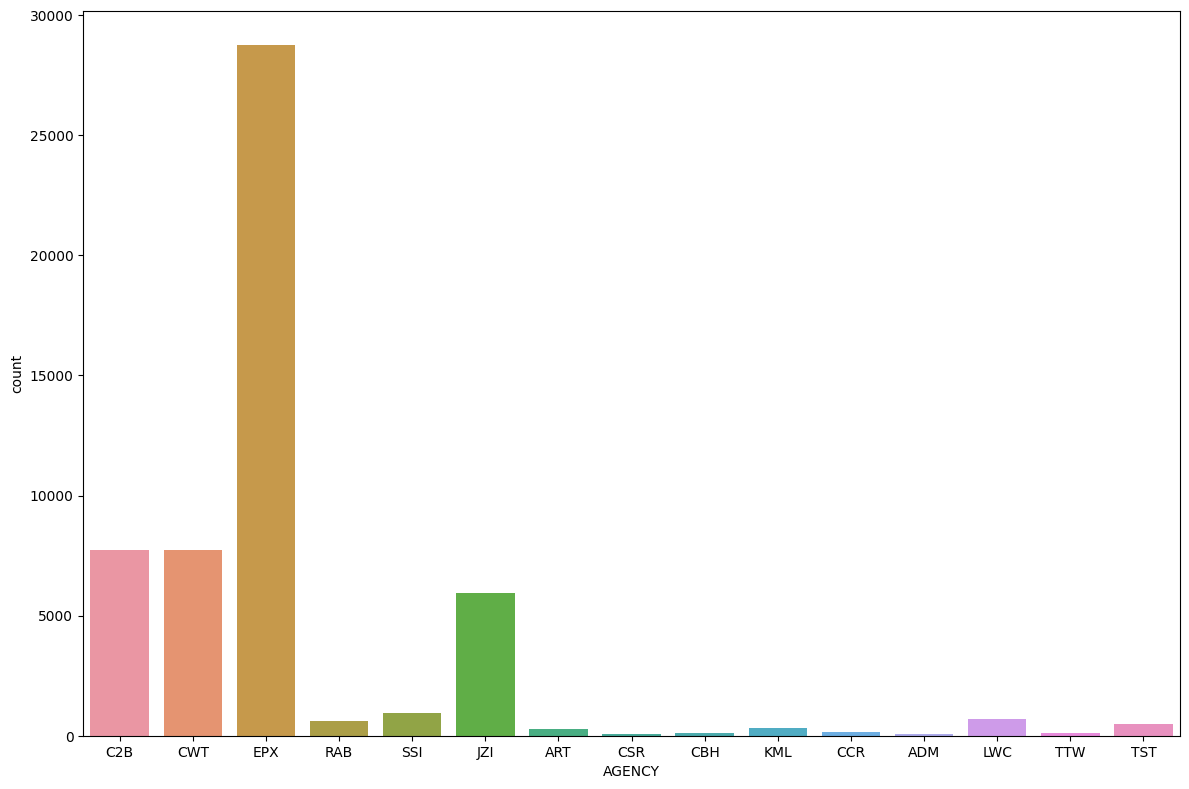

In [11]:
sns.countplot(data=df,x='AGENCY')
plt.tight_layout();

Majority of customers have enrolled with the EPX travel agency.

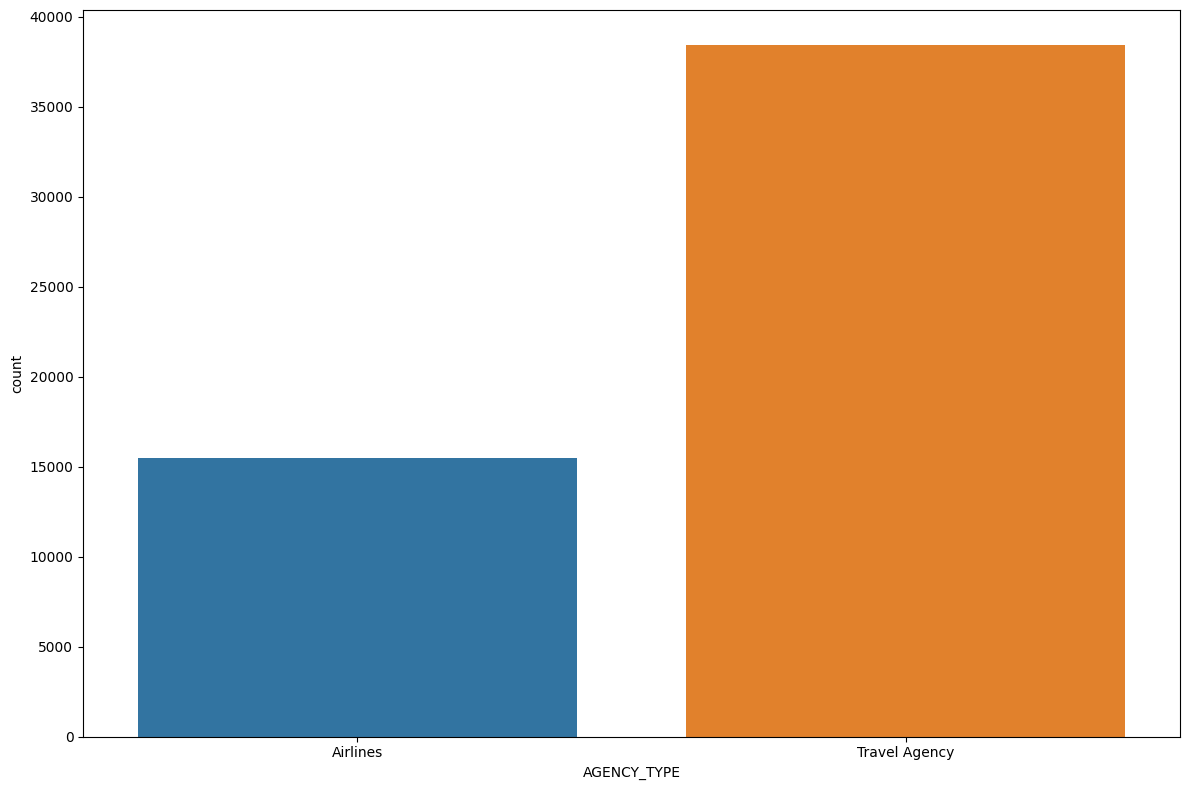

In [12]:
sns.countplot(data=df,x='AGENCY_TYPE')
plt.tight_layout();

A significant proportion of the customers have partnered with travel agencies.

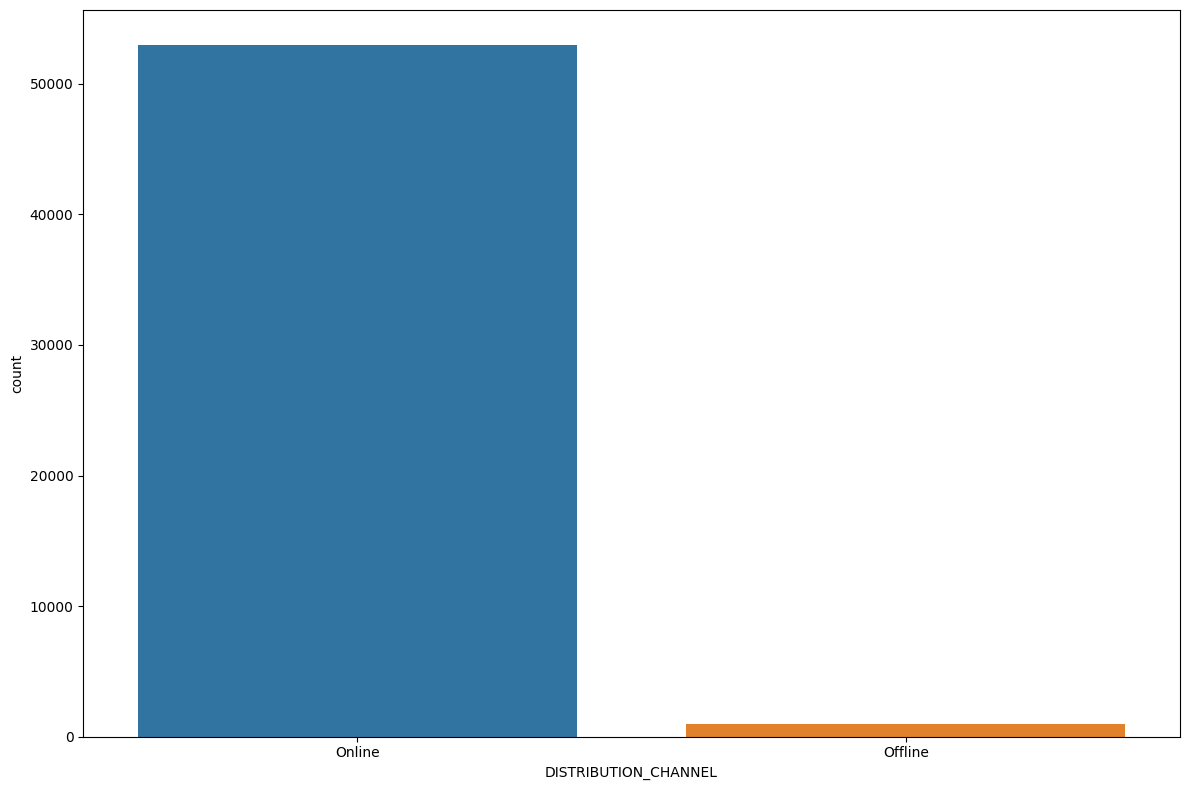

In [13]:
sns.countplot(data=df,x='DISTRIBUTION_CHANNEL')
plt.tight_layout();

The substantial number of travel insurance agencies have online distribution channels, with very few having a distribution channel in offline mode.

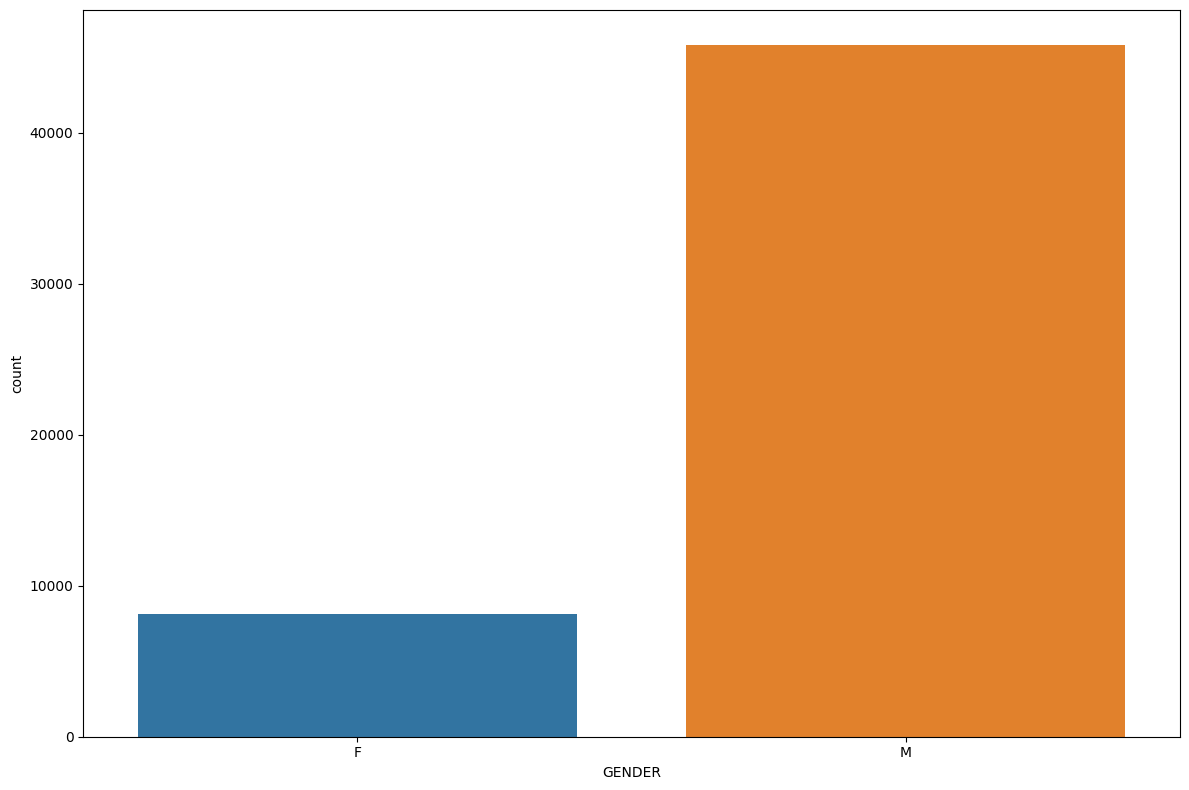

In [14]:
sns.countplot(data=df,x='GENDER')
plt.tight_layout();

A significant population of the travel insurance customers is male. In contrast, there are very less number of female customers.

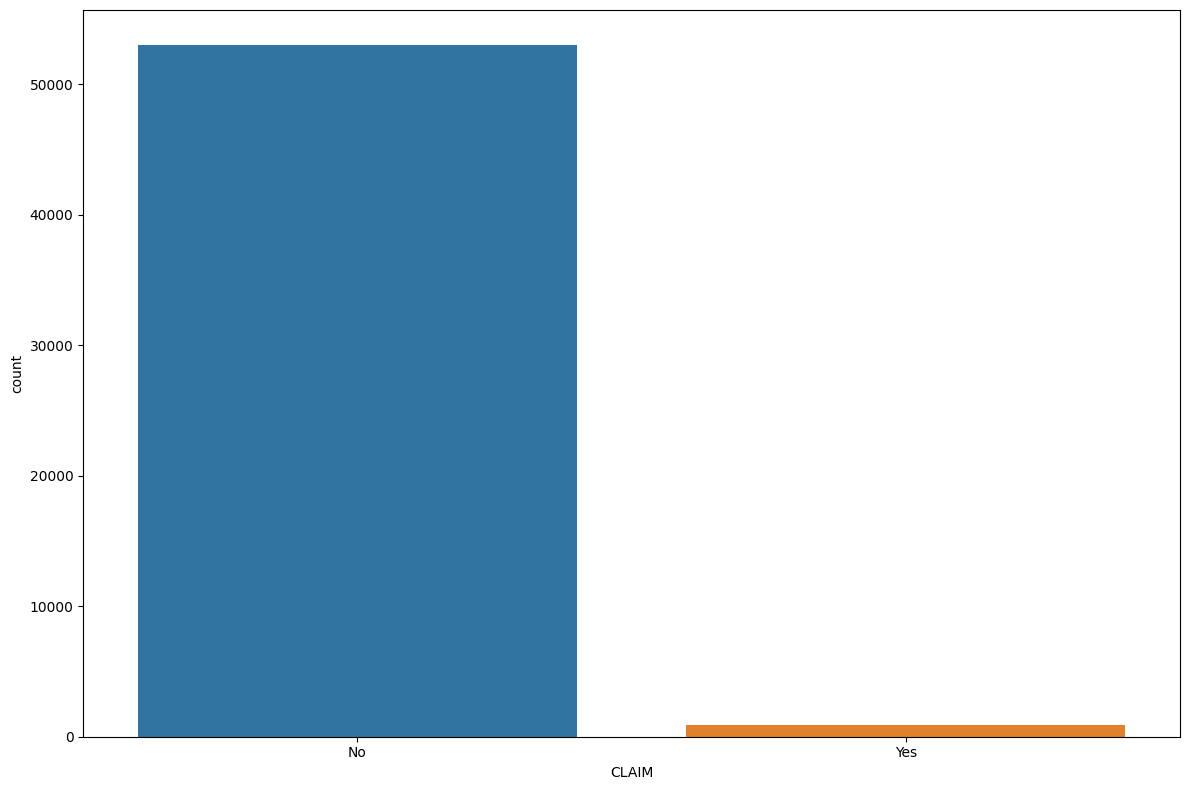

In [15]:
sns.countplot(data=df,x='CLAIM')
plt.tight_layout();

The travel insurance claims of majority of the customers were rejected by the insurance agencies. Only a minimal number of insurance claims were accepted. This suggests that this is a highly imbalanced dataset which needs to be balanced out later to ensure that it doesn't adversely affect the performance of machine learning algorithms.

## Feature Engineering

Skewness of DURATION: 23.12093427456567
Kurtosis of DURATION: 971.0628028793751


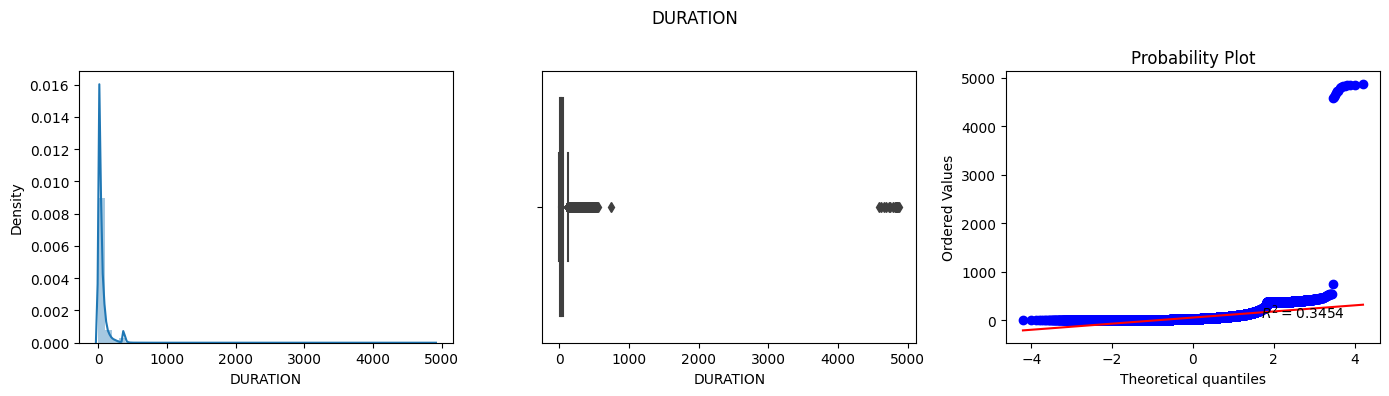

Skewness of NET_SALES: 3.5857691780201564
Kurtosis of NET_SALES: 18.4347918174657


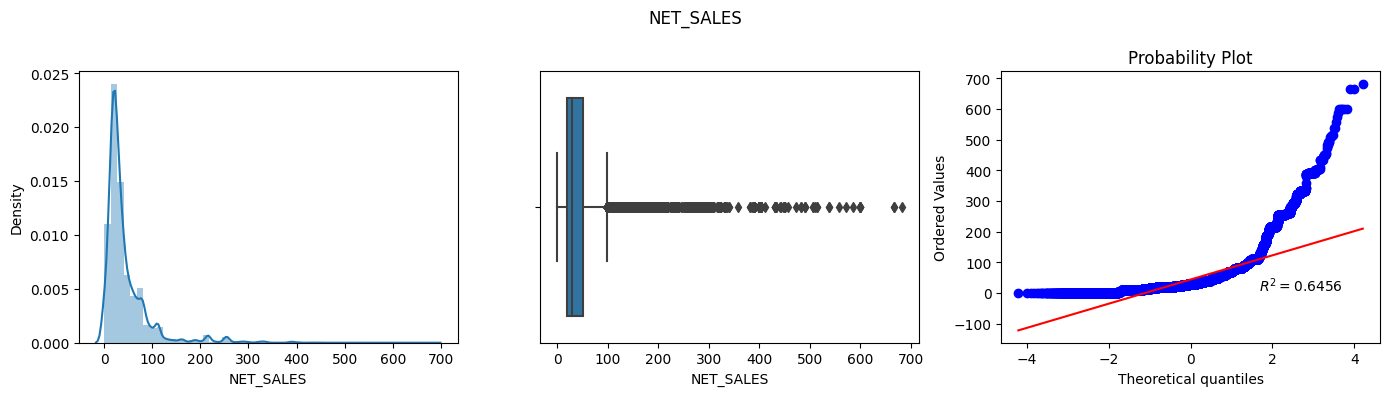

Skewness of AGE: 1.100138151017981
Kurtosis of AGE: 1.519647663978224


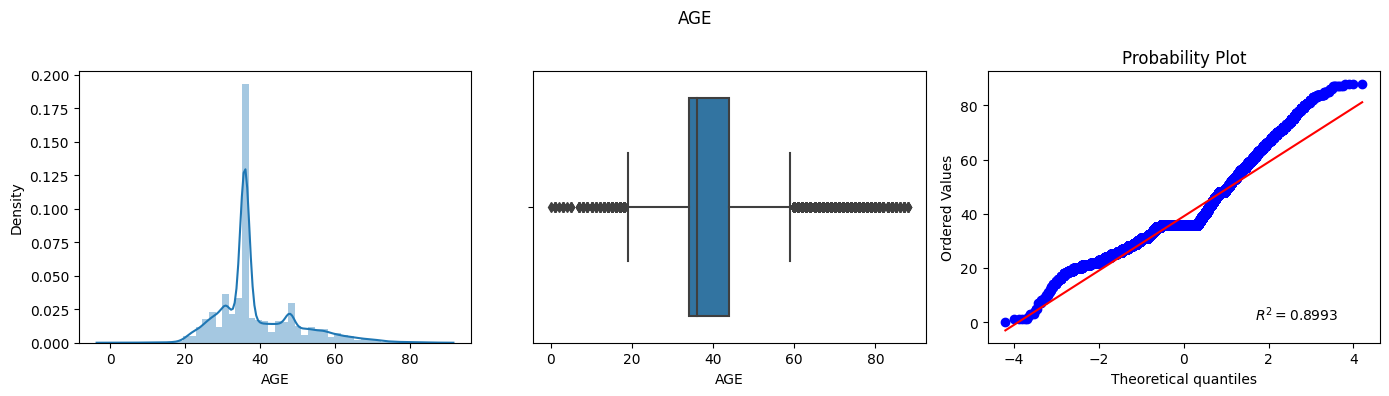

In [16]:
for col in df.select_dtypes(np.number).columns:
    print(f"Skewness of {col}:",df[col].skew())
    print(f"Kurtosis of {col}:",df[col].kurtosis())
    plt.figure(figsize=(14,4))
    plt.subplot(131)
    sns.distplot(df[col])
    plt.subplot(132)
    sns.boxplot(df[col])
    plt.subplot(133)
    probplot(df[col],plot=plt,rvalue=True,dist='norm')
    plt.suptitle(col)
    plt.tight_layout()
    plt.show();

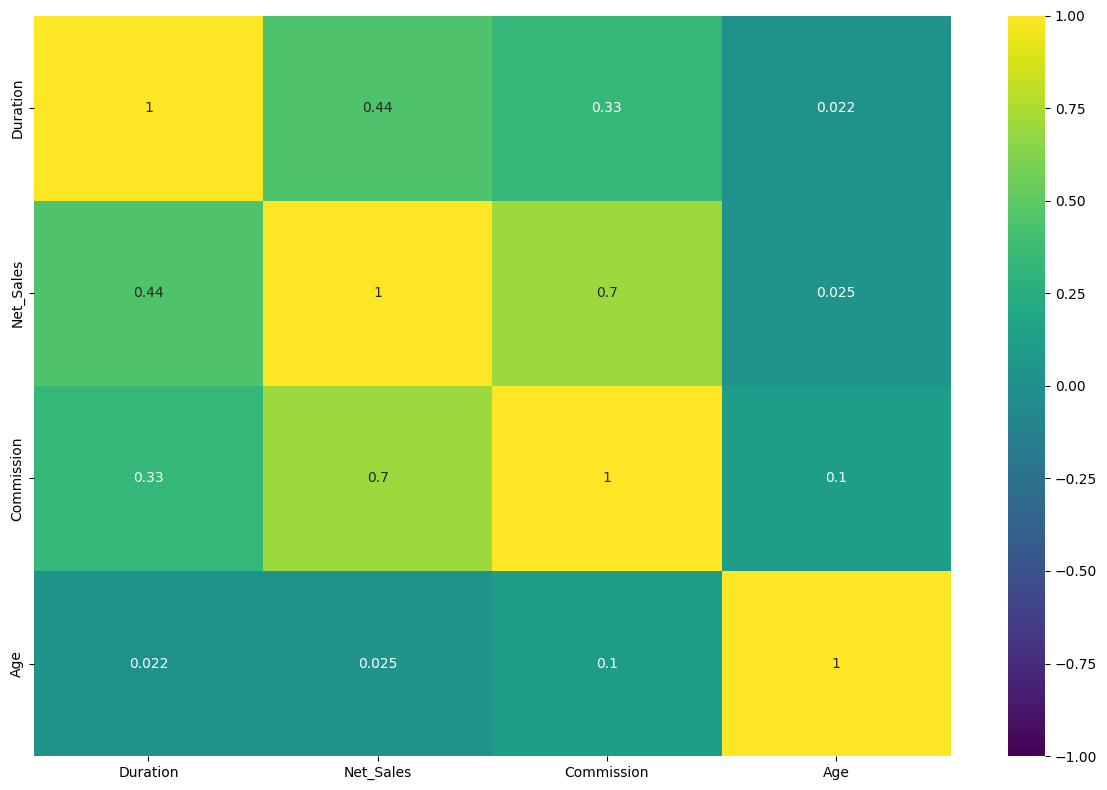

In [167]:
sns.heatmap(df.corr(),annot=True,cmap='viridis',vmin=-1.0,vmax=1.0)
plt.tight_layout();

There is a significant positive correlation between the features, "Net_Sales" and "Commission".

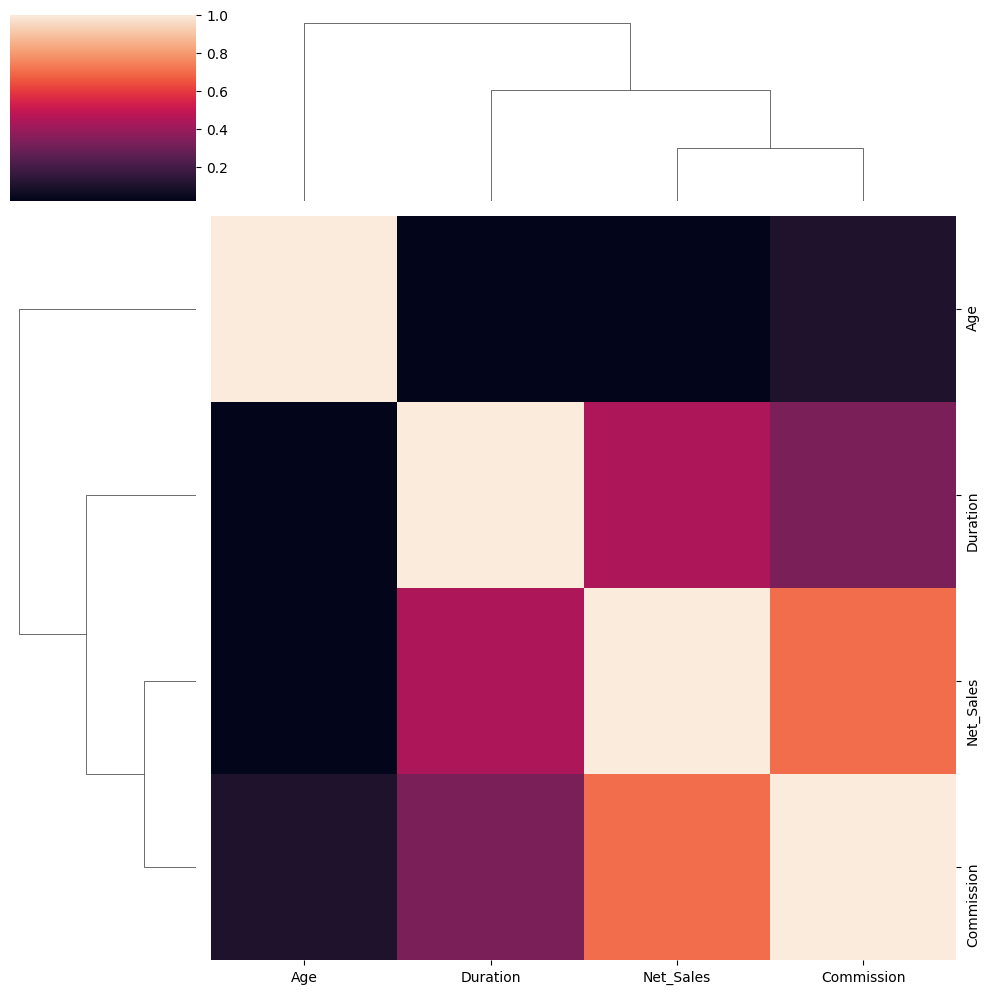

In [170]:
sns.clustermap(df.corr())
plt.tight_layout();

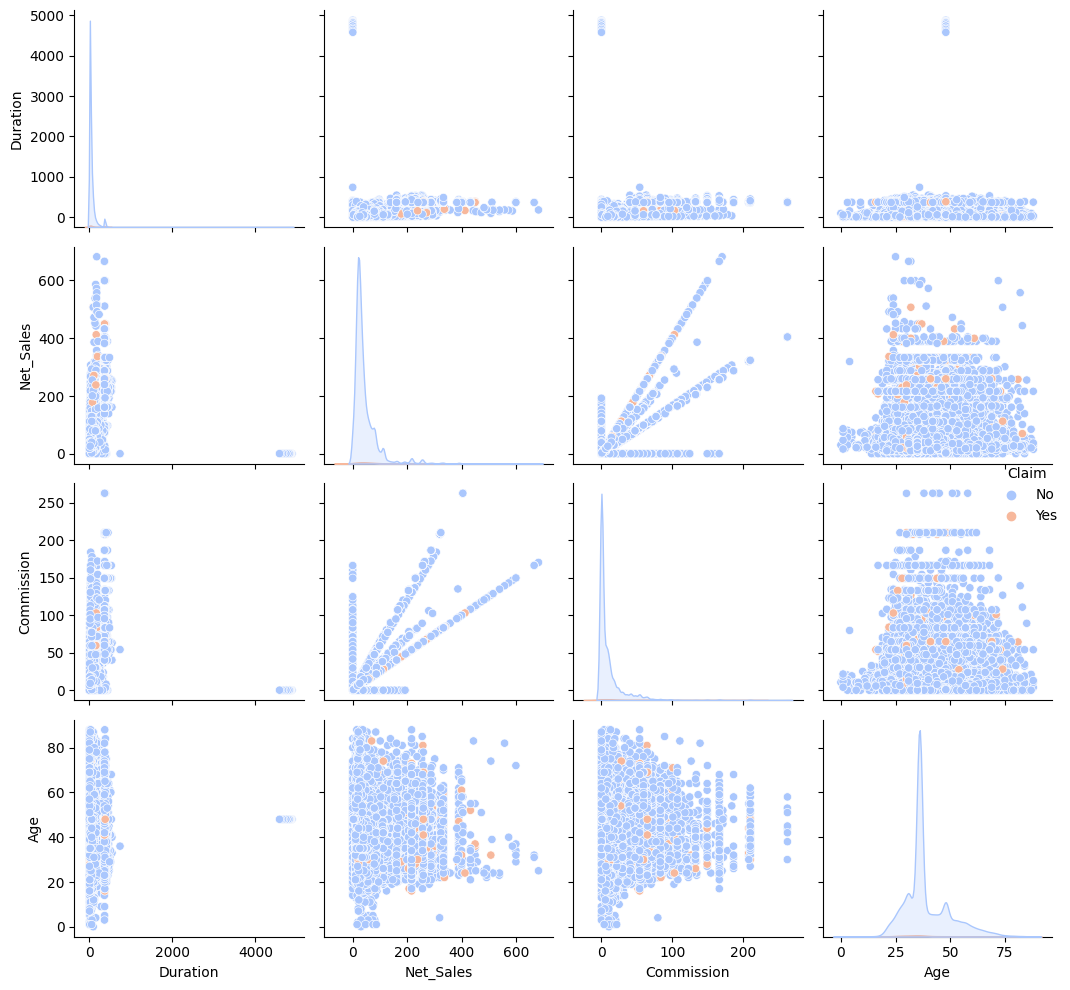

In [168]:
sns.pairplot(df,hue='Claim',palette='coolwarm')
plt.tight_layout();

### Feature Transformation

In [17]:
def apply_transform(transformer,col):
    plt.figure(figsize=(14,4))
    plt.subplot(131)
    sns.distplot(df[col])
    plt.subplot(132)
    sns.boxplot(df[col])
    plt.subplot(133)
    probplot(df[col],rvalue=True,plot=plt,dist='norm')
    plt.suptitle(f"{col} Before Transform")
    plt.tight_layout()
    plt.show()
    col_tf = transformer.fit_transform(df[[col]])
    col_tf = np.array(col_tf).reshape(col_tf.shape[0])
    plt.figure(figsize=(14,4))
    plt.subplot(131)
    sns.distplot(col_tf)
    plt.subplot(132)
    sns.boxplot(col_tf)
    plt.subplot(133)
    probplot(col_tf,rvalue=True,plot=plt,dist='norm')
    plt.suptitle(f"{col} After Transform")
    plt.tight_layout()
    plt.show();

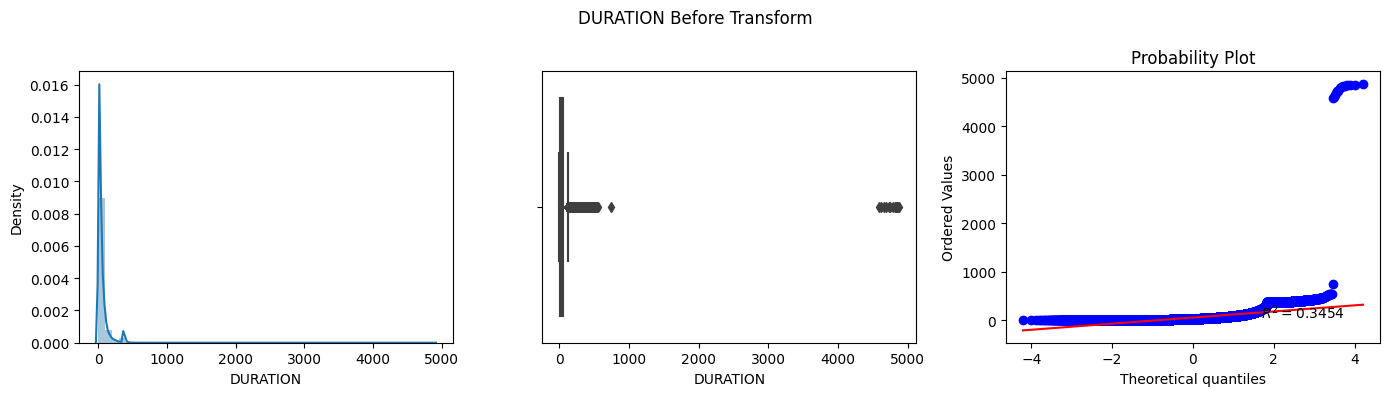

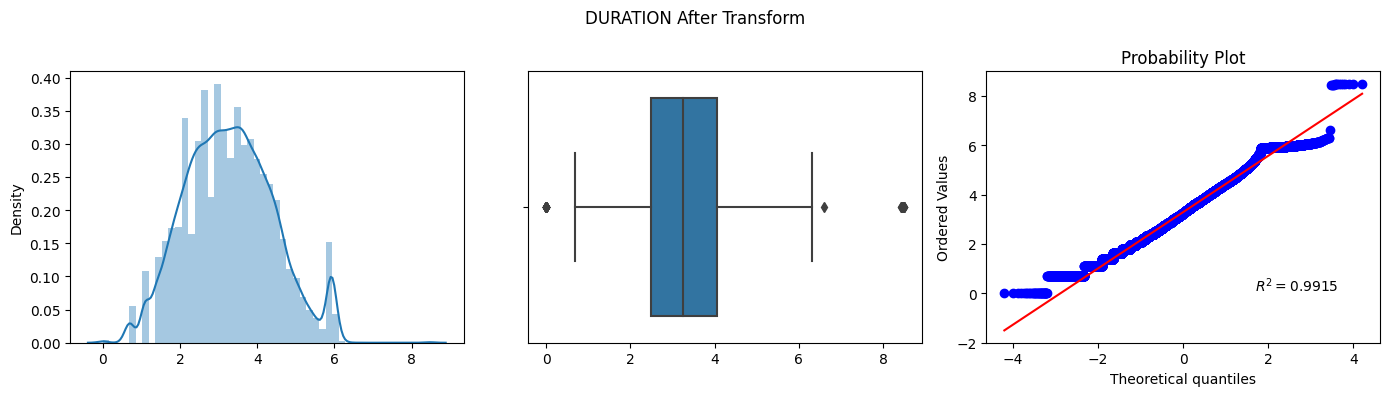

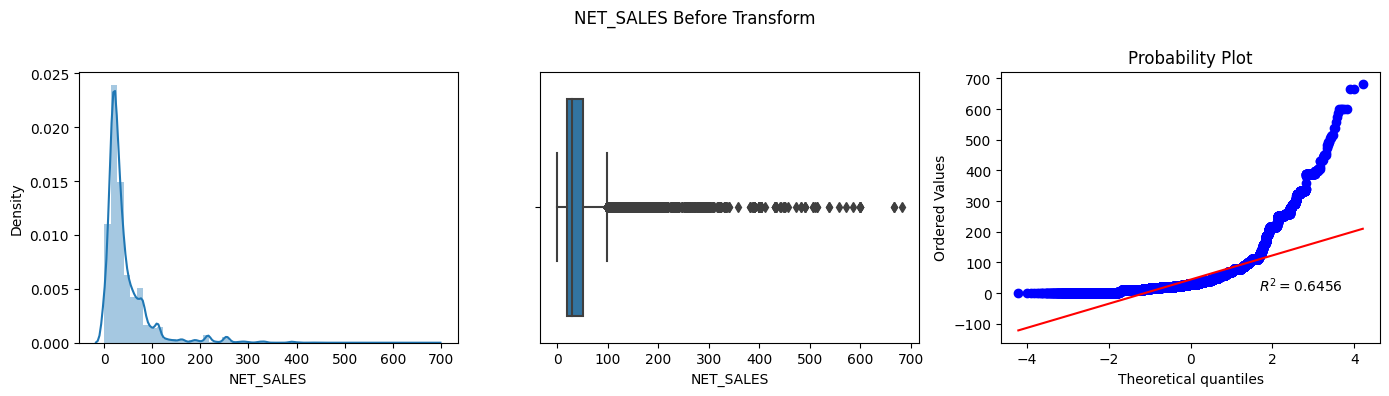

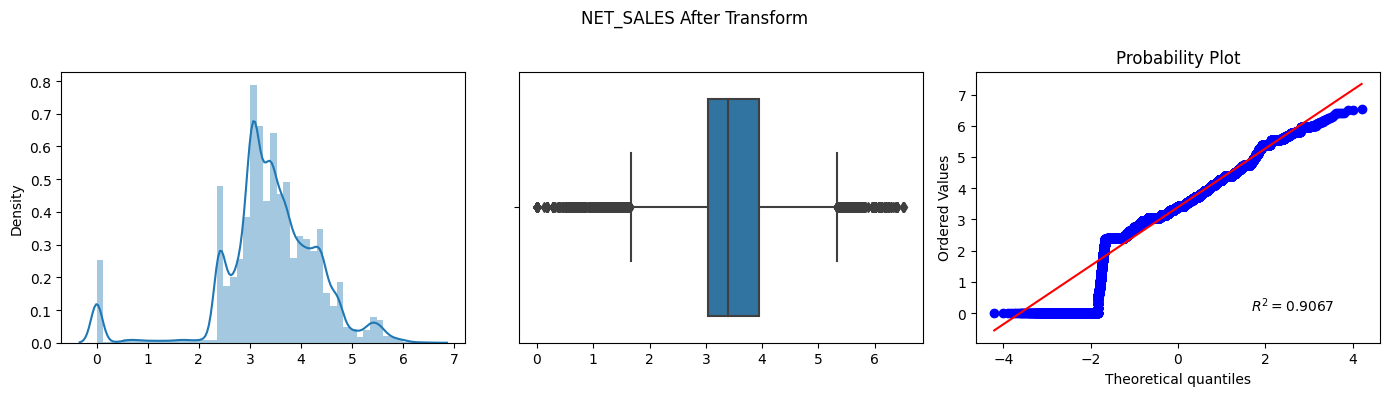

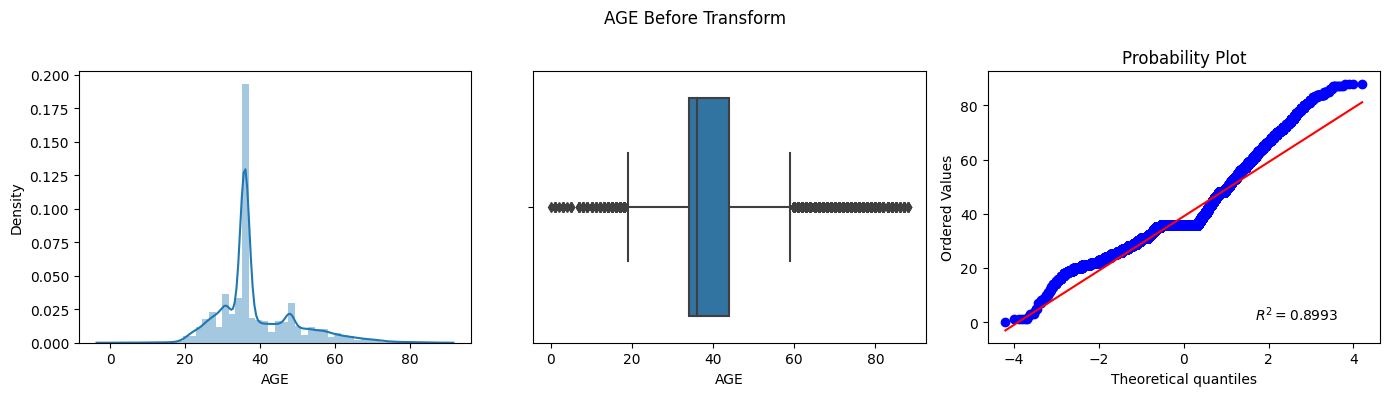

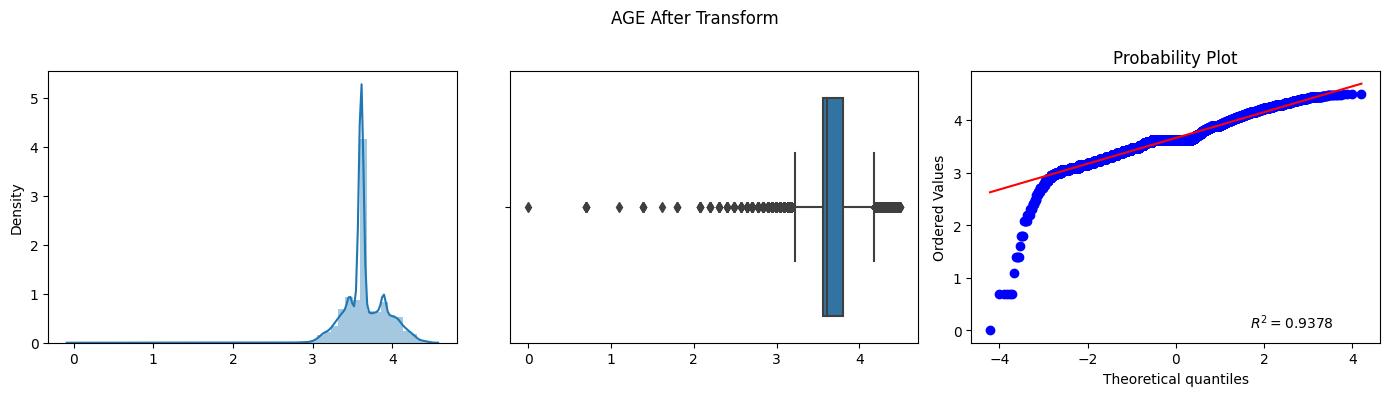

In [18]:
skewed_cols = ['DURATION','NET_SALES','AGE']

for col in skewed_cols:
    apply_transform(FunctionTransformer(lambda x: np.log1p(x)),col)

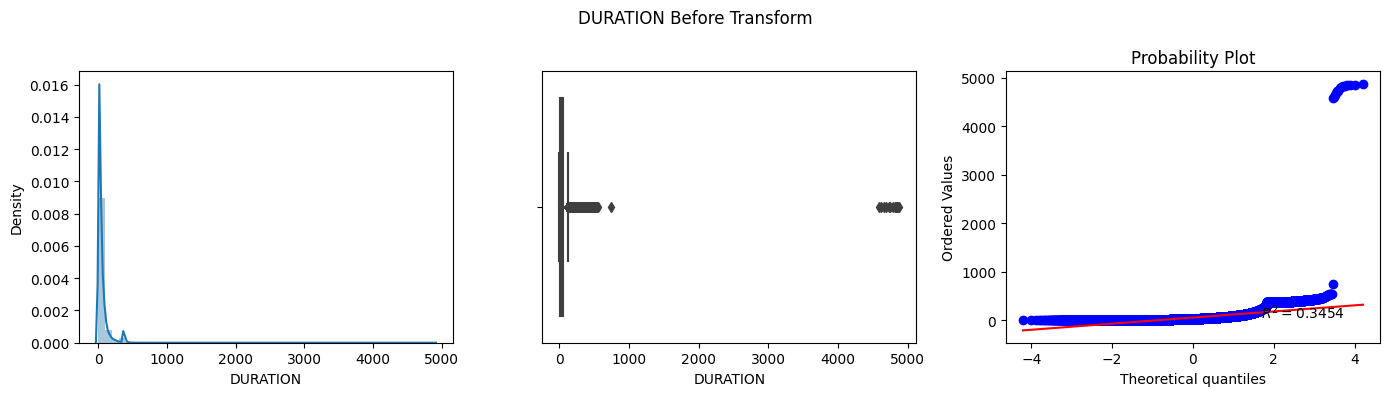

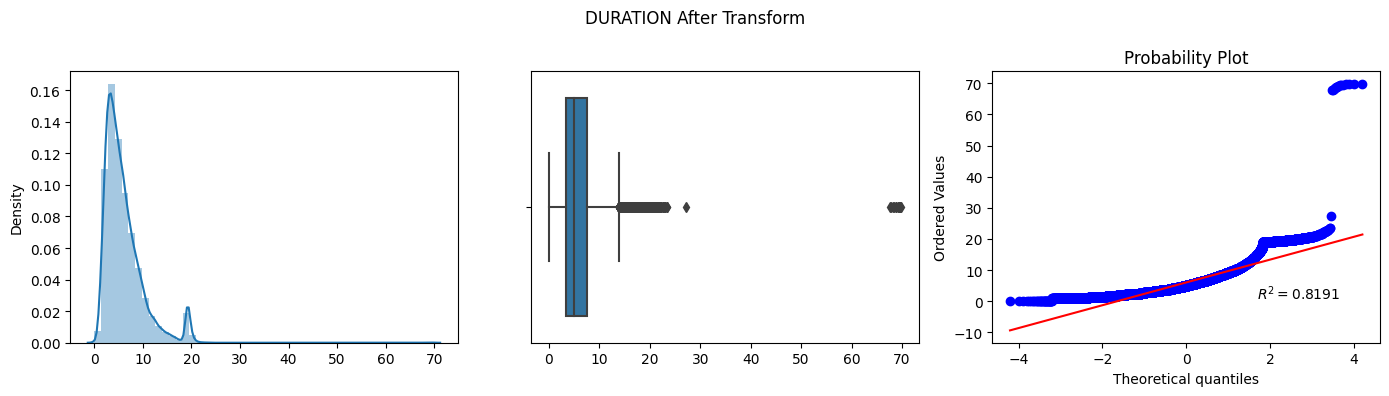

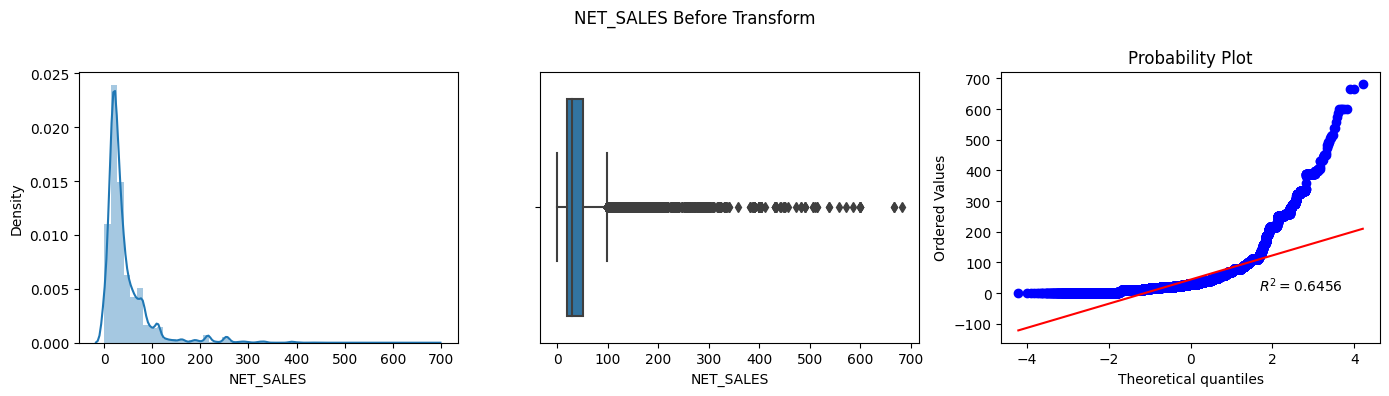

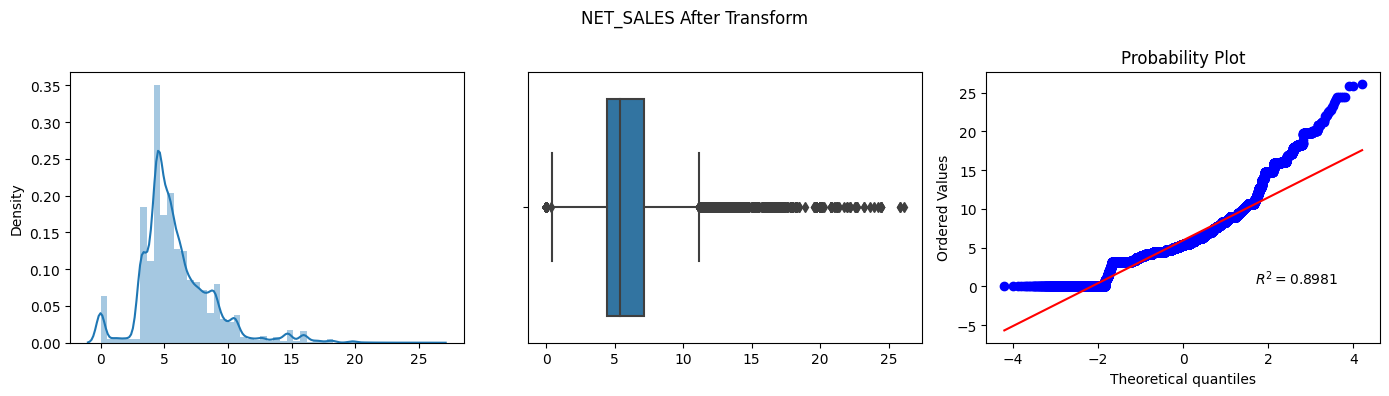

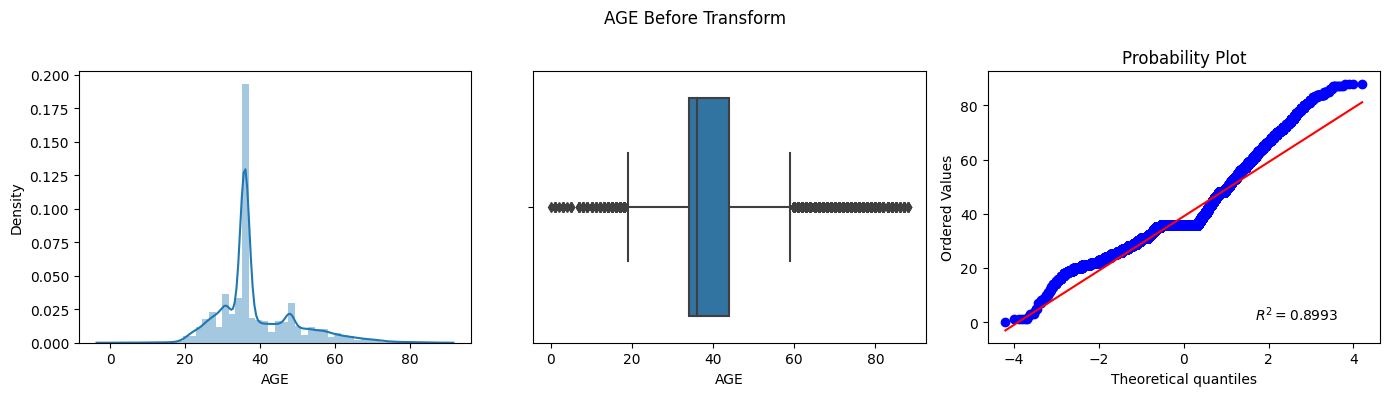

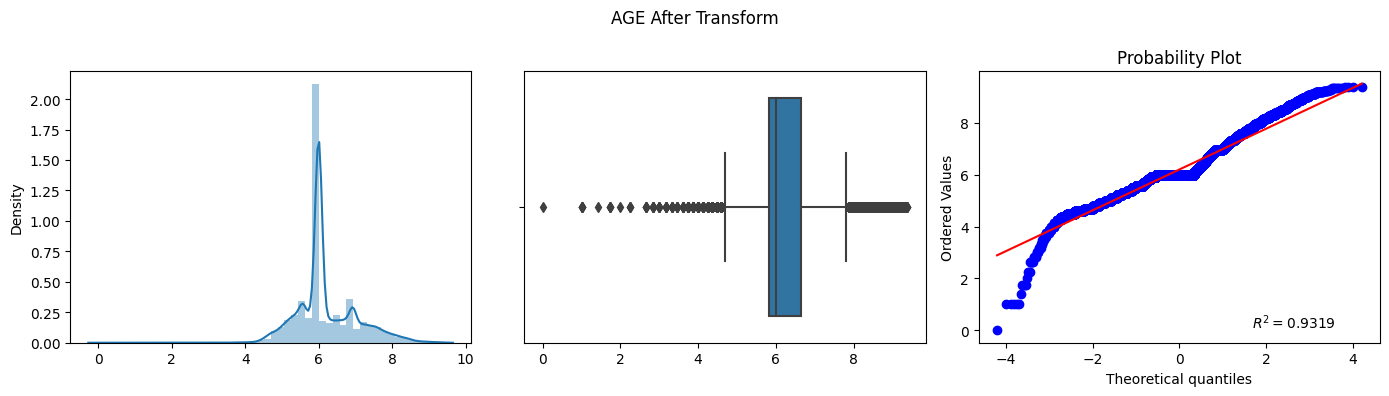

In [19]:
for col in skewed_cols:
    apply_transform(FunctionTransformer(lambda x: np.sqrt(x)),col)

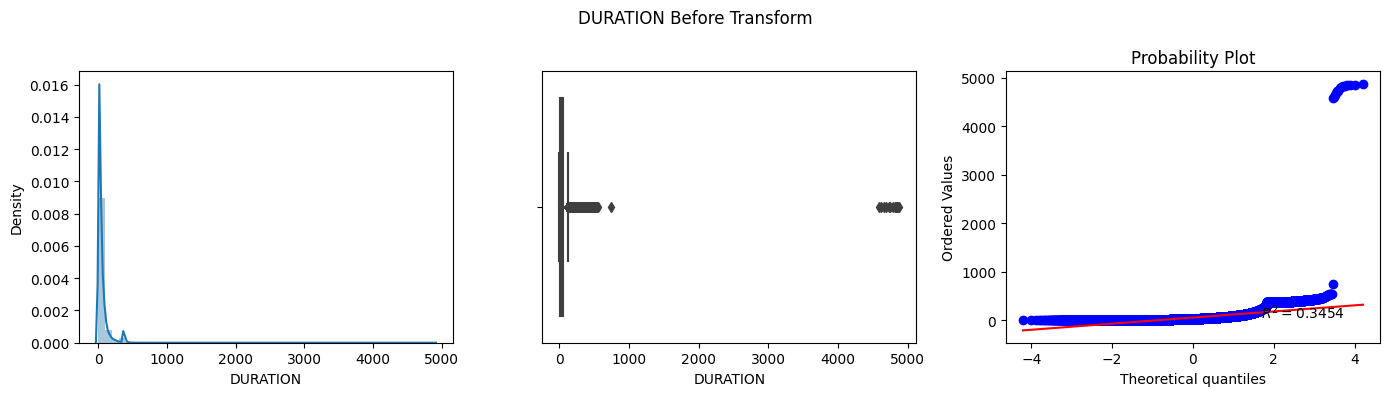

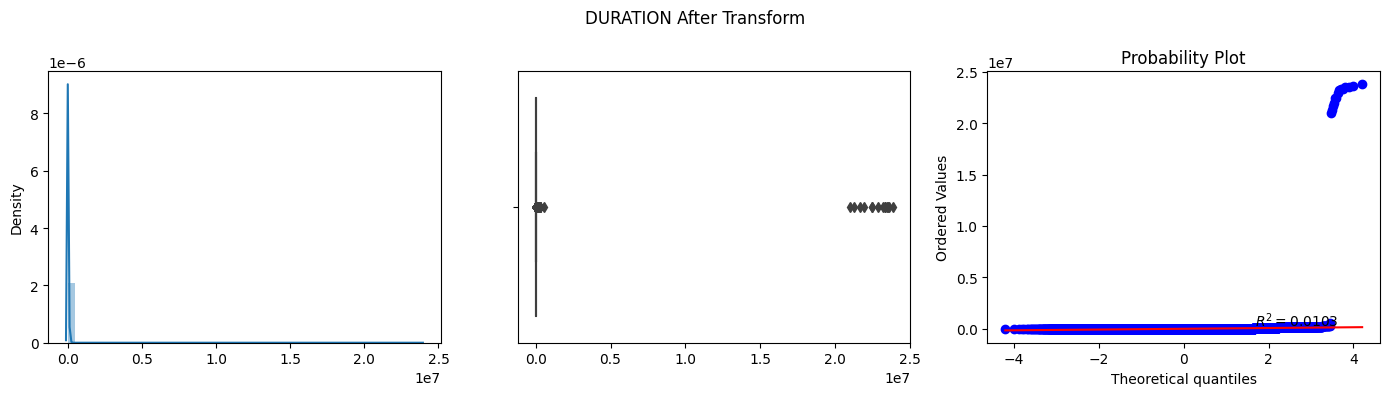

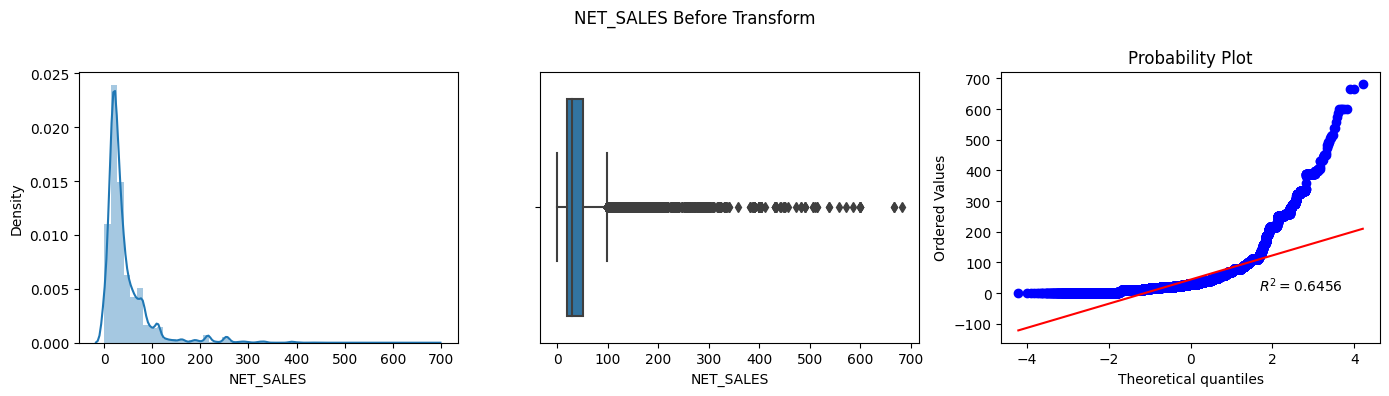

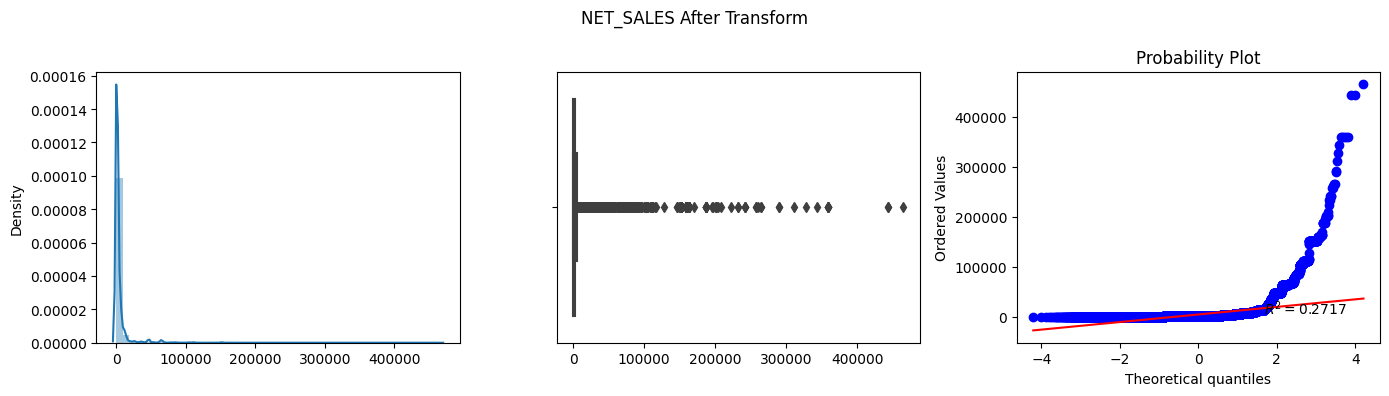

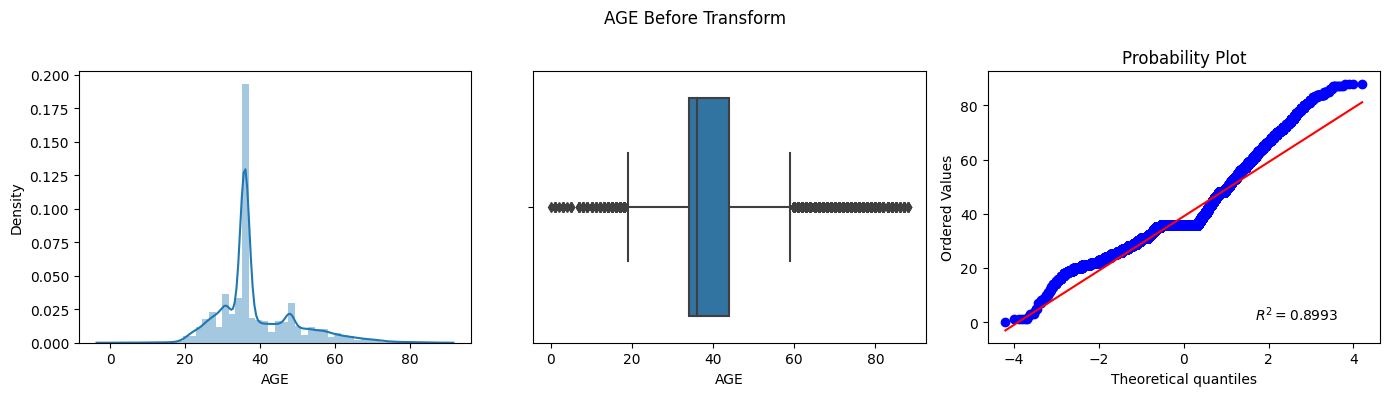

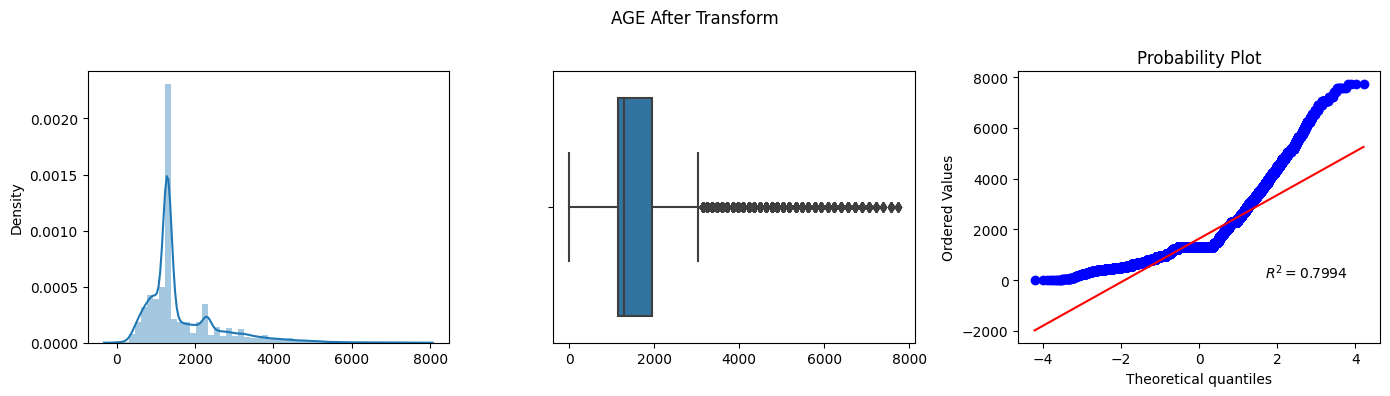

In [20]:
for col in skewed_cols:
    apply_transform(FunctionTransformer(lambda x: x**2),col)

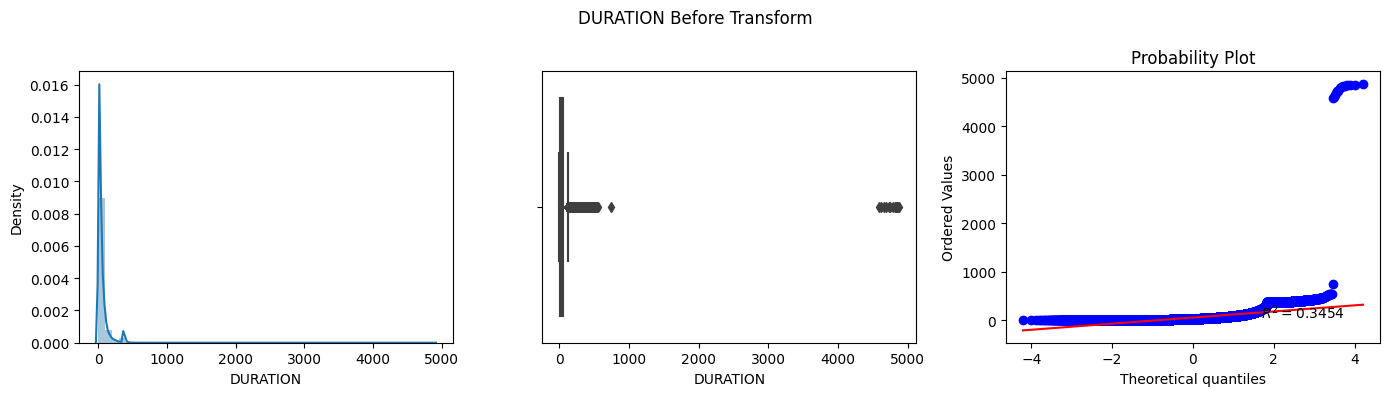

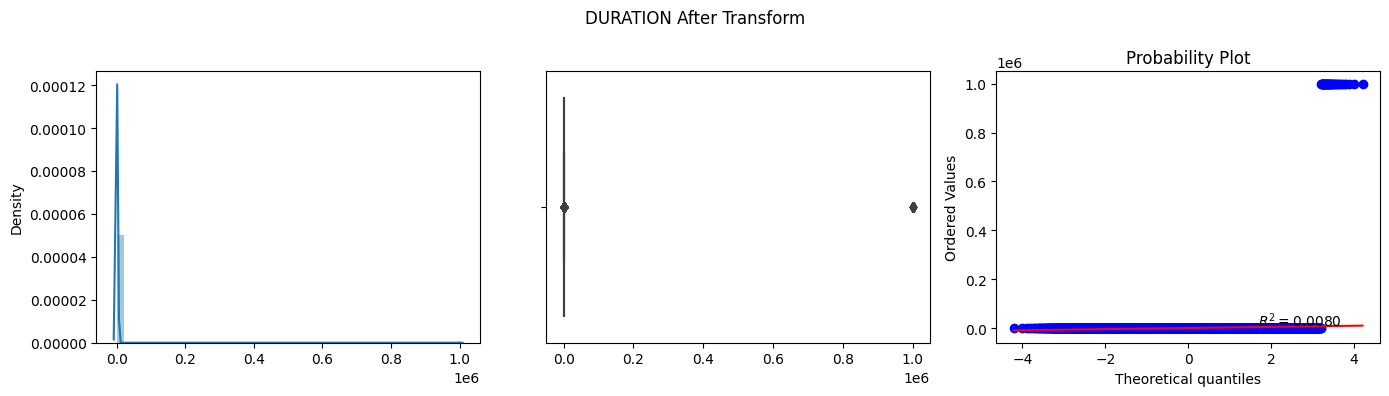

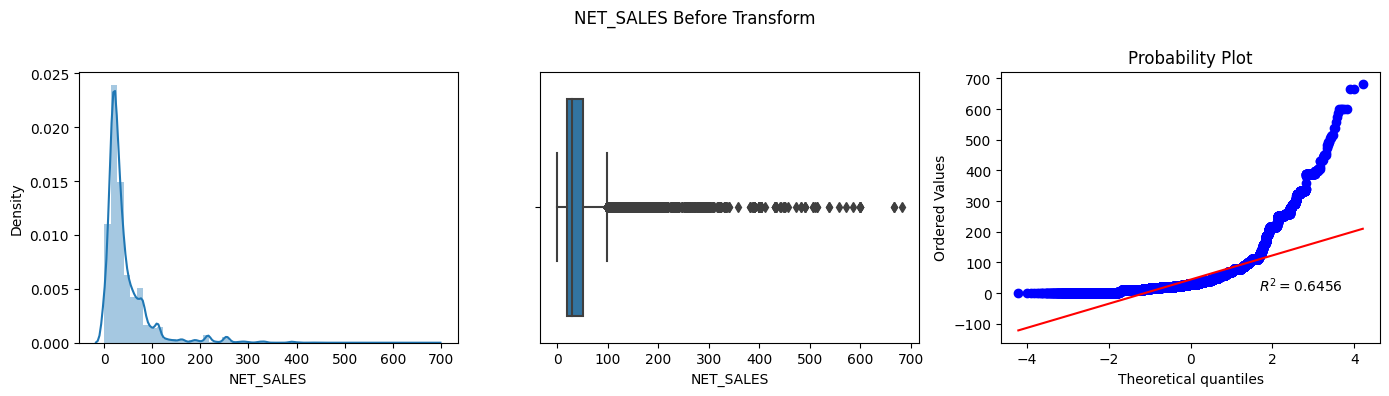

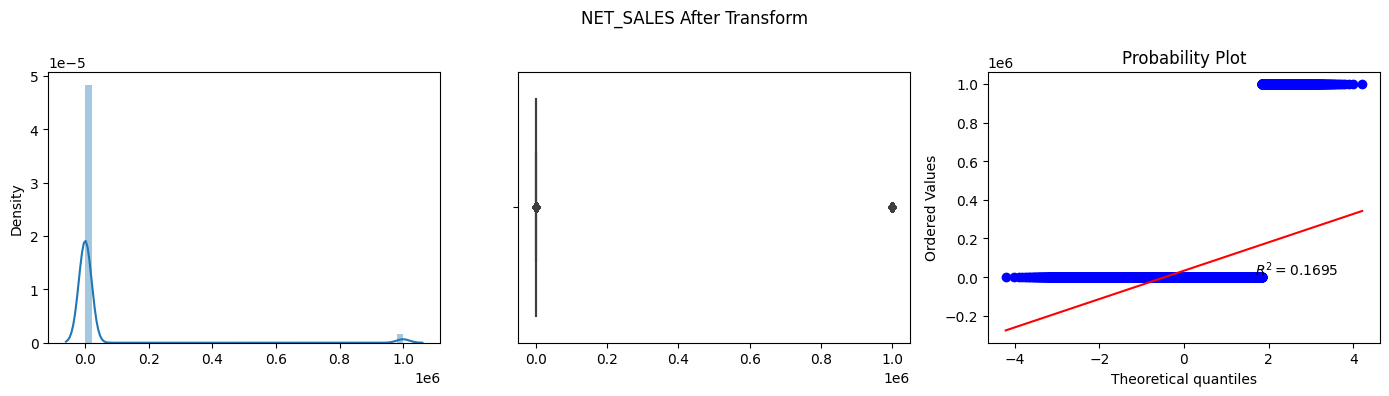

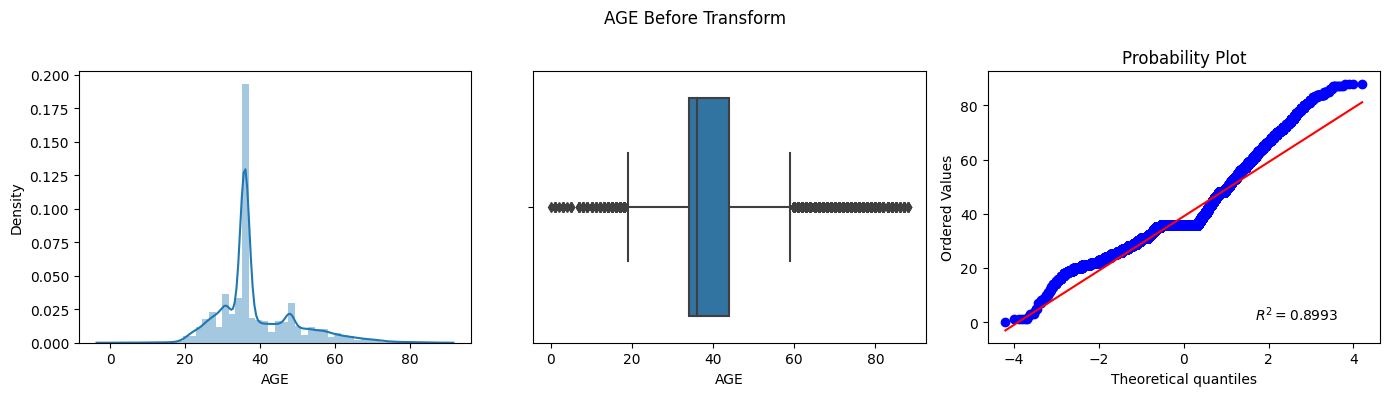

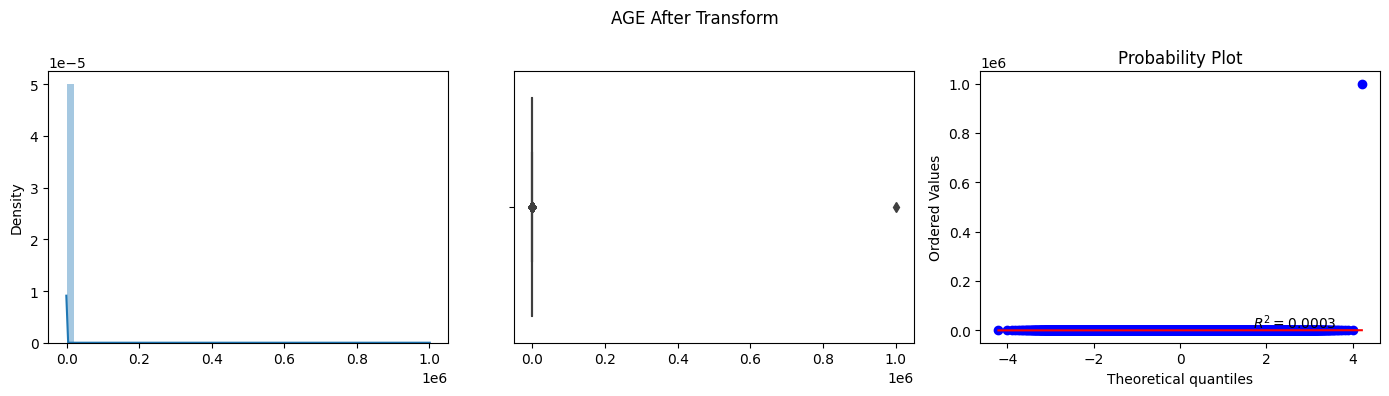

In [21]:
for col in skewed_cols:
    apply_transform(FunctionTransformer(lambda x: 1/(x+0.000001)),col)

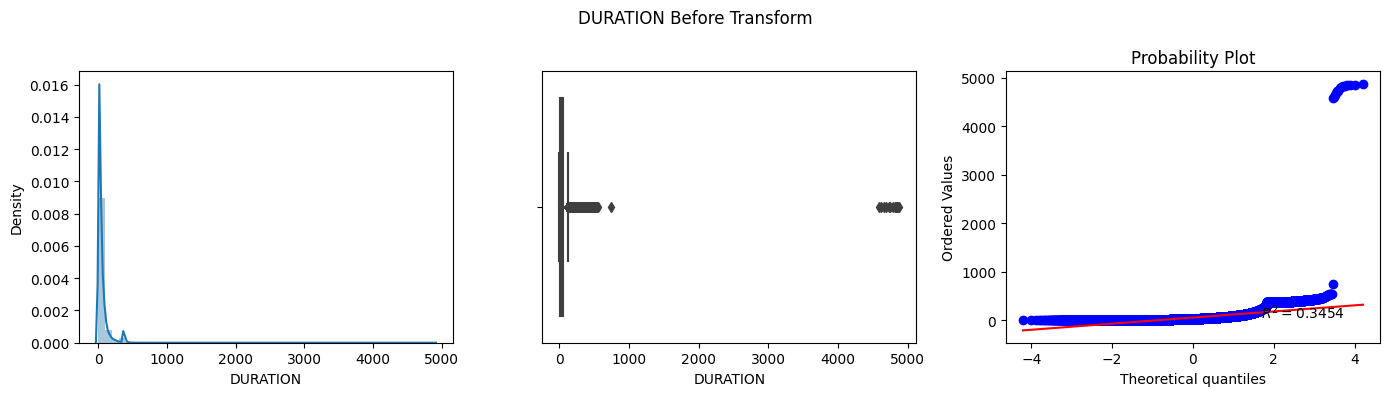

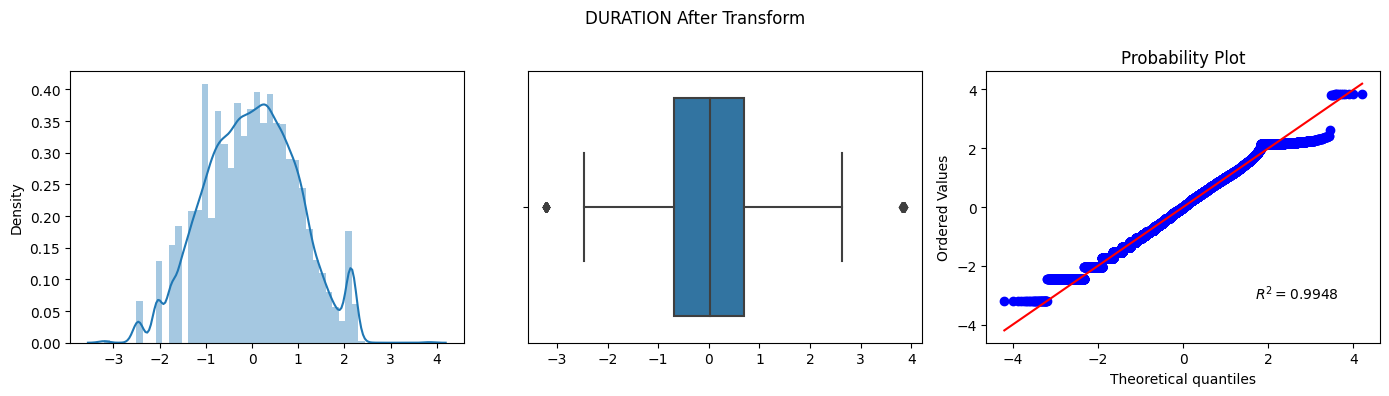

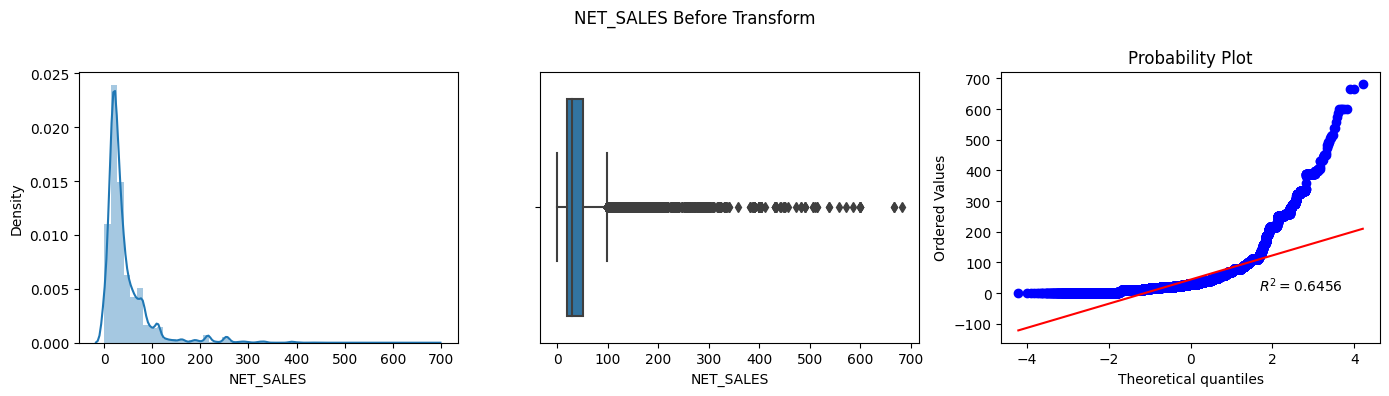

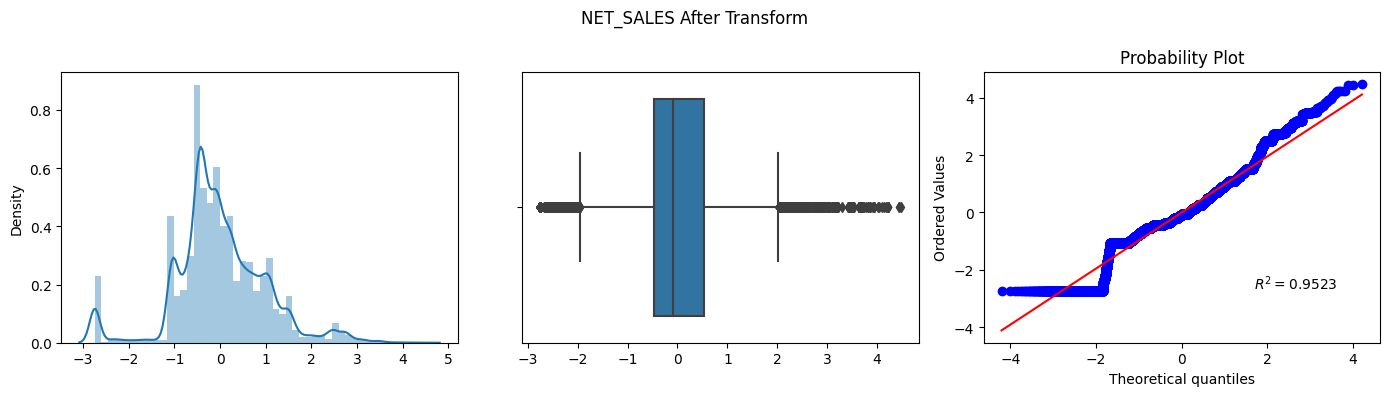

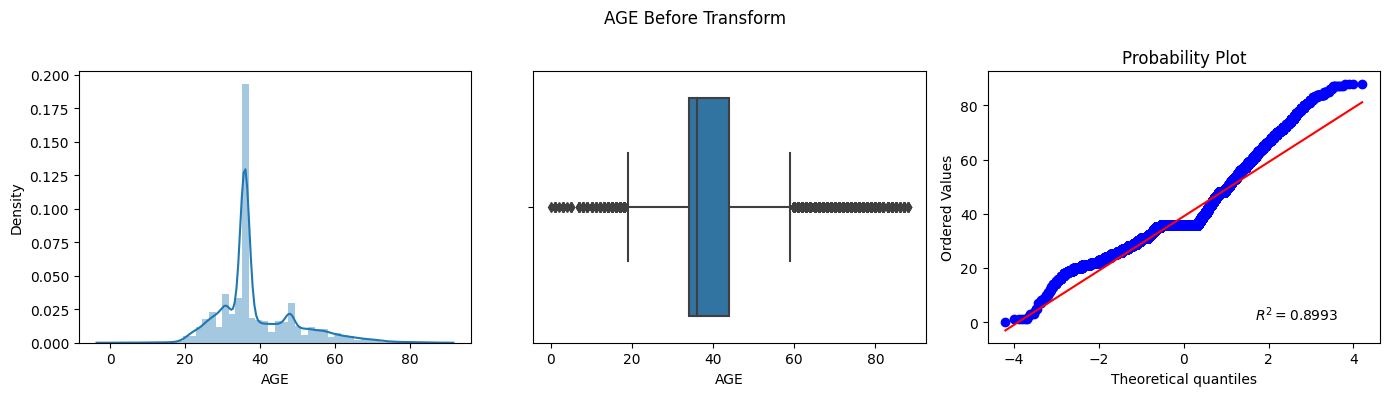

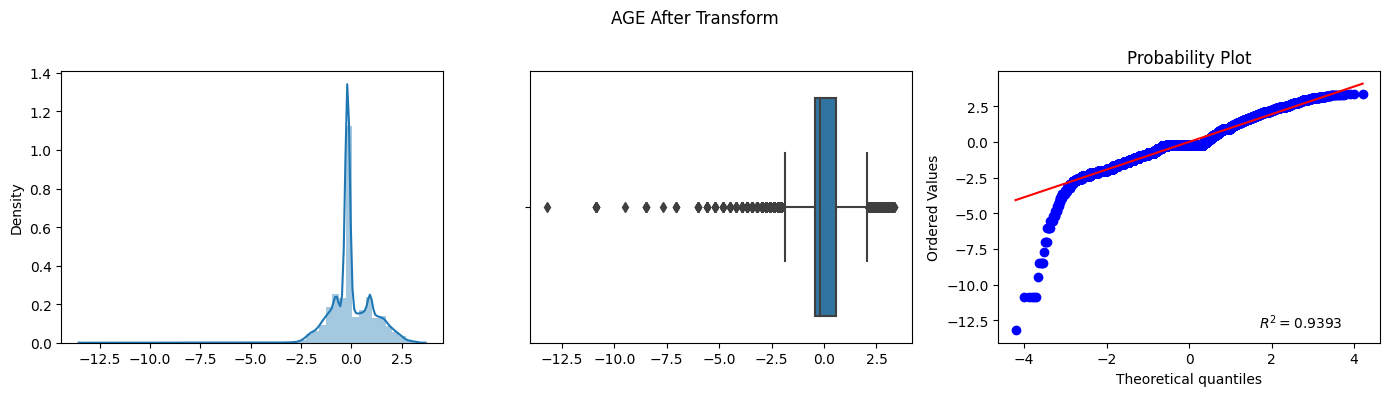

In [22]:
for col in skewed_cols:
    apply_transform(PowerTransformer(),col)

The Power Transformer i.e. the Yeo-Johnson transform produces the best results among all the feature transformations applied on the skewed columns "DURATION", "NET_SALES" and "AGE".

In [23]:
pt = PowerTransformer()

for col in skewed_cols:
    col_tf = pt.fit_transform(df[[col]])
    col_tf = np.array(col_tf).reshape(col_tf.shape[0])
    df[col] = col_tf

Skewness of DURATION: 0.008639803798645457
Kurtosis of DURATION: -0.3136785378043383


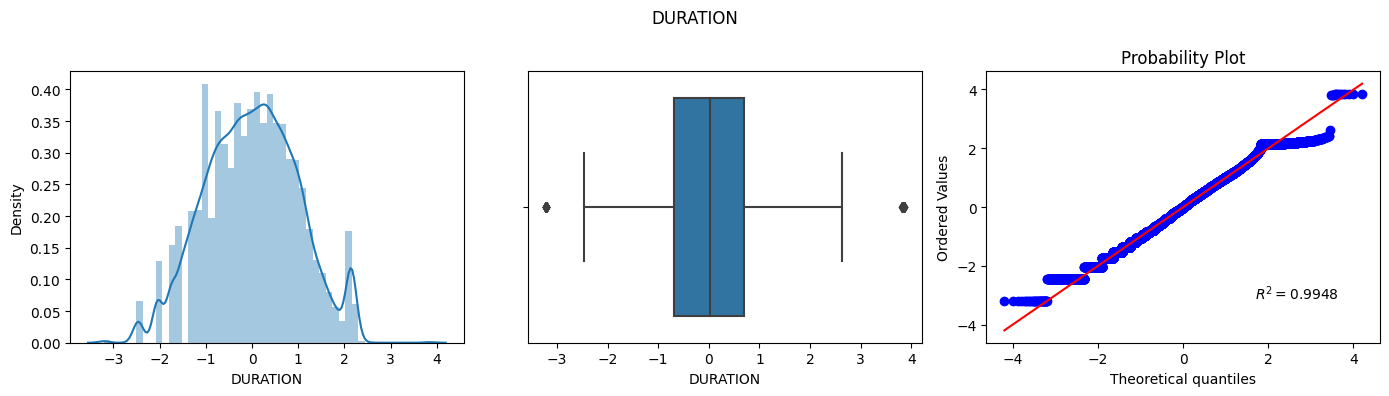

Skewness of NET_SALES: 0.10180788304616918
Kurtosis of NET_SALES: 1.6506109272690623


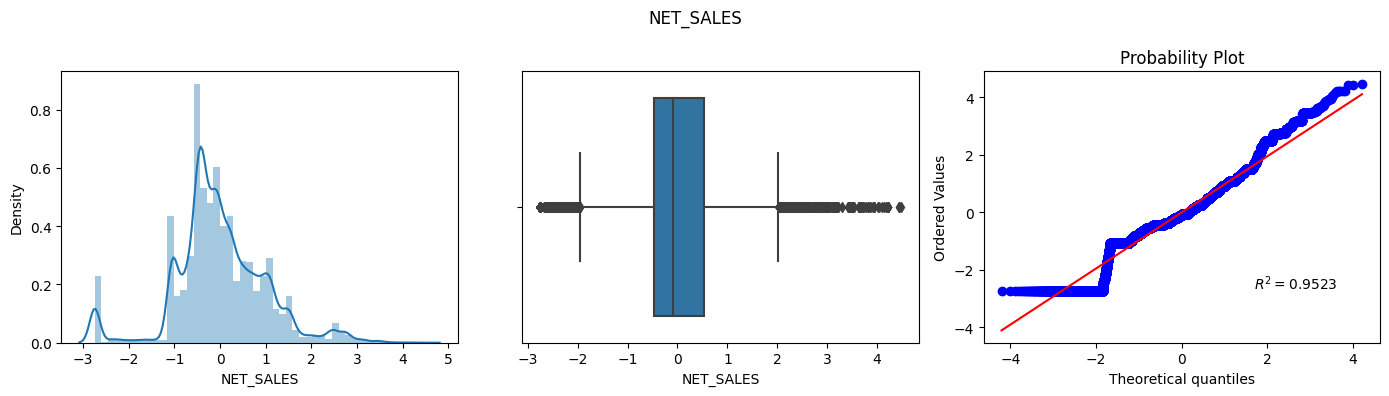

Skewness of AGE: 0.0145915982766331
Kurtosis of AGE: 3.243522708897738


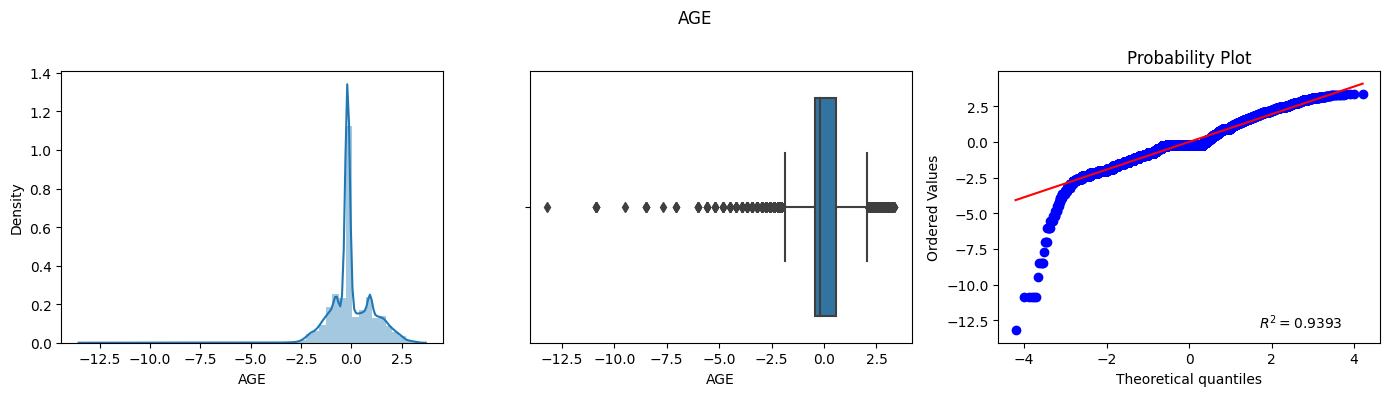

In [24]:
for col in df.select_dtypes(np.number).columns:
    print(f"Skewness of {col}:",df[col].skew())
    print(f"Kurtosis of {col}:",df[col].kurtosis())
    plt.figure(figsize=(14,4))
    plt.subplot(131)
    sns.distplot(df[col])
    plt.subplot(132)
    sns.boxplot(df[col])
    plt.subplot(133)
    probplot(df[col],plot=plt,rvalue=True,dist='norm')
    plt.suptitle(col)
    plt.tight_layout()
    plt.show();

### Outlier Treatment

In [25]:
def treat_outliers(data,col):
    lower_limit, upper_limit = data[col].quantile([0.25,0.75])
    IQR = upper_limit - lower_limit
    lower_whisker = lower_limit - 1.5 * IQR
    upper_whisker = upper_limit + 1.5 * IQR
    return np.where(data[col]>upper_whisker,upper_whisker,np.where(data[col]<lower_whisker,lower_whisker,data[col]))

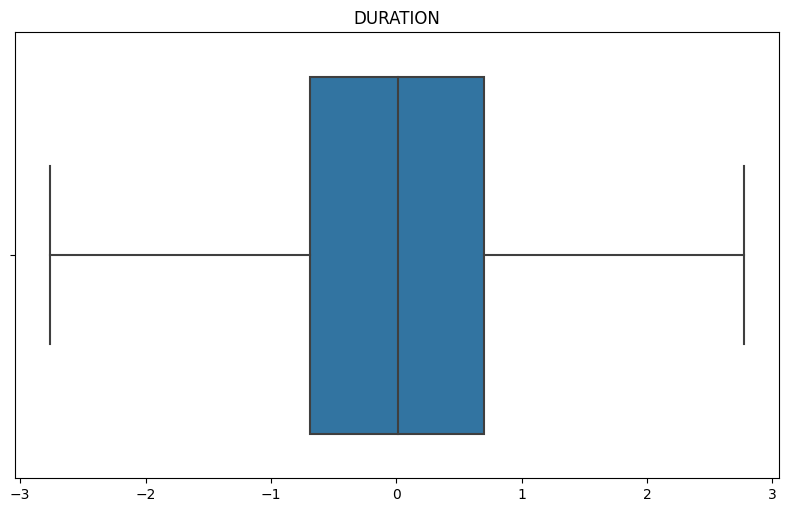

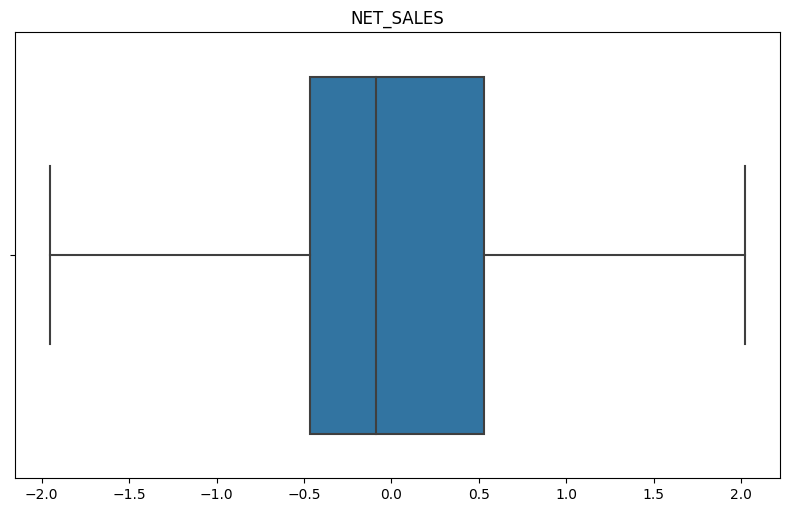

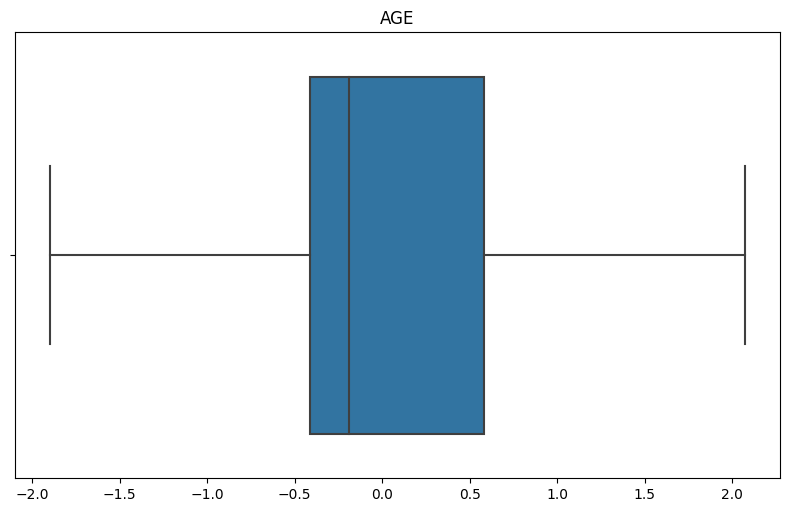

In [26]:
for col in skewed_cols:
    plt.figure(figsize=(8,5))
    sns.boxplot(treat_outliers(df,col))
    plt.tight_layout()
    plt.title(col)
    plt.show();

In [27]:
for col in skewed_cols:
    df[col] = treat_outliers(df,col)

Skewness of DURATION: 0.007559289129470874
Kurtosis of DURATION: -0.3678491374534971


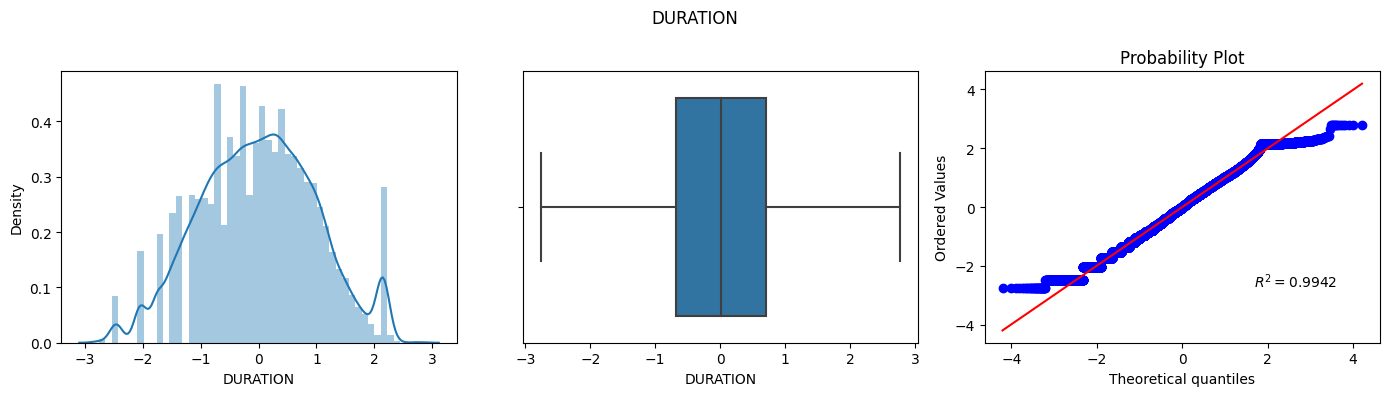

Skewness of NET_SALES: 0.22452942252594854
Kurtosis of NET_SALES: 0.09087590923043365


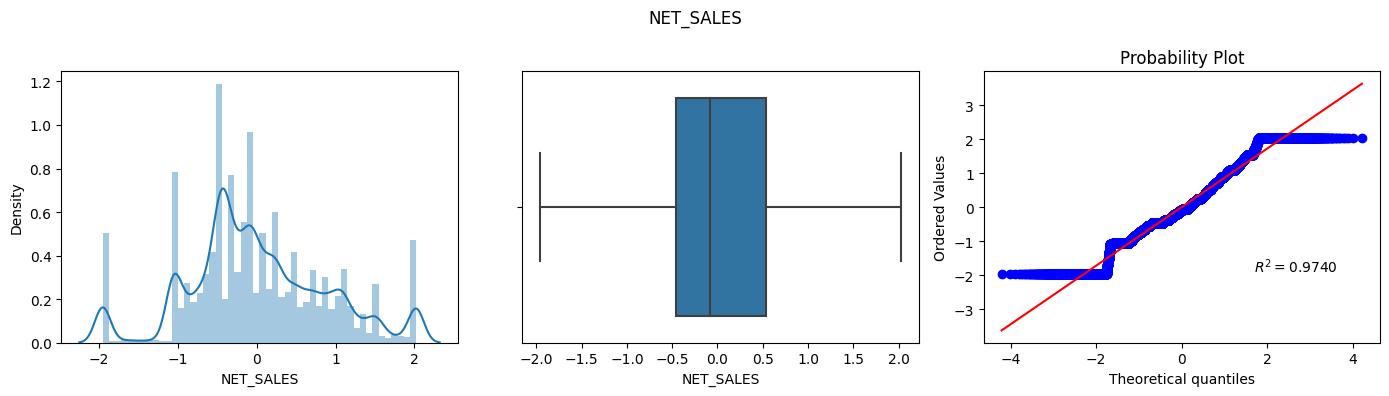

Skewness of AGE: 0.3490120955332293
Kurtosis of AGE: -0.10004825521052307


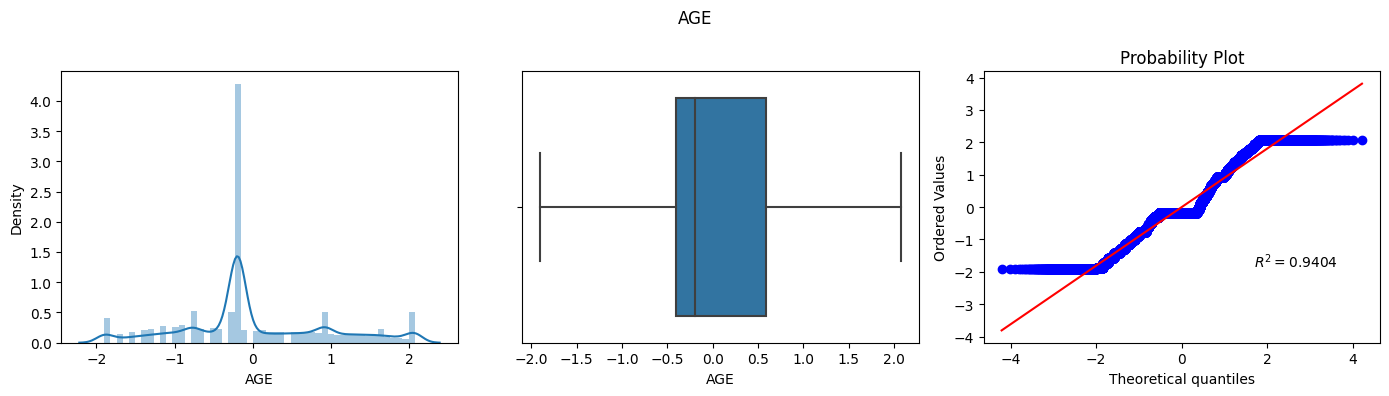

In [28]:
for col in df.select_dtypes(np.number).columns:
    print(f"Skewness of {col}:",df[col].skew())
    print(f"Kurtosis of {col}:",df[col].kurtosis())
    plt.figure(figsize=(14,4))
    plt.subplot(131)
    sns.distplot(df[col])
    plt.subplot(132)
    sns.boxplot(df[col])
    plt.subplot(133)
    probplot(df[col],plot=plt,rvalue=True,dist='norm')
    plt.suptitle(col)
    plt.tight_layout()
    plt.show();

### Categorical Encoding

In [29]:
agency_type_encoder = OrdinalEncoder(categories=[['Airlines','Travel Agency']])
df.AGENCY_TYPE = agency_type_encoder.fit_transform(df[['AGENCY_TYPE']])
df.AGENCY_TYPE = df.AGENCY_TYPE.astype(int)

In [30]:
distribution_chn_encoder = OrdinalEncoder(categories=[['Offline','Online']])
df.DISTRIBUTION_CHANNEL = distribution_chn_encoder.fit_transform(df[['DISTRIBUTION_CHANNEL']])
df.DISTRIBUTION_CHANNEL = df.DISTRIBUTION_CHANNEL.astype(int)

In [31]:
gender_encoder = OrdinalEncoder(categories=[['F','M']])
df.GENDER = gender_encoder.fit_transform(df[['GENDER']])
df.GENDER = df.GENDER.astype(int)

In [32]:
df.COMMISSION = df.COMMISSION.astype(int)

In [33]:
df.COMMISSION.describe()

count   53954.000
mean       10.413
std        20.518
min         0.000
25%         0.000
50%         0.000
75%        12.000
max       263.000
Name: COMMISSION, dtype: float64

In [34]:
def categorize_commission(value):
    if value >= 0 and value <= 87:
        return "Low"
    elif value > 87 and value <= 174:
        return "Medium"
    else:
        return "High"

In [35]:
df.COMMISSION = df.COMMISSION.apply(categorize_commission)
df.COMMISSION.value_counts()

Low       53342
Medium      543
High         69
Name: COMMISSION, dtype: int64

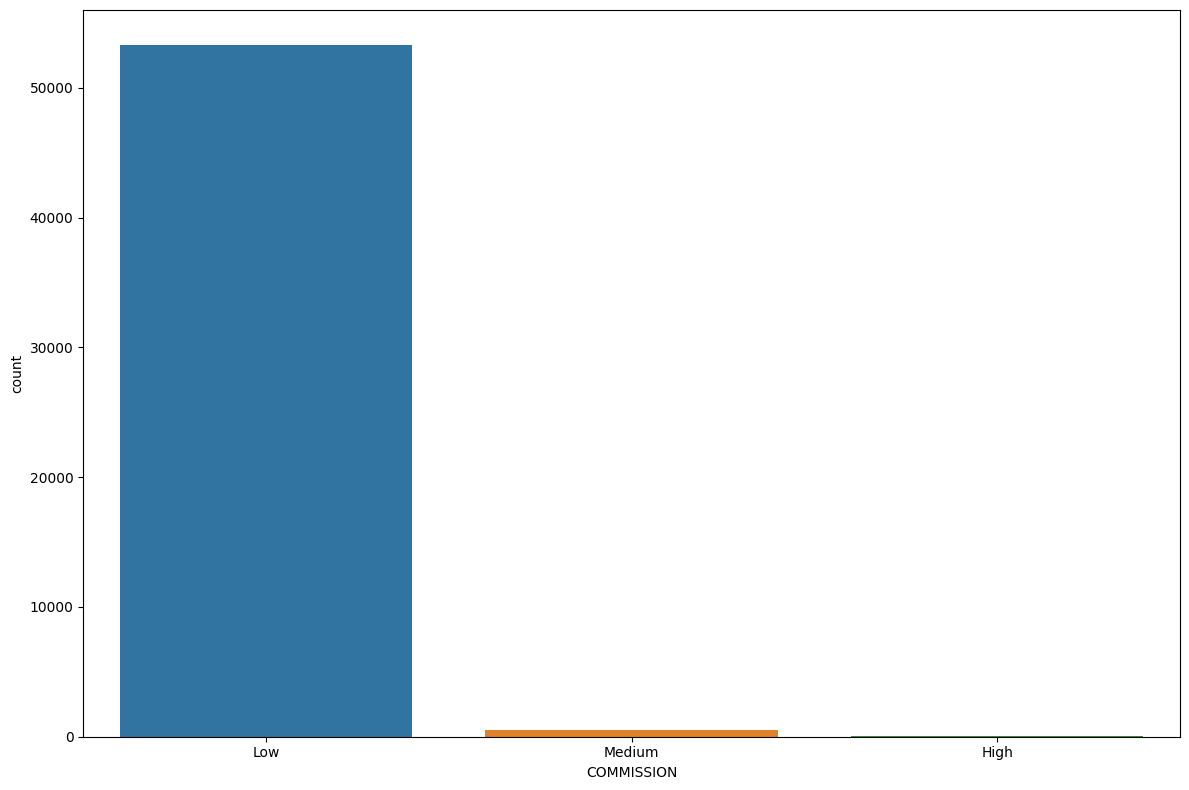

In [36]:
sns.countplot(data=df,x='COMMISSION')
plt.tight_layout();

Almost all the travel insurance agencies receive a low commission rate for providing their insurance services. There are only a minimal number of companies that receive either medium or high commission for their services.

In [37]:
df.COMMISSION = df.COMMISSION.astype(object)
commission_encoder = OrdinalEncoder(categories=[['Low','Medium','High']])
df.COMMISSION = commission_encoder.fit_transform(df[['COMMISSION']])
df.COMMISSION = df.COMMISSION.astype(int)

In [38]:
product_encoder = OneHotEncoder(variables=['PRODUCT_NAME'],drop_last=True)
products_encoded = product_encoder.fit_transform(df[['PRODUCT_NAME']])
products_encoded.head()

PRODUCT_NAME_Bronze Plan  PRODUCT_NAME_Silver Plan  \
0                         1                         0   
1                         1                         0   
2                         1                         0   
3                         0                         1   
4                         0                         0   

   PRODUCT_NAME_Annual Silver Plan  \
0                                0   
1                                0   
2                                0   
3                                0   
4                                1   

   PRODUCT_NAME_Rental Vehicle Excess Insurance  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   PRODUCT_NAME_2 way Comprehensive Plan  PRODUCT_NAME_Cancellation Plan  \
0                                      0                               0   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               0   

   PRODUCT_NAME_1 way Comprehensive Plan  PRODUCT_NAME_Value Plan  \
0                                      0                        0   
1                                      0                        0   
2                                      0                        0   
3                                      0                        0   
4                                      0                        0   

   PRODUCT_NAME_Ticket Protector  PRODUCT_NAME_Basic Plan  ...  \
0                              0                        0  ...   
1                              0                        0  ...   
2                              0                        0  ...   
3                              0                        0  ...   
4                              0                        0  ...   

   PRODUCT_NAME_Single Trip Travel Protect Silver  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   PRODUCT_NAME_Individual Comprehensive Plan  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   PRODUCT_NAME_Spouse or Parents Comprehensive Plan  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   PRODUCT_NAME_Annual Travel Protect Silver  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   PRODUCT_NAME_Single Trip Travel Protect Platinum  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   PRODUCT_NAME_Annual Travel Protect Gold  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   PROD

In [39]:
products_encoded.shape

(53954, 25)

In [40]:
df = pd.concat([df,products_encoded],axis=1)
df.drop('PRODUCT_NAME',axis=1,inplace=True)
df.head()

AGENCY  AGENCY_TYPE  DISTRIBUTION_CHANNEL CLAIM  DURATION DESTINATION  \
0    C2B            0                     1    No    -0.611   SINGAPORE   
1    C2B            0                     1    No    -1.067   SINGAPORE   
2    C2B            0                     1   Yes    -0.611   SINGAPORE   
3    C2B            0                     1    No     1.649   SINGAPORE   
4    C2B            0                     1    No     2.131   SINGAPORE   

   NET_SALES  COMMISSION  GENDER    AGE  ...  \
0      0.417           0       0  0.584  ...   
1     -0.575           0       0 -1.570  ...   
2      1.289           0       1 -0.410  ...   
3      2.024           0       1 -1.423  ...   
4      2.024           1       0 -0.886  ...   

   PRODUCT_NAME_Single Trip Travel Protect Silver  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   PRODUCT_NAME_Individual Comprehensive Plan  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   PRODUCT_NAME_Spouse or Parents Comprehensive Plan  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   PRODUCT_NAME_Annual Travel Protect Silver  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   PRODUCT_NAME_Single Trip Travel Protect Platinum  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   PRODUCT_NAME_Annual Travel Protect Gold  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   PRODUCT_NAME_Single Trip Travel Protect Gold  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   PRODUCT_NAME_Annual Travel Protect Platinum  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

   PRODUCT_NAME_Child Comprehensive Plan  PRODUCT_NAME_Travel Cruise Protect  
0                                      0                                   0  
1                                      0                                   0  
2                                      0                                   0  
3                                      0                                   0  
4                                      0                                   0  

[5 rows x 35 columns]

In [41]:
counts = df.DESTINATION.value_counts()
counts

SINGAPORE                 11455
THAILAND                   5059
MALAYSIA                   4310
CHINA                      3927
AUSTRALIA                  3340
                          ...  
MOLDOVA, REPUBLIC OF          1
GUADELOUPE                    1
NEW CALEDONIA                 1
ARMENIA                       1
BOSNIA AND HERZEGOVINA        1
Name: DESTINATION, Length: 147, dtype: int64

In [42]:
threshold = 1000
remaining_cat = counts[counts <= threshold].index
destinations_encoded = pd.get_dummies(df.DESTINATION.replace(remaining_cat,'Uncommon'),drop_first=True,dtype=int,sparse=False)
destinations_encoded.sample(10)

CHINA  HONG KONG  INDIA  INDONESIA  JAPAN  KOREA, REPUBLIC OF  \
57680      1          0      0          0      0                   0   
55595      0          0      0          0      0                   0   
31149      0          0      0          0      0                   0   
1840       0          0      0          1      0                   0   
60436      0          0      0          0      0                   0   
6702       0          0      0          0      0                   0   
48796      0          0      0          0      0                   0   
57923      1          0      0          0      0                   0   
50271      0          0      1          0      0                   0   
24422      0          0      0          0      0                   0   

       MALAYSIA  PHILIPPINES  SINGAPORE  TAIWAN, PROVINCE OF CHINA  THAILAND  \
57680         0            0          0                          0         0   
55595         0            0          0                          0         0   
31149         0            0          0                          0         0   
1840          0            0          0                          0         0   
60436         0            0          0                          0         1   
6702          0            0          0                          0         0   
48796         0            0          1                          0         0   
57923         0            0          0                          0         0   
50271         0            0          0                          0         0   
24422         0            1          0                          0         0   

       UNITED KINGDOM  UNITED STATES  Uncommon  VIET NAM  
57680               0              0         0         0  
55595               0              1         0         0  
31149               0              1         0         0  
1840                0              0         0         0  
60436               0              0         0         0  
6702                0              0         1         0  
48796               0              0         0         0  
57923               0              0         0         0  
50271               0              0         0         0  
24422               0              0         0         0

In [43]:
destinations_encoded.shape

(53954, 15)

In [44]:
df = pd.concat([df,destinations_encoded],axis=1)
df.drop('DESTINATION',axis=1,inplace=True)
df.head()

AGENCY  AGENCY_TYPE  DISTRIBUTION_CHANNEL CLAIM  DURATION  NET_SALES  \
0    C2B            0                     1    No    -0.611      0.417   
1    C2B            0                     1    No    -1.067     -0.575   
2    C2B            0                     1   Yes    -0.611      1.289   
3    C2B            0                     1    No     1.649      2.024   
4    C2B            0                     1    No     2.131      2.024   

   COMMISSION  GENDER    AGE  PRODUCT_NAME_Bronze Plan  ...  \
0           0       0  0.584                         1  ...   
1           0       0 -1.570                         1  ...   
2           0       1 -0.410                         1  ...   
3           0       1 -1.423                         0  ...   
4           1       0 -0.886                         0  ...   

   KOREA, REPUBLIC OF  MALAYSIA  PHILIPPINES  SINGAPORE  \
0                   0         0            0          1   
1                   0         0            0          1   
2                   0         0            0          1   
3                   0         0            0          1   
4                   0         0            0          1   

   TAIWAN, PROVINCE OF CHINA  THAILAND  UNITED KINGDOM  UNITED STATES  \
0                          0         0               0              0   
1                          0         0               0              0   
2                          0         0               0              0   
3                          0         0               0              0   
4                          0         0               0              0   

   Uncommon  VIET NAM  
0         0         0  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

[5 rows x 49 columns]

In [45]:
agency_encoder = OneHotEncoder(variables=['AGENCY'],drop_last=True)
agencies_encoded = agency_encoder.fit_transform(df[['AGENCY']])
agencies_encoded.sample(10)

AGENCY_C2B  AGENCY_CWT  AGENCY_EPX  AGENCY_RAB  AGENCY_SSI  AGENCY_JZI  \
30420           0           0           1           0           0           0   
26355           0           0           1           0           0           0   
29567           0           0           0           0           0           1   
57442           0           0           1           0           0           0   
33716           0           0           0           0           1           0   
44961           0           0           1           0           0           0   
611             0           0           1           0           0           0   
22771           1           0           0           0           0           0   
4509            0           0           1           0           0           0   
55088           0           0           1           0           0           0   

       AGENCY_ART  AGENCY_CSR  AGENCY_CBH  AGENCY_KML  AGENCY_CCR  AGENCY_ADM  \
30420           0           0           0           0           0           0   
26355           0           0           0           0           0           0   
29567           0           0           0           0           0           0   
57442           0           0           0           0           0           0   
33716           0           0           0           0           0           0   
44961           0           0           0           0           0           0   
611             0           0           0           0           0           0   
22771           0           0           0           0           0           0   
4509            0           0           0           0           0           0   
55088           0           0           0           0           0           0   

       AGENCY_LWC  AGENCY_TTW  
30420           0           0  
26355           0           0  
29567           0           0  
57442           0           0  
33716           0           0  
44961           0           0  
611             0           0  
22771           0           0  
4509            0           0  
55088           0           0

In [46]:
df = pd.concat([df,agencies_encoded],axis=1)
df.drop('AGENCY',axis=1,inplace=True)
df.head()

AGENCY_TYPE  DISTRIBUTION_CHANNEL CLAIM  DURATION  NET_SALES  COMMISSION  \
0            0                     1    No    -0.611      0.417           0   
1            0                     1    No    -1.067     -0.575           0   
2            0                     1   Yes    -0.611      1.289           0   
3            0                     1    No     1.649      2.024           0   
4            0                     1    No     2.131      2.024           1   

   GENDER    AGE  PRODUCT_NAME_Bronze Plan  PRODUCT_NAME_Silver Plan  ...  \
0       0  0.584                         1                         0  ...   
1       0 -1.570                         1                         0  ...   
2       1 -0.410                         1                         0  ...   
3       1 -1.423                         0                         1  ...   
4       0 -0.886                         0                         0  ...   

   AGENCY_SSI  AGENCY_JZI  AGENCY_ART  AGENCY_CSR  AGENCY_CBH  AGENCY_KML  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   AGENCY_CCR  AGENCY_ADM  AGENCY_LWC  AGENCY_TTW  
0           0           0           0           0  
1           0           0           0           0  
2           0           0           0           0  
3           0           0           0           0  
4           0           0           0           0  

[5 rows x 62 columns]

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53954 entries, 0 to 61676
Data columns (total 62 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   AGENCY_TYPE                                        53954 non-null  int32  
 1   DISTRIBUTION_CHANNEL                               53954 non-null  int32  
 2   CLAIM                                              53954 non-null  object 
 3   DURATION                                           53954 non-null  float64
 4   NET_SALES                                          53954 non-null  float64
 5   COMMISSION                                         53954 non-null  int32  
 6   GENDER                                             53954 non-null  int32  
 7   AGE                                                53954 non-null  float64
 8   PRODUCT_NAME_Bronze Plan                           53954 non-null  int32  
 9   PRODUC

### Feature Splitting

In [48]:
X = df.drop('CLAIM',axis=1)
y = df.CLAIM

### Balancing the imbalanced class labels of the target feature "Claim" using Synthetic Minority Oversampling TEchnique(SMOTE)

In [49]:
oversampler = SMOTE()
X, y = oversampler.fit_resample(X, y)

In [50]:
print("Distribution of class in target variable y(Claim):",Counter(y))

Distribution of class in target variable y(Claim): Counter({'No': 53046, 'Yes': 53046})


In [51]:
y.value_counts()

No     53046
Yes    53046
Name: CLAIM, dtype: int64

In [52]:
print("New shape of the dataset:",X.shape)

New shape of the dataset: (106092, 61)


### Dividing the dataset into training and test sets

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,shuffle=True,random_state=101)

### Feature Selection

In [54]:
kbest = SelectKBest(k=10,score_func=f_classif)
kbest.fit(X_train,y_train)

SelectKBest()

In [55]:
selected_features = kbest.get_feature_names_out()
selected_features

array(['AGENCY_TYPE', 'DURATION', 'NET_SALES', 'GENDER',
       'PRODUCT_NAME_Bronze Plan', 'PRODUCT_NAME_Annual Silver Plan',
       'PRODUCT_NAME_Cancellation Plan', 'SINGAPORE', 'AGENCY_C2B',
       'AGENCY_EPX'], dtype=object)

In [56]:
percentile = SelectPercentile(percentile=20,score_func=f_classif)
percentile.fit(X_train,y_train)

SelectPercentile(percentile=20)

In [57]:
selected_features = percentile.get_feature_names_out()
selected_features

array(['AGENCY_TYPE', 'DURATION', 'NET_SALES', 'GENDER',
       'PRODUCT_NAME_Bronze Plan', 'PRODUCT_NAME_Silver Plan',
       'PRODUCT_NAME_Annual Silver Plan',
       'PRODUCT_NAME_Cancellation Plan', 'MALAYSIA', 'SINGAPORE',
       'AGENCY_C2B', 'AGENCY_EPX'], dtype=object)

In [58]:
sfm = SelectFromModel(estimator=RandomForestClassifier(),max_features=10,threshold='1.25*mean')
sfm.fit(X_train,y_train)

SelectFromModel(estimator=RandomForestClassifier(), max_features=10,
                threshold='1.25*mean')

In [59]:
selected_features = sfm.get_feature_names_out()
selected_features

array(['AGENCY_TYPE', 'DURATION', 'NET_SALES', 'AGE',
       'PRODUCT_NAME_Cancellation Plan', 'SINGAPORE', 'AGENCY_C2B',
       'AGENCY_EPX'], dtype=object)

In [60]:
rfe = RFE(estimator=RandomForestClassifier(),n_features_to_select=10,step=4,verbose=2)
rfe.fit(X_train,y_train)

Fitting estimator with 61 features.
Fitting estimator with 57 features.
Fitting estimator with 53 features.
Fitting estimator with 49 features.
Fitting estimator with 45 features.
Fitting estimator with 41 features.
Fitting estimator with 37 features.
Fitting estimator with 33 features.
Fitting estimator with 29 features.
Fitting estimator with 25 features.
Fitting estimator with 21 features.
Fitting estimator with 17 features.
Fitting estimator with 13 features.


RFE(estimator=RandomForestClassifier(), n_features_to_select=10, step=4,
    verbose=2)

In [61]:
selected_features = rfe.get_feature_names_out()
selected_features

array(['AGENCY_TYPE', 'DURATION', 'NET_SALES', 'GENDER', 'AGE',
       'PRODUCT_NAME_2 way Comprehensive Plan',
       'PRODUCT_NAME_Cancellation Plan', 'SINGAPORE', 'AGENCY_C2B',
       'AGENCY_EPX'], dtype=object)

In [62]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

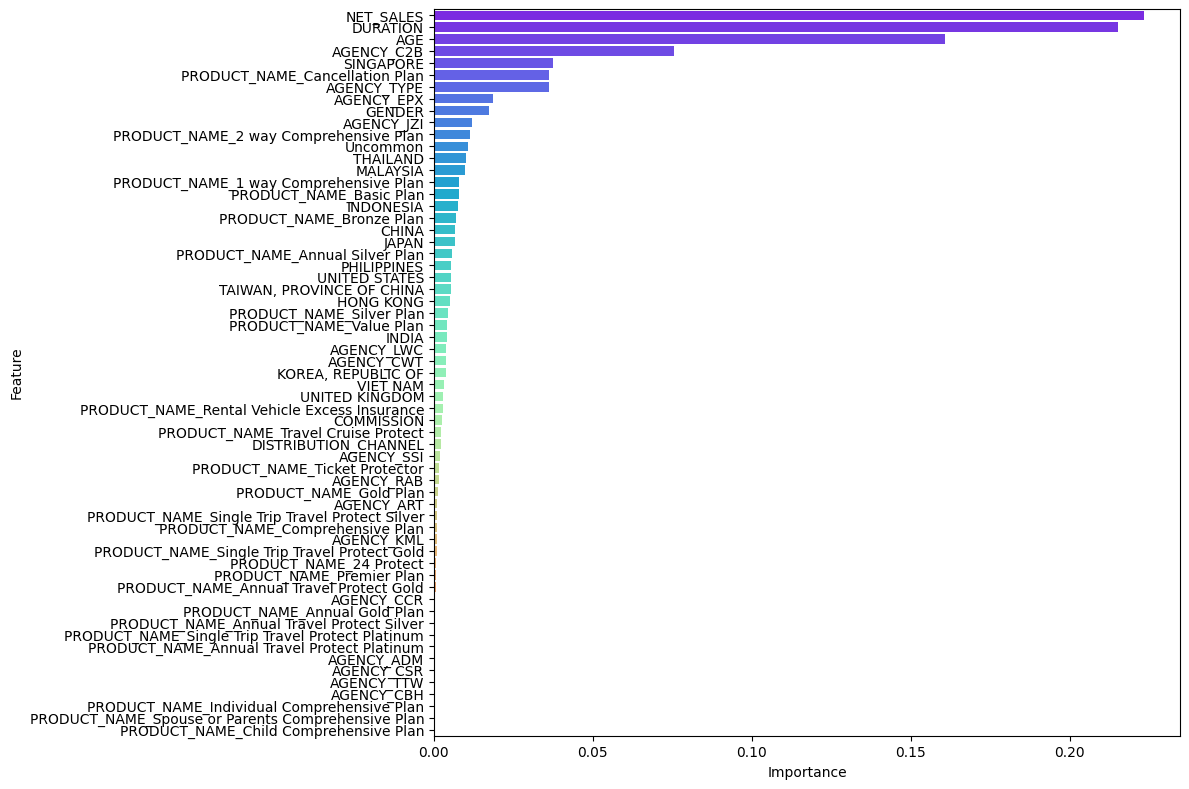

In [63]:
feat_imps = pd.DataFrame(list(zip(X_train.columns,rf.feature_importances_)),columns=['Feature','Importance']).sort_values('Importance',ascending=False).reset_index(drop=True)
sns.barplot(x=feat_imps['Importance'],y=feat_imps['Feature'],orient='horizontal',palette='rainbow')
plt.tight_layout();

In [64]:
final_selected_features = ['DURATION','AGE','NET_SALES','GENDER','AGENCY_TYPE','COMMISSION','AGENCY_C2B','SINGAPORE','PRODUCT_NAME_Bronze Plan',
       'PRODUCT_NAME_Silver Plan','PRODUCT_NAME_Annual Silver Plan','PRODUCT_NAME_Cancellation Plan','AGENCY_EPX']
final_X_train = X_train[final_selected_features]
final_X_test = X_test[final_selected_features]

### Feature Scaling

In [65]:
scaler = StandardScaler()
features = final_X_train.columns
final_X_train = scaler.fit_transform(final_X_train)
final_X_train = pd.DataFrame(final_X_train,columns=features)
final_X_test = scaler.transform(final_X_test)
final_X_test = pd.DataFrame(final_X_test,columns=features)
final_X_train.head()

DURATION    AGE  NET_SALES  GENDER  AGENCY_TYPE  COMMISSION  AGENCY_C2B  \
0     0.466 -1.575      1.213  -1.627       -1.078      -0.138       1.315   
1    -0.654 -0.113     -0.091   0.615        0.927      -0.138      -0.761   
2     0.169 -0.113     -0.150   0.615        0.927      -0.138      -0.761   
3     0.184  2.187     -0.782  -1.627       -1.078      -0.138      -0.761   
4     0.212  1.043     -0.485   0.615        0.927      -0.138      -0.761   

   SINGAPORE  PRODUCT_NAME_Bronze Plan  PRODUCT_NAME_Silver Plan  \
0      1.206                    -0.416                     3.046   
1     -0.829                    -0.416                    -0.328   
2     -0.829                    -0.416                    -0.328   
3     -0.829                    -0.416                    -0.328   
4     -0.829                    -0.416                    -0.328   

   PRODUCT_NAME_Annual Silver Plan  PRODUCT_NAME_Cancellation Plan  AGENCY_EPX  
0                           -0.323                          -0.444      -0.769  
1                           -0.323                          -0.444       1.300  
2                           -0.323                          -0.444       1.300  
3                           -0.323                          -0.444      -0.769  
4                           -0.323                          -0.444      -0.769

### Label Encoding

In [66]:
target_encoder = LabelEncoder()
y_train_tf = target_encoder.fit_transform(y_train)
y_test_tf = target_encoder.transform(y_test)

## Model Training & Evaluation

In [67]:
model_names = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

In [68]:
def train_and_evaluate_model(model):
    model.fit(final_X_train,y_train_tf)
    y_pred = model.predict(final_X_test)
    print(classification_report(y_test_tf, y_pred))
    accuracy = accuracy_score(y_test_tf,y_pred)
    precision = precision_score(y_test_tf,y_pred)
    recall = recall_score(y_test_tf,y_pred)
    f1 = f1_score(y_test_tf,y_pred)
    roc_auc = roc_auc_score(y_test_tf,y_pred)
    print("Accuracy Score:",accuracy)
    print("Precision Score:",precision)
    print("Recall Score:",recall)
    print("F1 Score:",f1)
    print("ROC AUC Score:",roc_auc)
    ConfusionMatrixDisplay.from_predictions(y_test_tf,y_pred)
    plt.show()
    PrecisionRecallDisplay.from_predictions(y_test_tf,y_pred)
    plt.show()
    model_names.append(str(model))
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

              precision    recall  f1-score   support

           0       0.74      0.78      0.76     15917
           1       0.76      0.73      0.74     15911

    accuracy                           0.75     31828
   macro avg       0.75      0.75      0.75     31828
weighted avg       0.75      0.75      0.75     31828

Accuracy Score: 0.7510682417996732
Precision Score: 0.7640486579399709
Recall Score: 0.7263528376594809
F1 Score: 0.744724039050166
ROC AUC Score: 0.7510635834964491


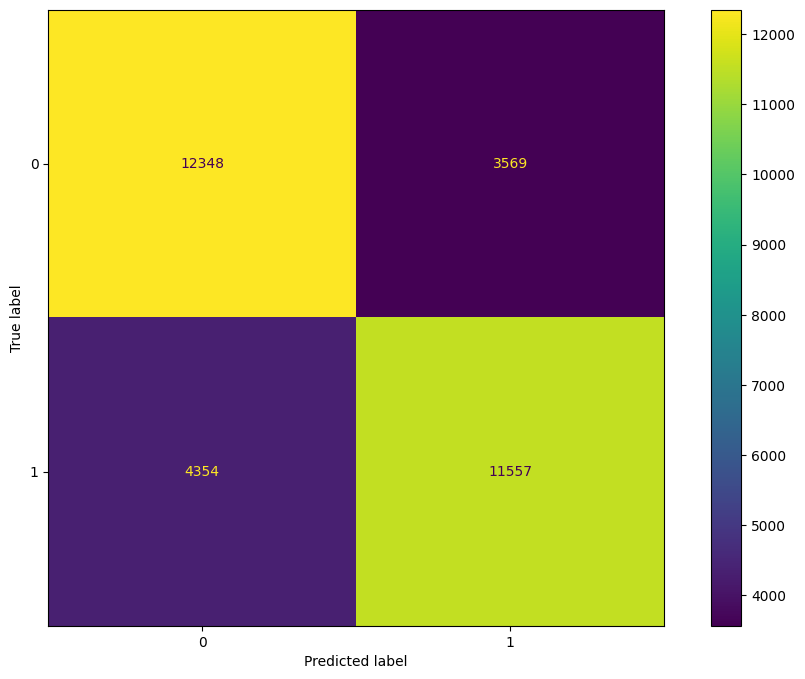

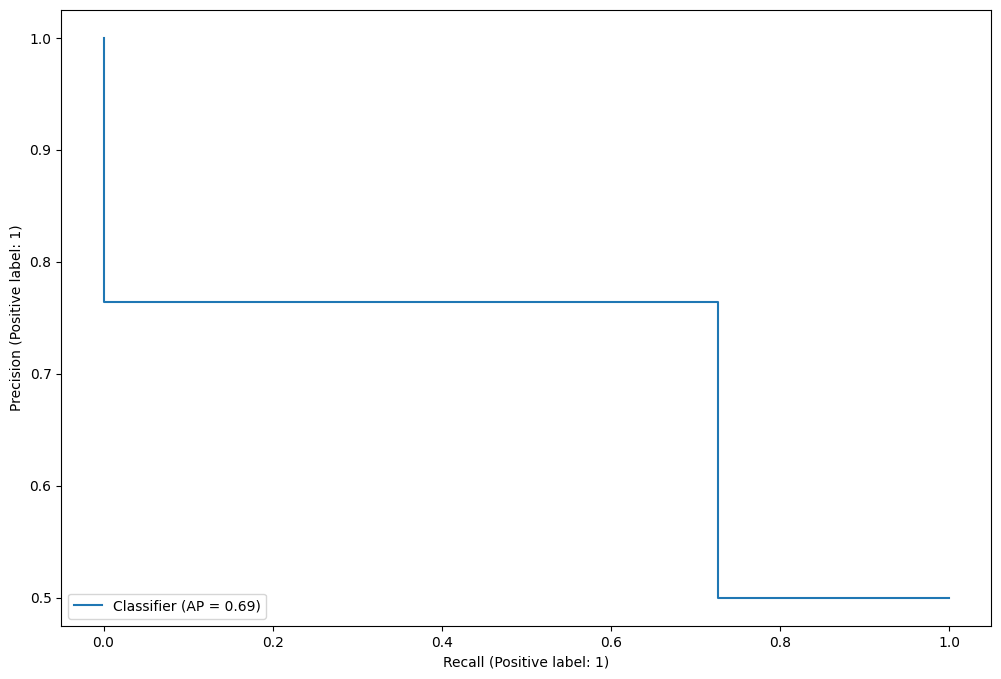

In [69]:
train_and_evaluate_model(LogisticRegression())

              precision    recall  f1-score   support

           0       0.57      0.62      0.59     15917
           1       0.58      0.54      0.56     15911

    accuracy                           0.58     31828
   macro avg       0.58      0.58      0.58     31828
weighted avg       0.58      0.58      0.58     31828

Accuracy Score: 0.5773532738469273
Precision Score: 0.5837477011102786
Recall Score: 0.5386210797561436
F1 Score: 0.5602771966527197
ROC AUC Score: 0.5773459736909762


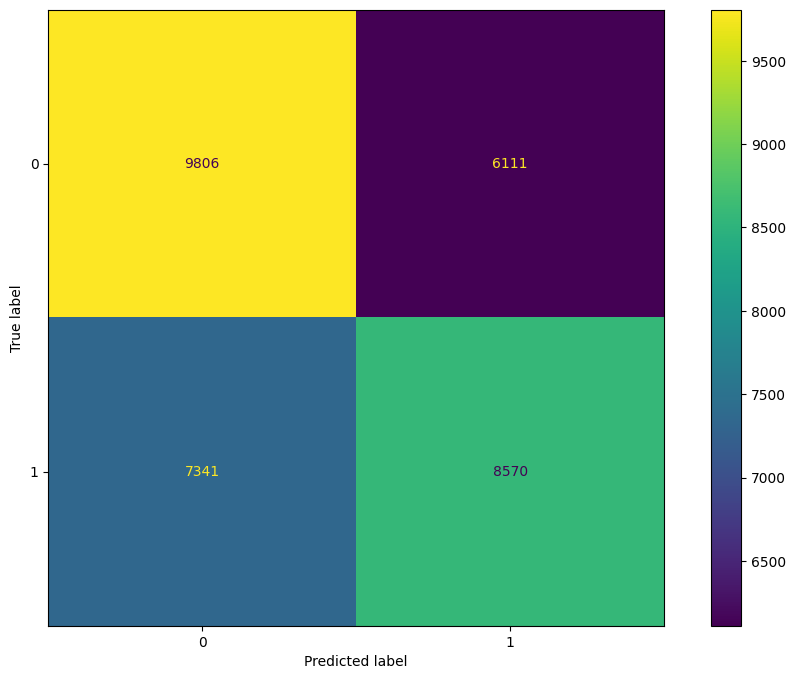

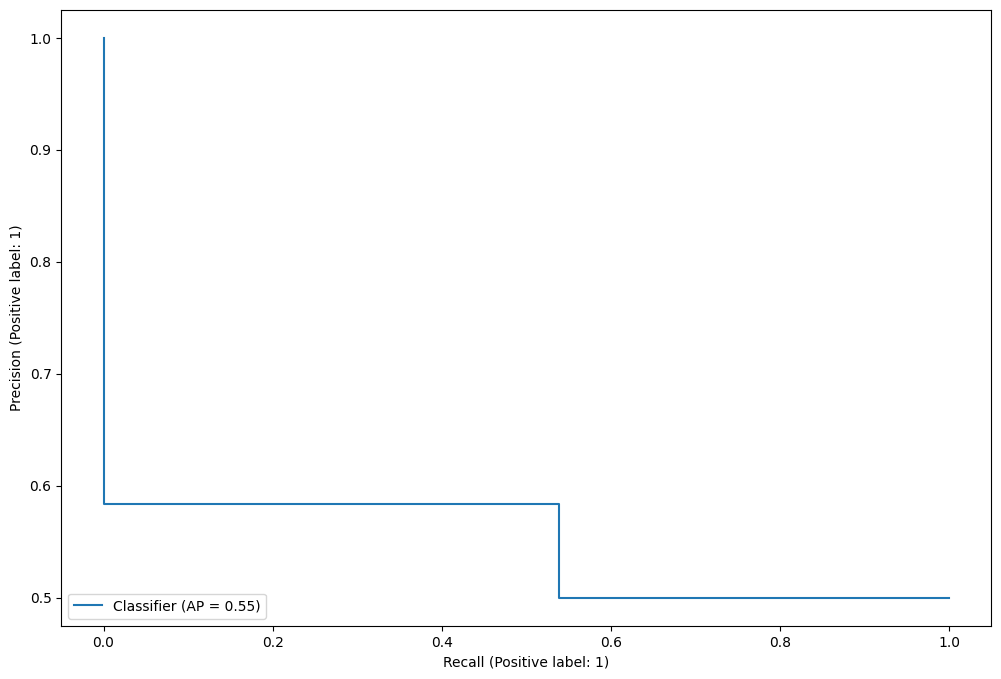

In [70]:
train_and_evaluate_model(PassiveAggressiveClassifier())

              precision    recall  f1-score   support

           0       0.70      0.86      0.77     15917
           1       0.81      0.63      0.71     15911

    accuracy                           0.74     31828
   macro avg       0.75      0.74      0.74     31828
weighted avg       0.75      0.74      0.74     31828

Accuracy Score: 0.7406685936910896
Precision Score: 0.8120466215665498
Recall Score: 0.6261705738168563
F1 Score: 0.7070972320794889
ROC AUC Score: 0.7406470133644186


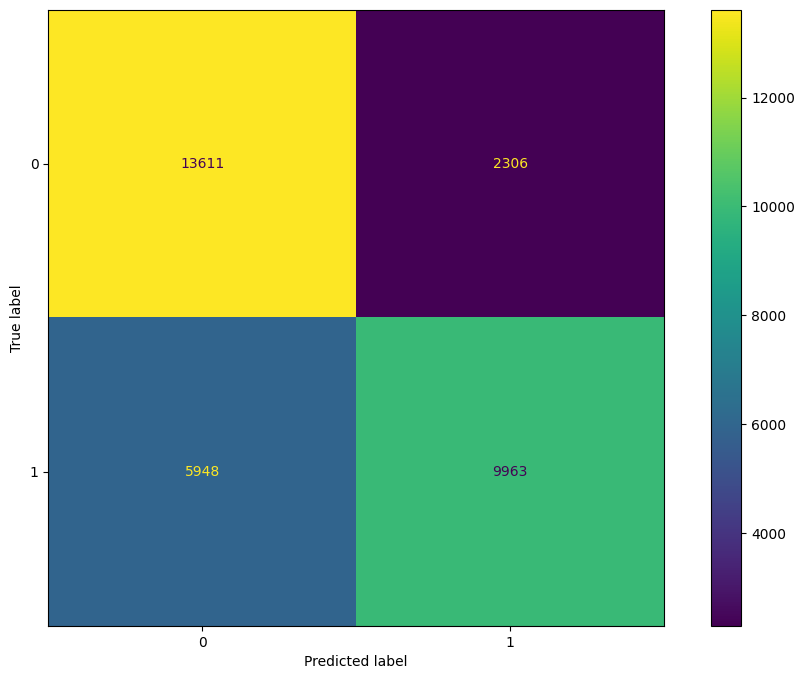

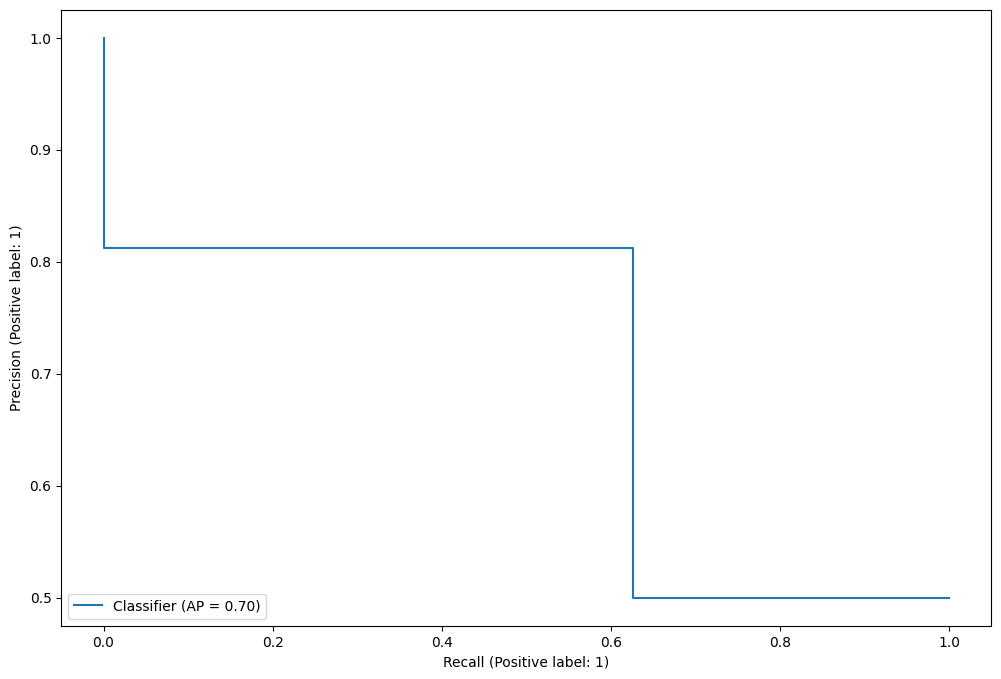

In [71]:
train_and_evaluate_model(SGDClassifier())

              precision    recall  f1-score   support

           0       0.73      0.80      0.76     15917
           1       0.77      0.70      0.74     15911

    accuracy                           0.75     31828
   macro avg       0.75      0.75      0.75     31828
weighted avg       0.75      0.75      0.75     31828

Accuracy Score: 0.7483347995475682
Precision Score: 0.7746263468891206
Recall Score: 0.7003331028847967
F1 Score: 0.7356086612094006
ROC AUC Score: 0.7483257522968307


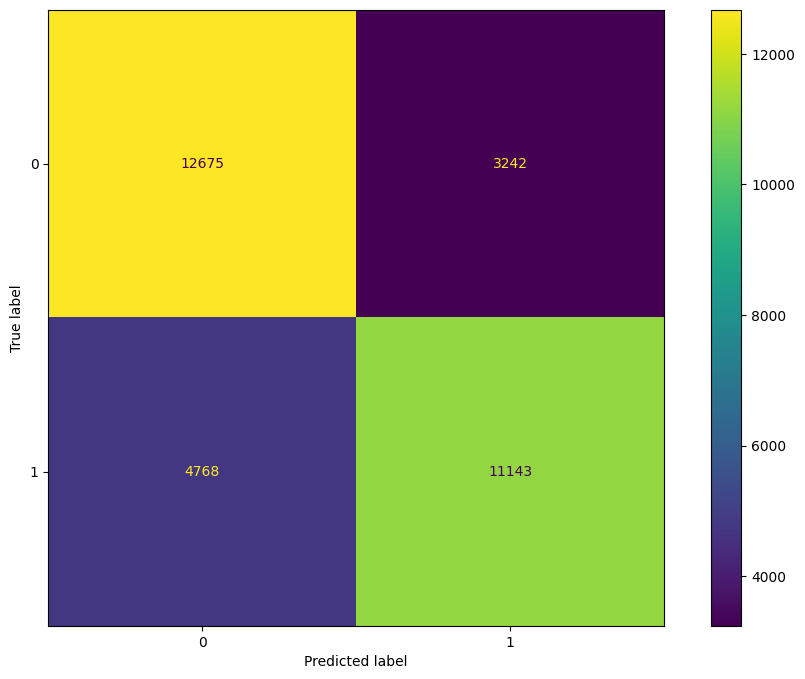

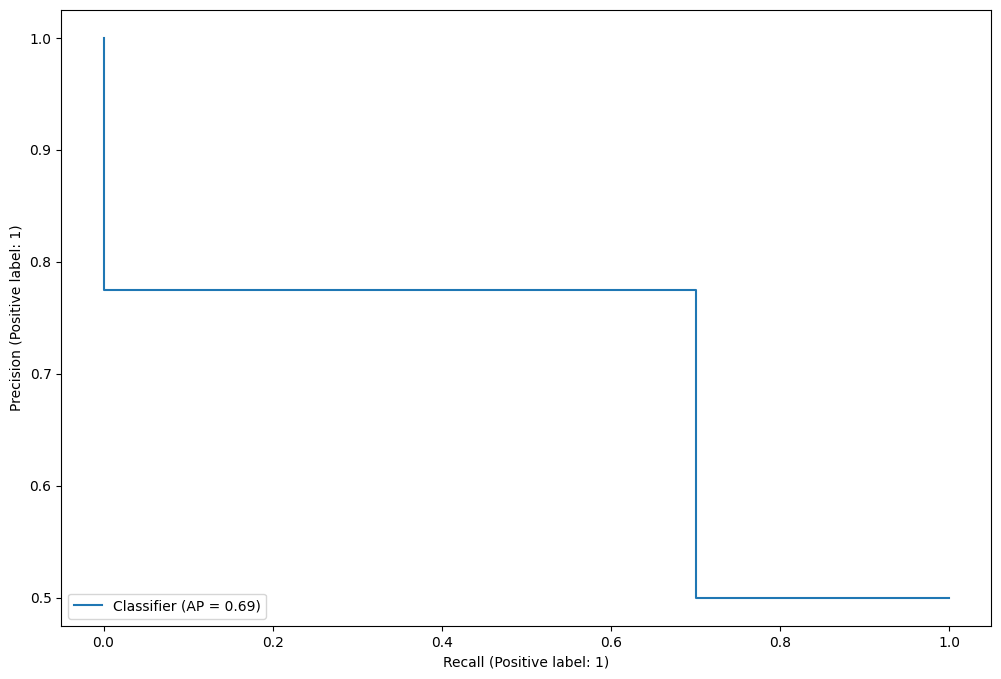

In [72]:
train_and_evaluate_model(RidgeClassifier())

              precision    recall  f1-score   support

           0       0.92      0.83      0.87     15917
           1       0.84      0.93      0.88     15911

    accuracy                           0.88     31828
   macro avg       0.88      0.88      0.88     31828
weighted avg       0.88      0.88      0.88     31828

Accuracy Score: 0.8780947593314063
Precision Score: 0.8432524964336662
Recall Score: 0.9287914021745962
F1 Score: 0.8839574111735853
ROC AUC Score: 0.8781043145194777


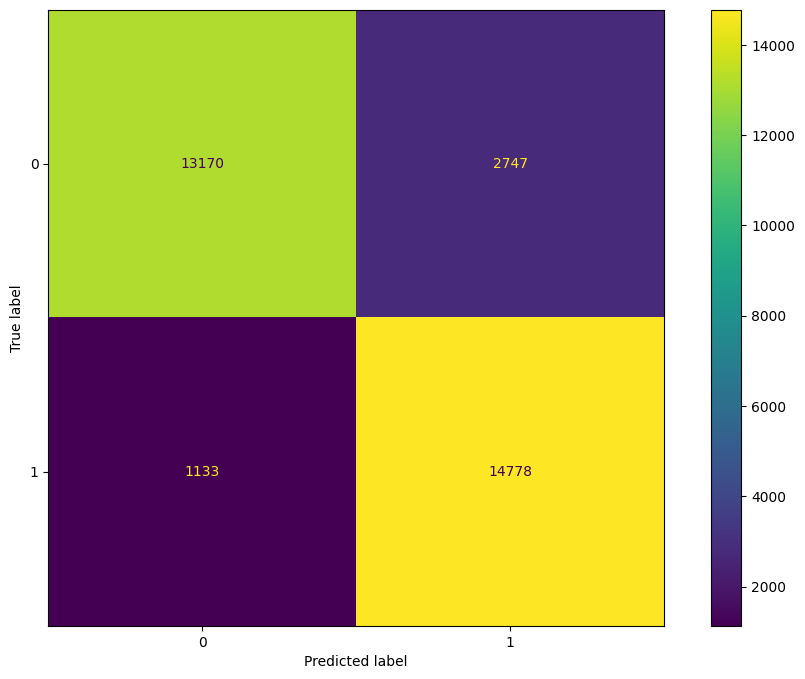

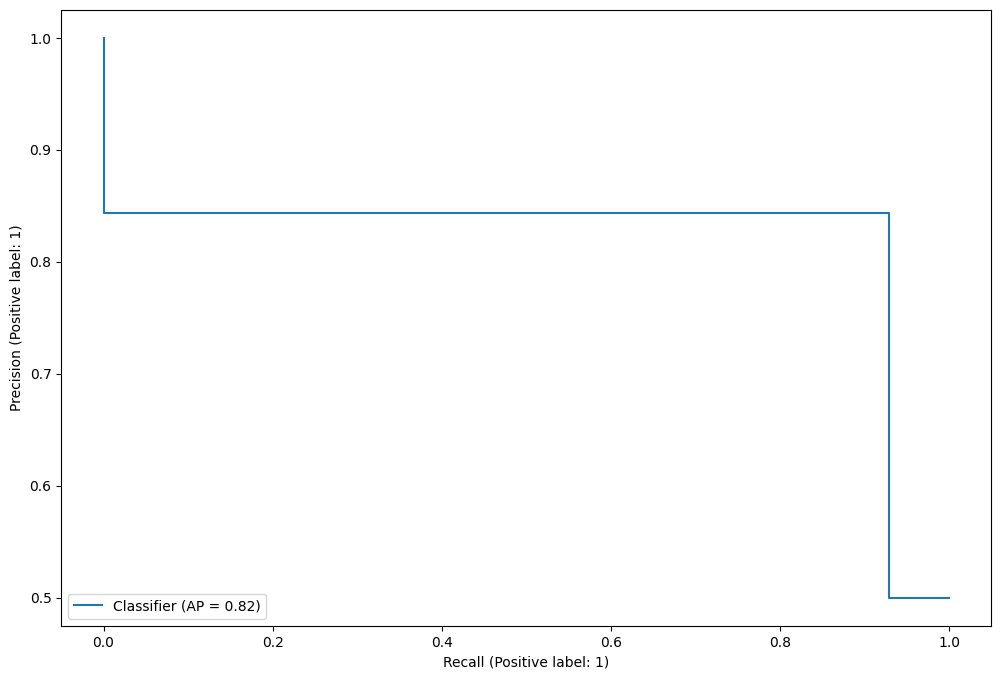

In [73]:
train_and_evaluate_model(KNeighborsClassifier())

              precision    recall  f1-score   support

           0       0.73      0.80      0.76     15917
           1       0.77      0.70      0.74     15911

    accuracy                           0.75     31828
   macro avg       0.75      0.75      0.75     31828
weighted avg       0.75      0.75      0.75     31828

Accuracy Score: 0.7483662184240292
Precision Score: 0.774222654081066
Recall Score: 0.7010872980956571
F1 Score: 0.7358422111547215
ROC AUC Score: 0.7483573074005332


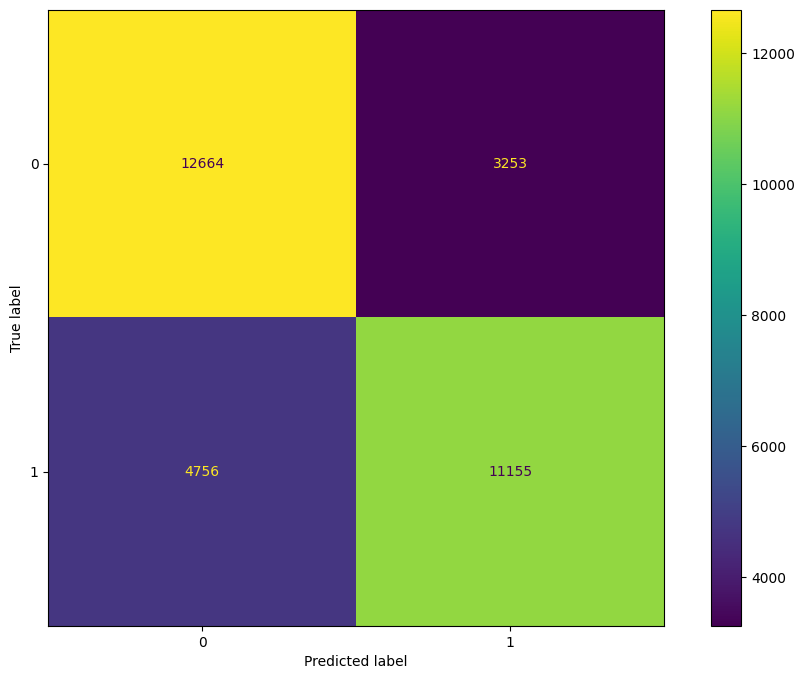

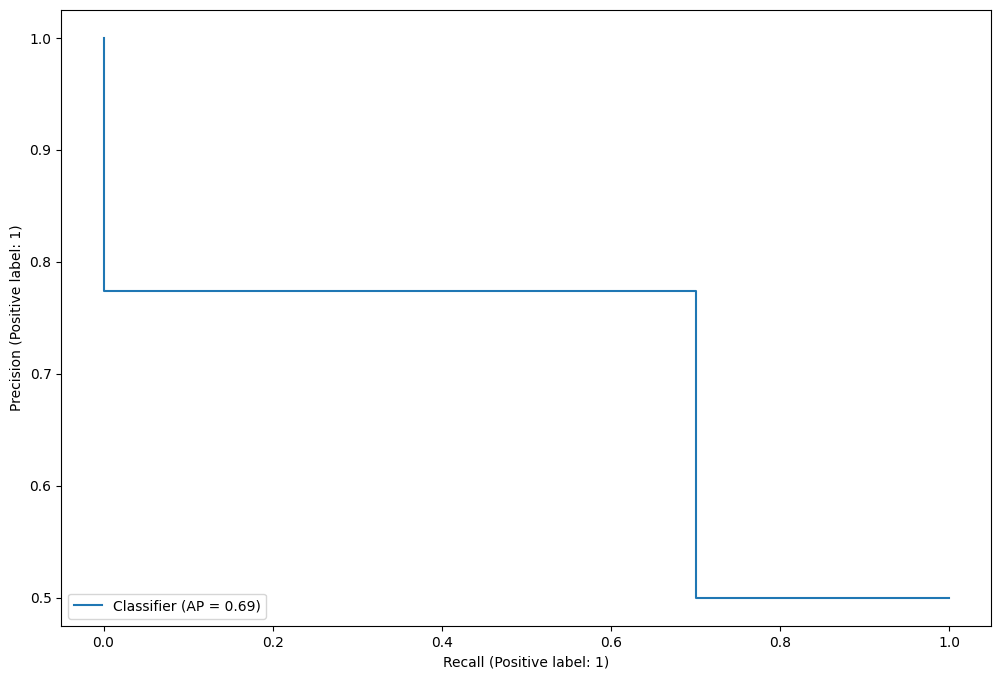

In [74]:
train_and_evaluate_model(LinearSVC())

              precision    recall  f1-score   support

           0       0.70      0.85      0.77     15917
           1       0.81      0.64      0.71     15911

    accuracy                           0.74     31828
   macro avg       0.75      0.74      0.74     31828
weighted avg       0.75      0.74      0.74     31828

Accuracy Score: 0.7425223074022873
Precision Score: 0.8083932853717026
Recall Score: 0.6355980139526114
F1 Score: 0.7116568734386546
ROC AUC Score: 0.7425021545543669


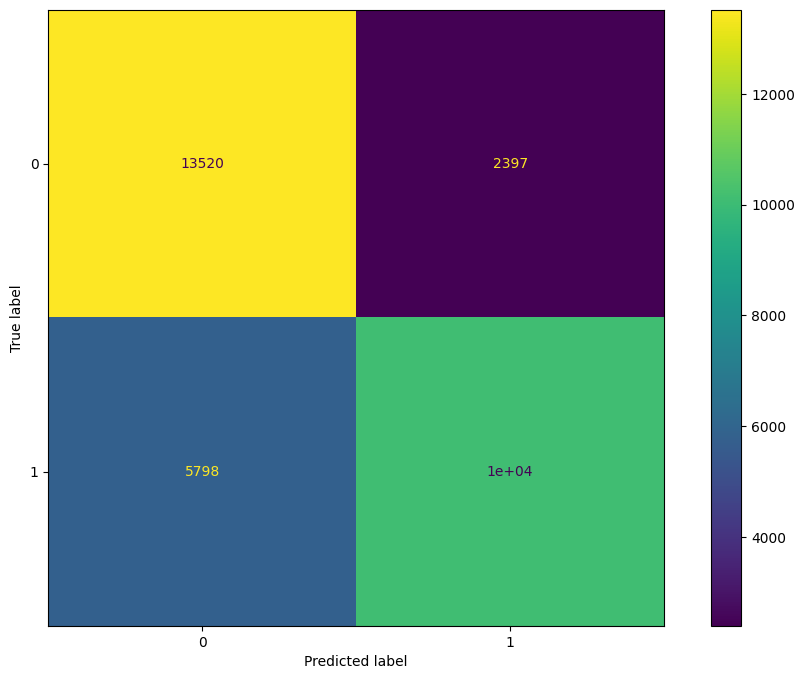

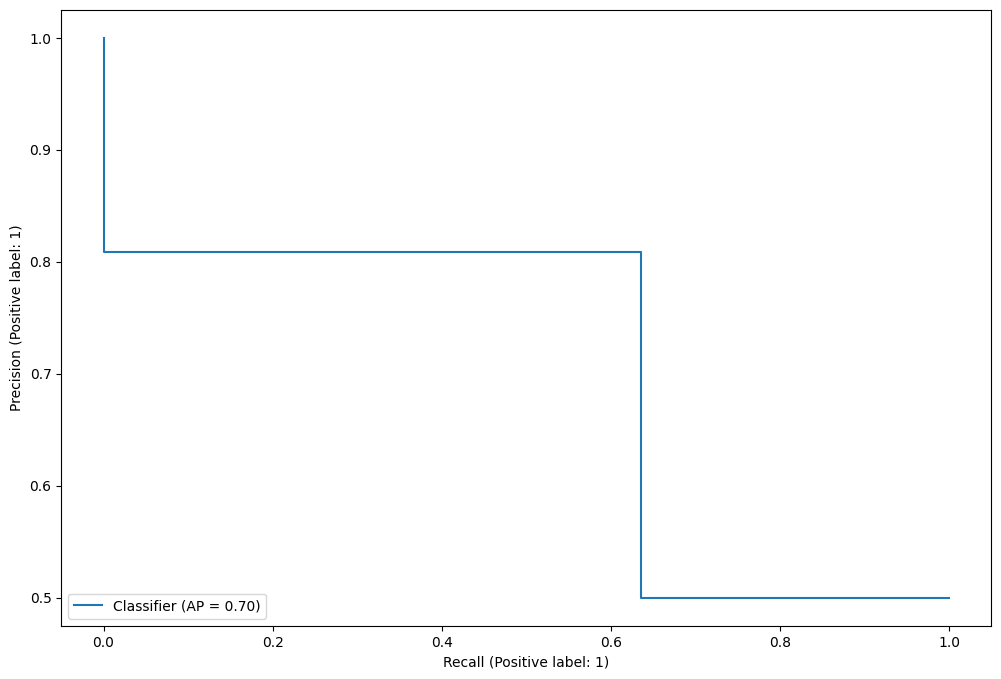

In [75]:
train_and_evaluate_model(GaussianNB())

              precision    recall  f1-score   support

           0       0.70      0.81      0.75     15917
           1       0.77      0.65      0.70     15911

    accuracy                           0.73     31828
   macro avg       0.73      0.73      0.73     31828
weighted avg       0.73      0.73      0.73     31828

Accuracy Score: 0.7285409073771522
Precision Score: 0.7732431416760617
Recall Score: 0.6465966941109924
F1 Score: 0.7042716319824753
ROC AUC Score: 0.7285254627179955


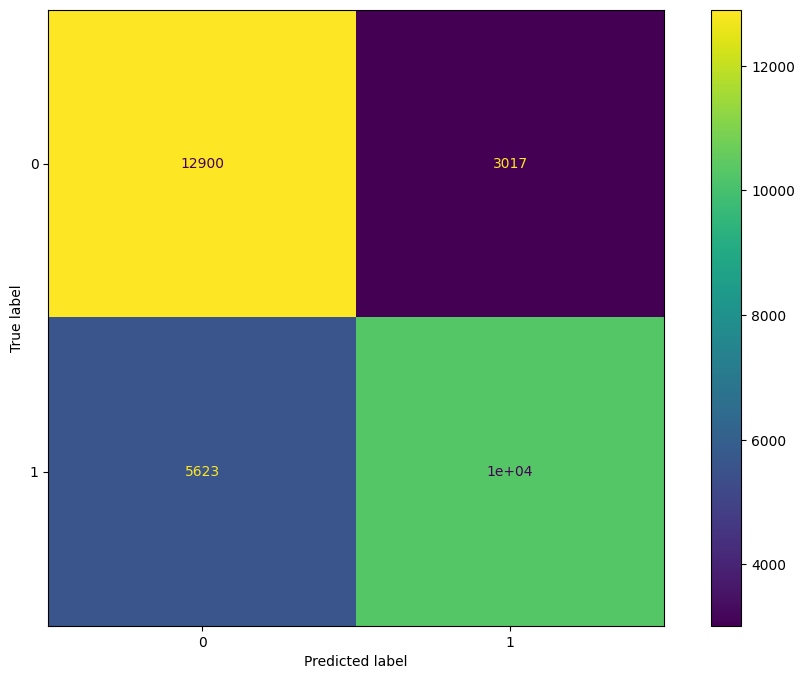

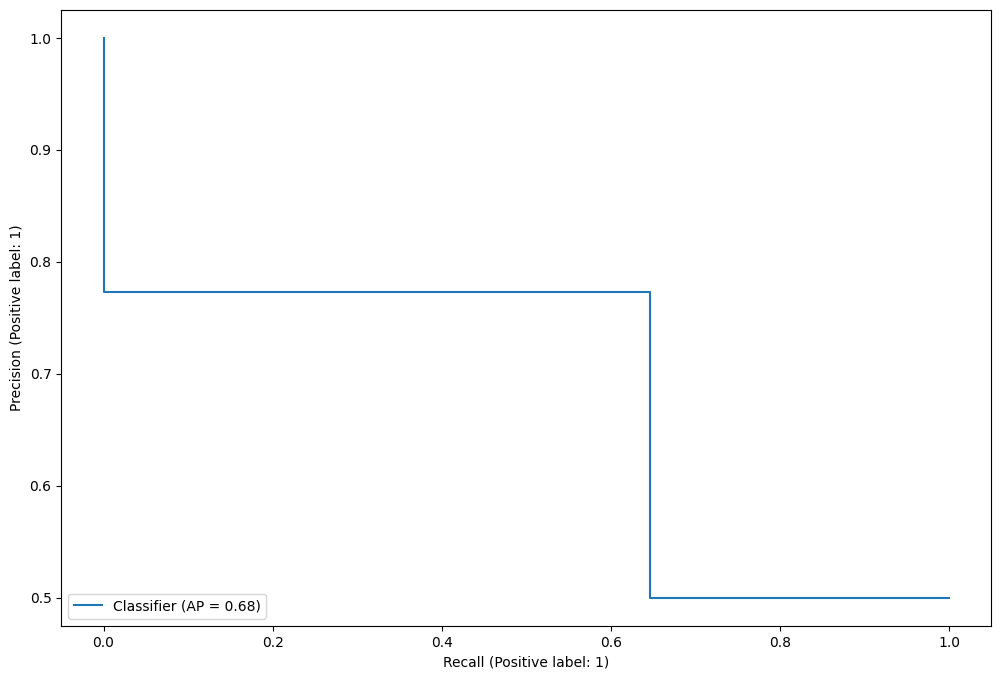

In [76]:
train_and_evaluate_model(BernoulliNB())

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     15917
           1       0.95      0.94      0.95     15911

    accuracy                           0.95     31828
   macro avg       0.95      0.95      0.95     31828
weighted avg       0.95      0.95      0.95     31828

Accuracy Score: 0.9451112228226719
Precision Score: 0.9455208857574232
Recall Score: 0.9446295016026648
F1 Score: 0.9450749834941994
ROC AUC Score: 0.9451111320289506


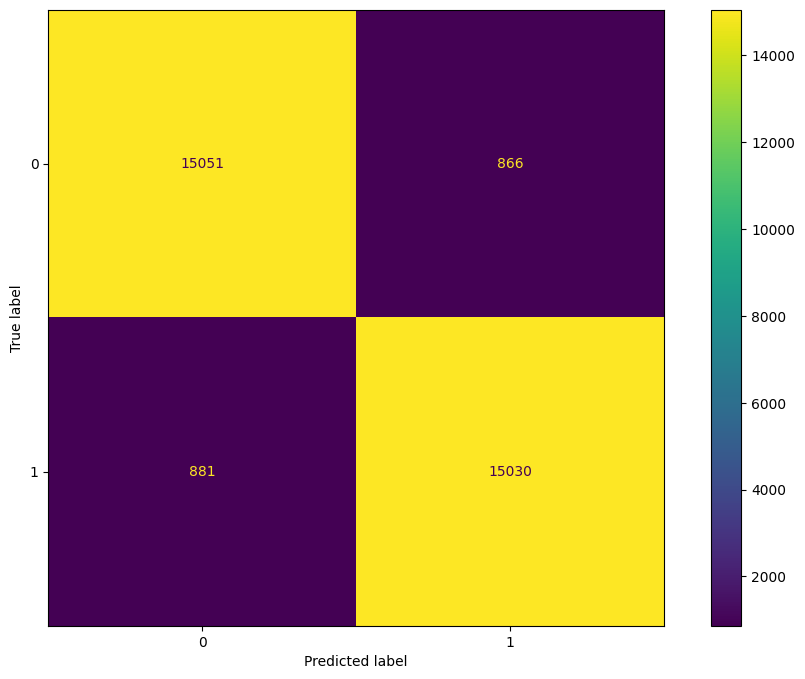

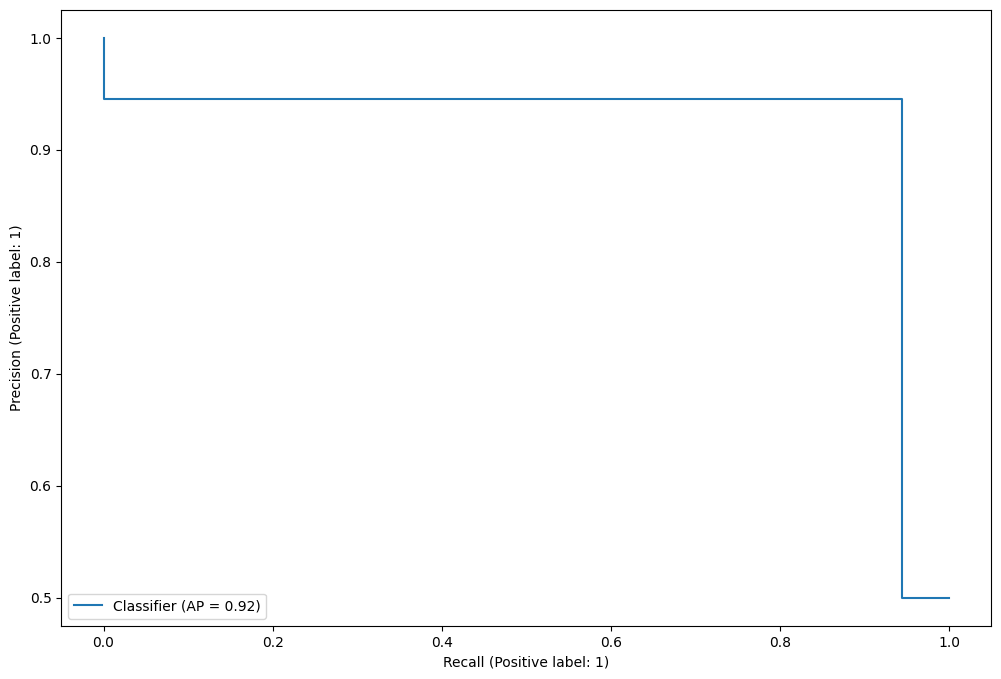

In [77]:
train_and_evaluate_model(DecisionTreeClassifier())

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     15917
           1       0.95      0.96      0.96     15911

    accuracy                           0.96     31828
   macro avg       0.96      0.96      0.96     31828
weighted avg       0.96      0.96      0.96     31828

Accuracy Score: 0.9550710066608018
Precision Score: 0.9543771572011296
Recall Score: 0.9558167305637609
F1 Score: 0.955096401431891
ROC AUC Score: 0.9550711472131489


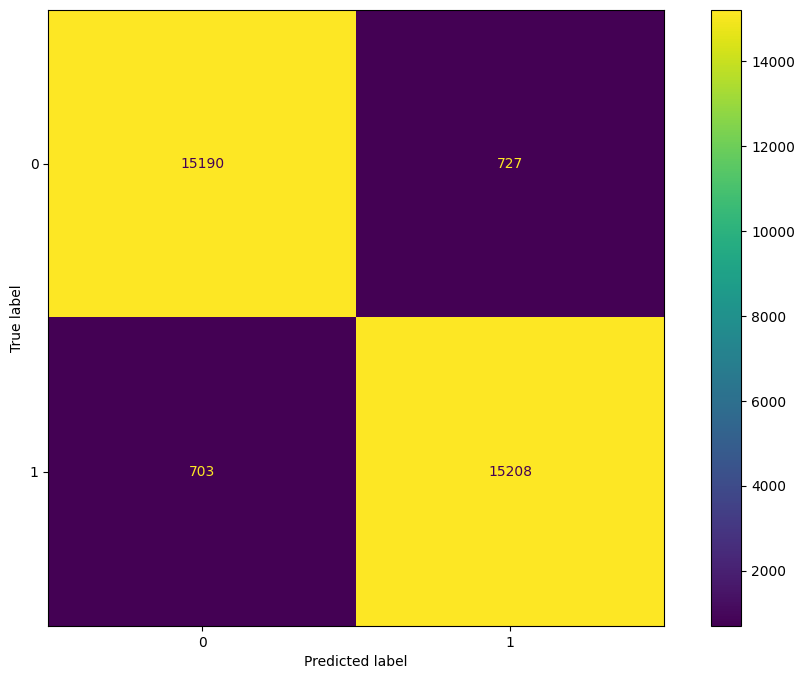

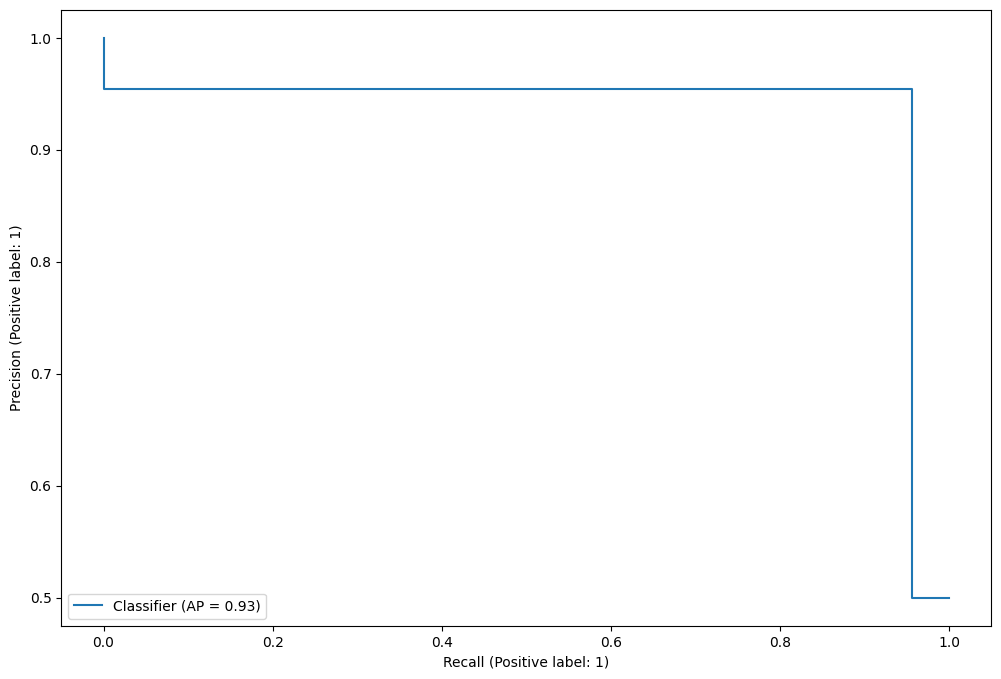

In [78]:
train_and_evaluate_model(RandomForestClassifier())

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     15917
           1       0.95      0.96      0.95     15911

    accuracy                           0.95     31828
   macro avg       0.95      0.95      0.95     31828
weighted avg       0.95      0.95      0.95     31828

Accuracy Score: 0.9538456704788236
Precision Score: 0.949123025251897
Recall Score: 0.9590849098108227
F1 Score: 0.9540779643002282
ROC AUC Score: 0.9538466579587506


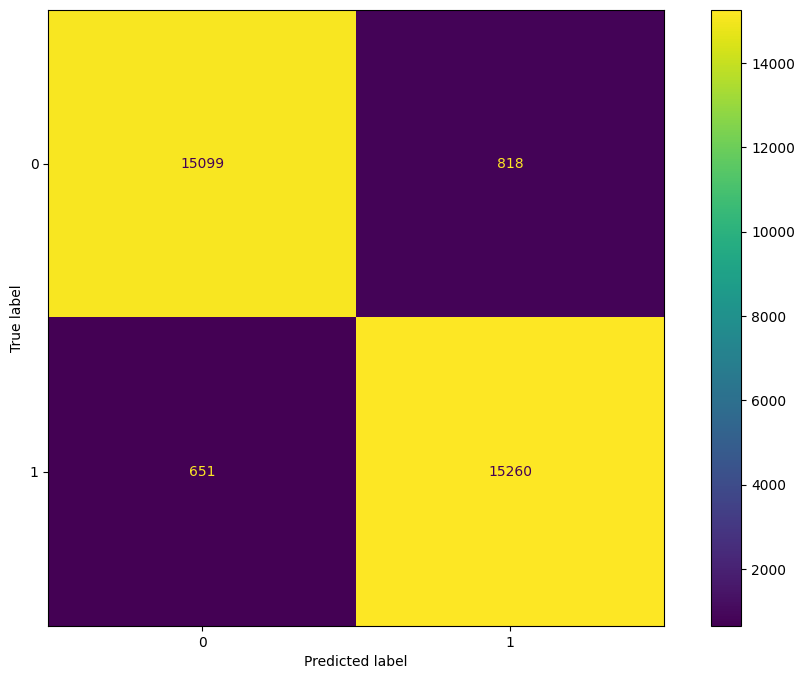

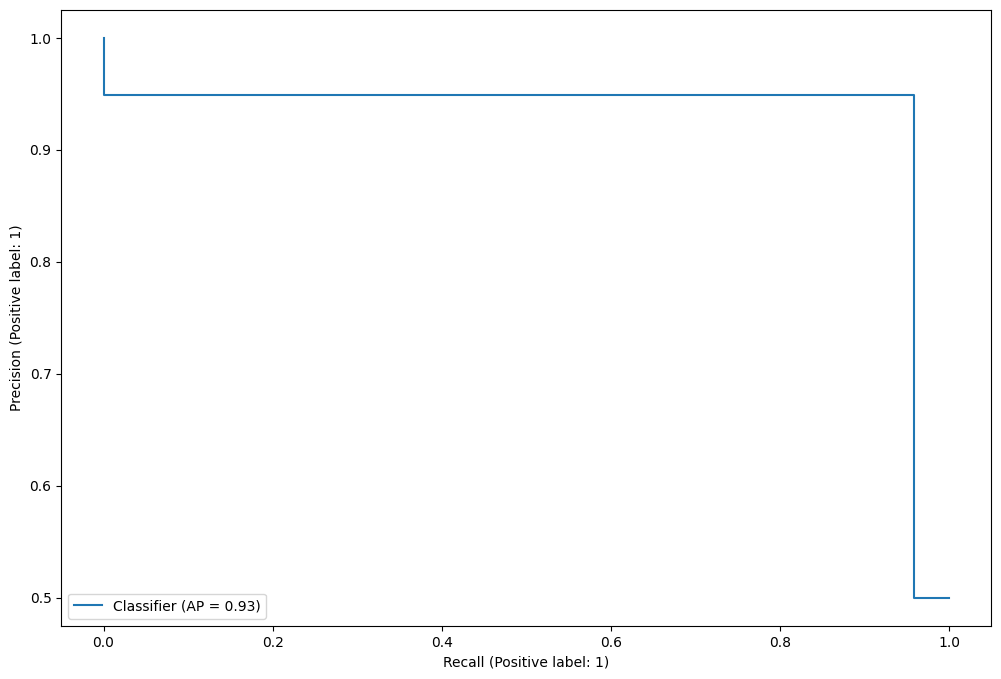

In [79]:
train_and_evaluate_model(ExtraTreesClassifier())

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     15917
           1       0.96      0.95      0.96     15911

    accuracy                           0.96     31828
   macro avg       0.96      0.96      0.96     31828
weighted avg       0.96      0.96      0.96     31828

Accuracy Score: 0.9585270830715094
Precision Score: 0.9637658127264637
Recall Score: 0.9528627993212243
F1 Score: 0.9582832943556033
ROC AUC Score: 0.9585260154801761


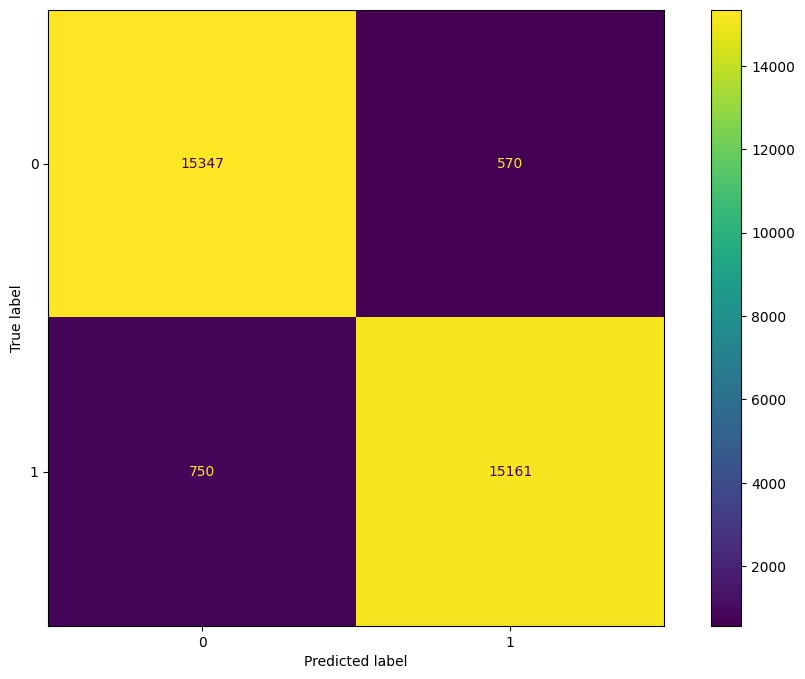

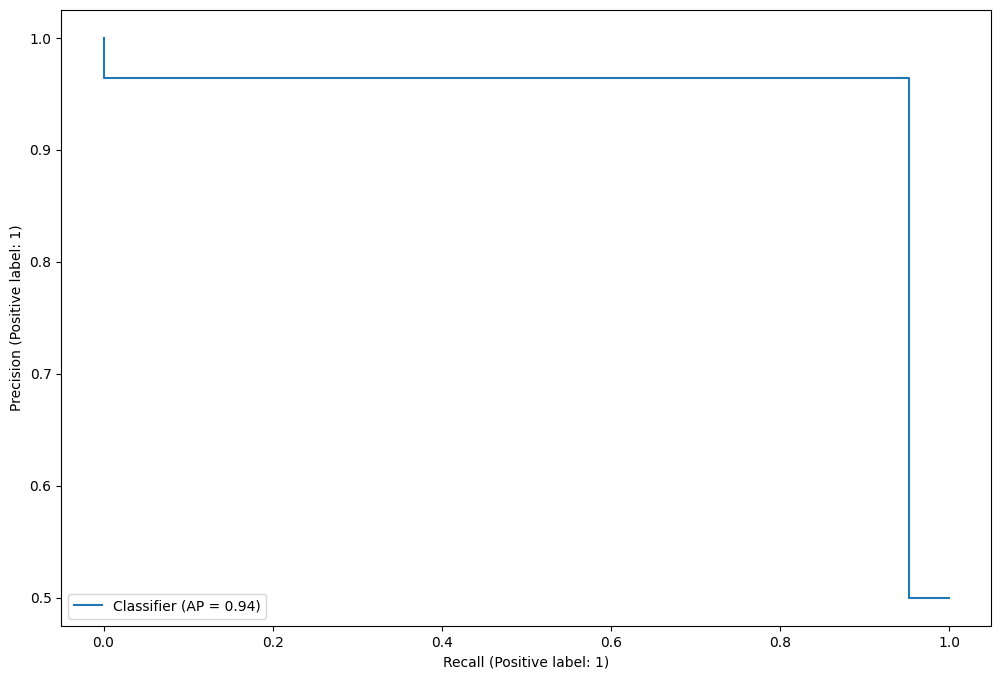

In [80]:
train_and_evaluate_model(BaggingClassifier())

              precision    recall  f1-score   support

           0       0.76      0.80      0.78     15917
           1       0.79      0.75      0.77     15911

    accuracy                           0.78     31828
   macro avg       0.78      0.78      0.77     31828
weighted avg       0.78      0.78      0.77     31828

Accuracy Score: 0.7750722634158602
Precision Score: 0.7909187608030847
Recall Score: 0.7477217019671925
F1 Score: 0.7687138564921009
ROC AUC Score: 0.775067108444173


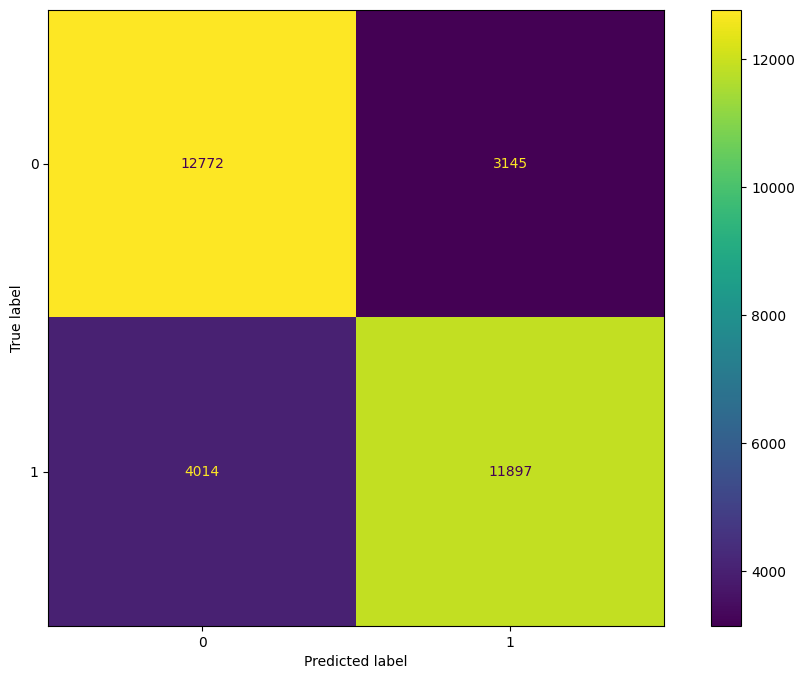

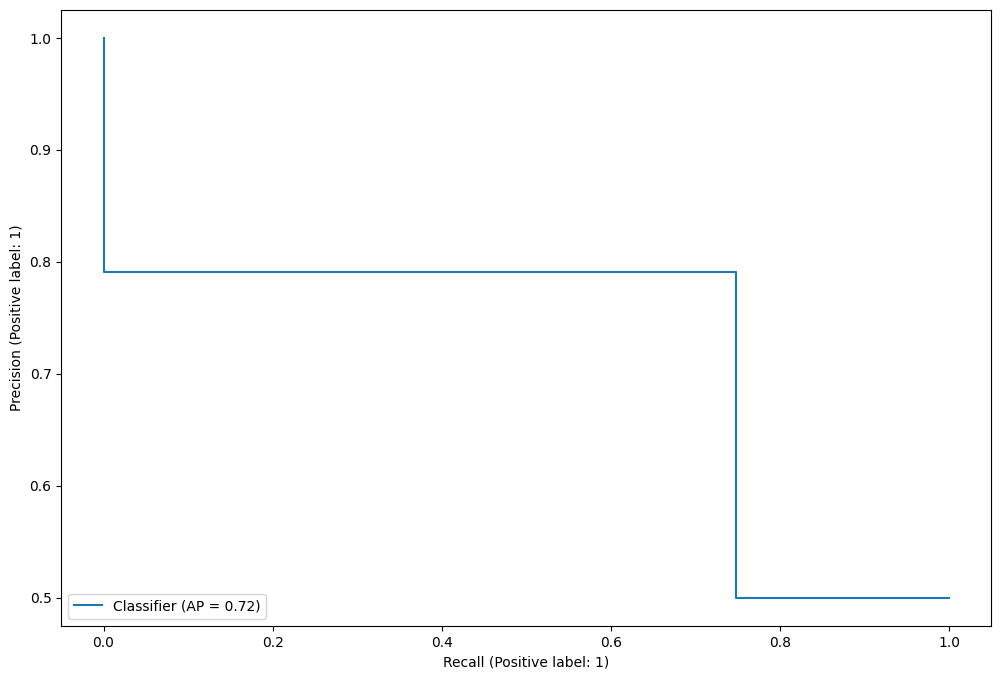

In [81]:
train_and_evaluate_model(AdaBoostClassifier())

              precision    recall  f1-score   support

           0       0.82      0.83      0.82     15917
           1       0.82      0.82      0.82     15911

    accuracy                           0.82     31828
   macro avg       0.82      0.82      0.82     31828
weighted avg       0.82      0.82      0.82     31828

Accuracy Score: 0.8211951740605756
Precision Score: 0.8236225459151362
Recall Score: 0.8173590597699705
F1 Score: 0.8204788492476579
ROC AUC Score: 0.8211944510384689


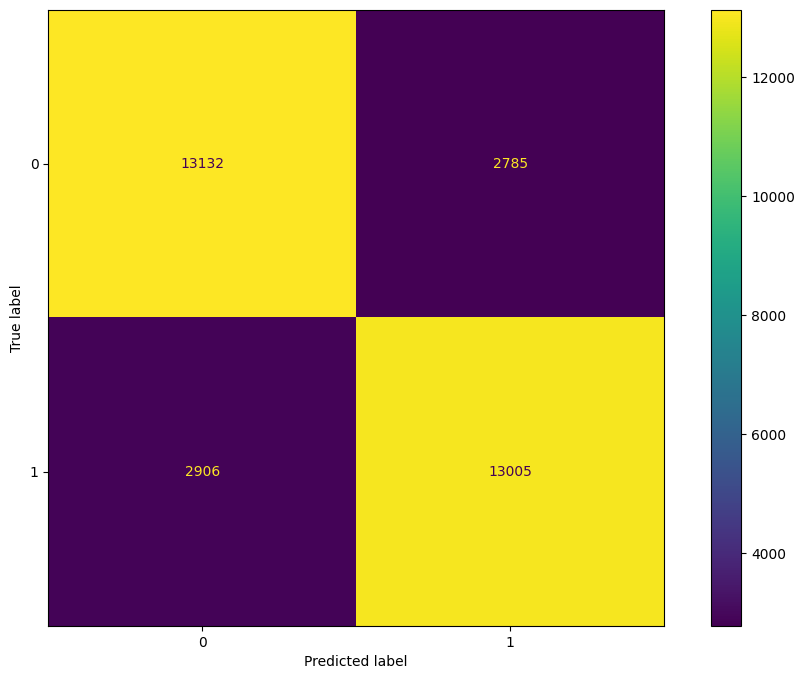

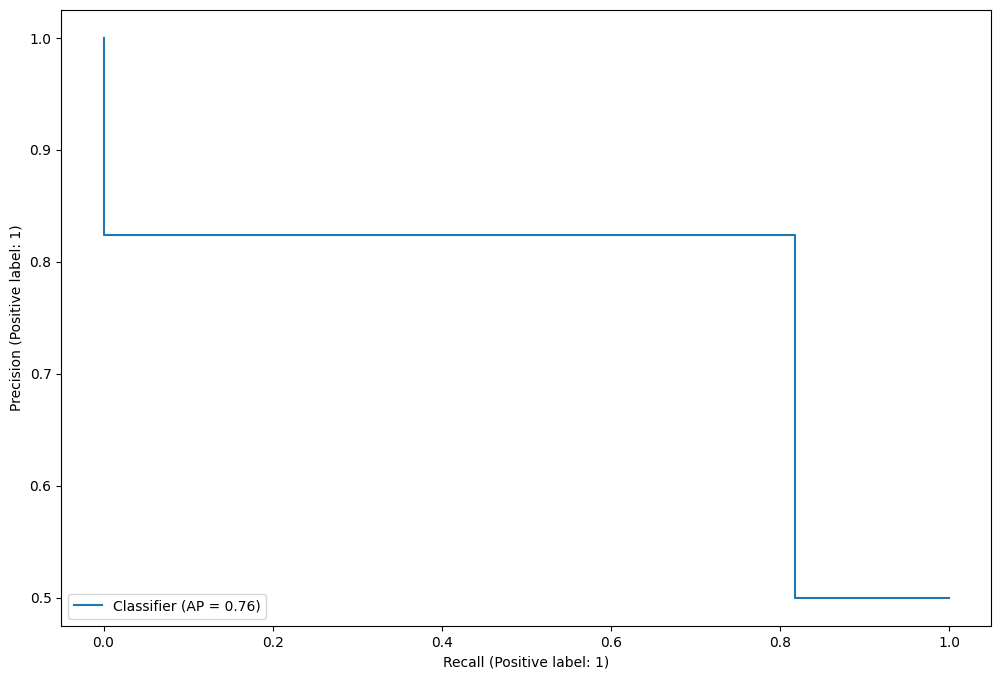

In [82]:
train_and_evaluate_model(GradientBoostingClassifier())

              precision    recall  f1-score   support

           0       0.90      0.89      0.89     15917
           1       0.89      0.90      0.90     15911

    accuracy                           0.90     31828
   macro avg       0.90      0.90      0.90     31828
weighted avg       0.90      0.90      0.90     31828

Accuracy Score: 0.895500816890788
Precision Score: 0.8908627865084788
Recall Score: 0.9013889761800012
F1 Score: 0.8960949703217744
ROC AUC Score: 0.8955019266776743


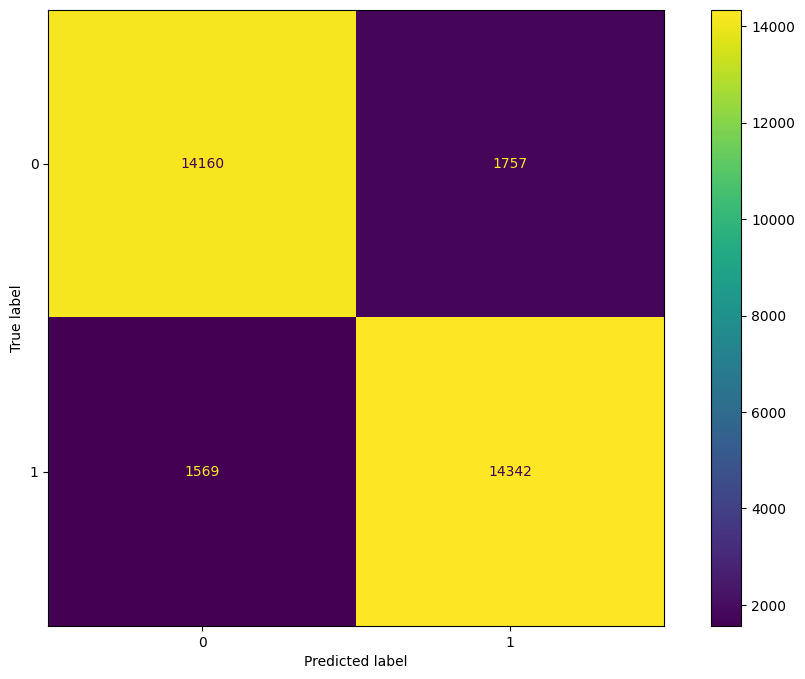

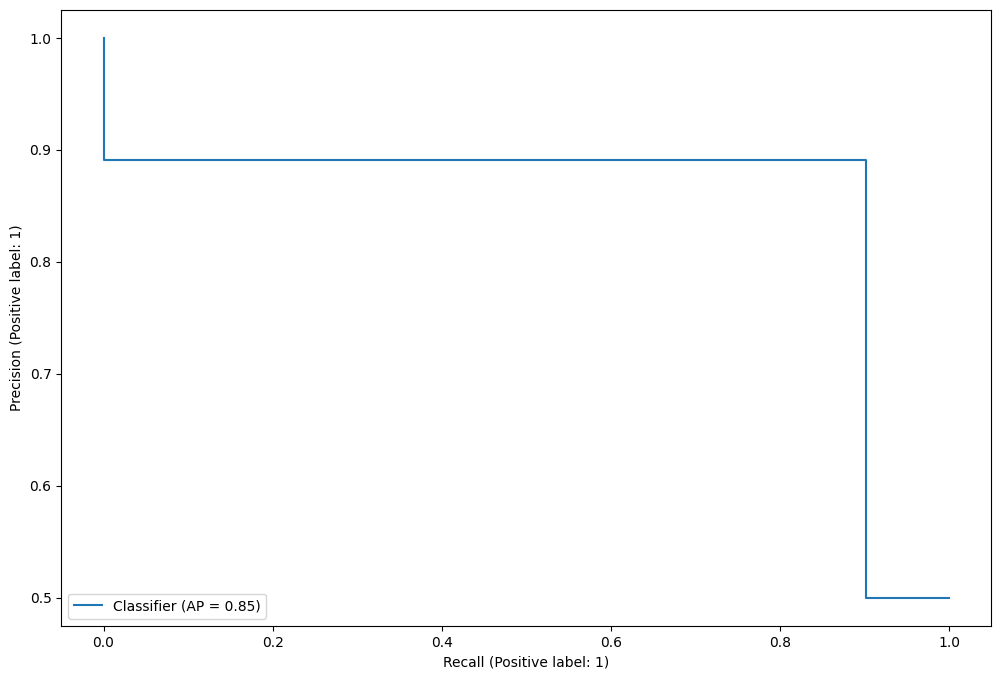

In [83]:
train_and_evaluate_model(HistGradientBoostingClassifier())

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     15917
           1       0.97      0.97      0.97     15911

    accuracy                           0.97     31828
   macro avg       0.97      0.97      0.97     31828
weighted avg       0.97      0.97      0.97     31828

Accuracy Score: 0.9664132210632148
Precision Score: 0.9654415454089312
Recall Score: 0.9674439067311923
F1 Score: 0.966441688902841
ROC AUC Score: 0.9664134153245081


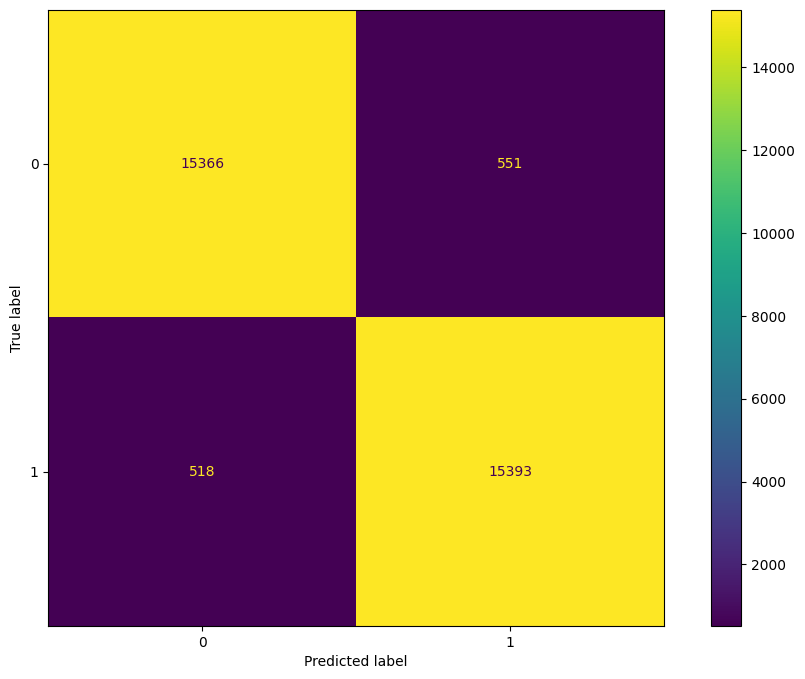

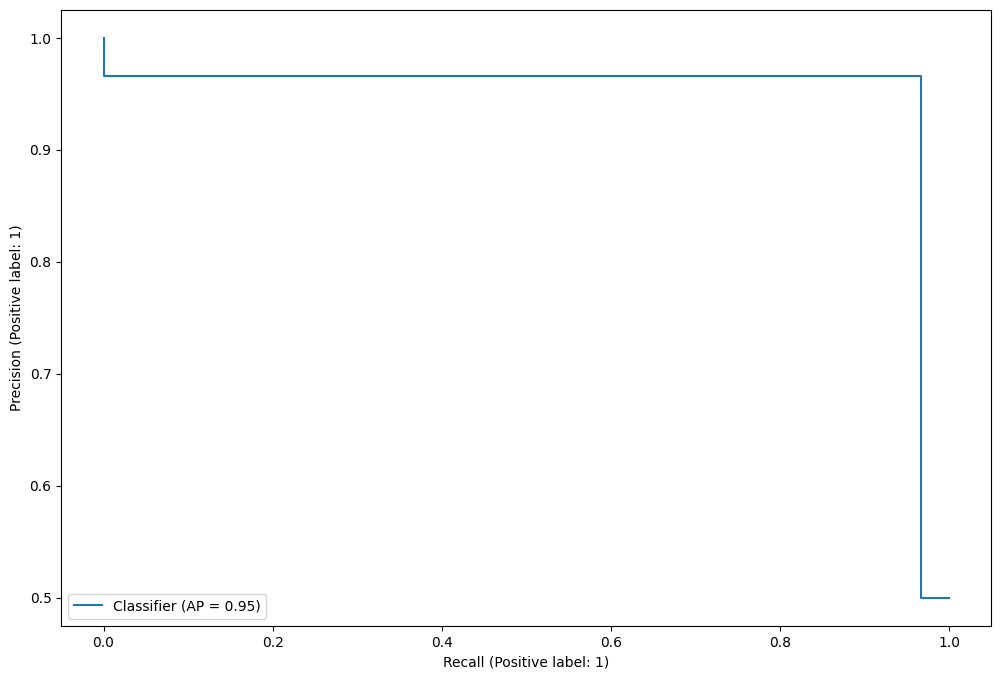

In [84]:
train_and_evaluate_model(XGBClassifier())

              precision    recall  f1-score   support

           0       0.84      0.69      0.76     15917
           1       0.74      0.87      0.80     15911

    accuracy                           0.78     31828
   macro avg       0.79      0.78      0.78     31828
weighted avg       0.79      0.78      0.78     31828

Accuracy Score: 0.7792823928616313
Precision Score: 0.7382816689906683
Recall Score: 0.8651876060587015
F1 Score: 0.7967126776051162
ROC AUC Score: 0.7792985840810565


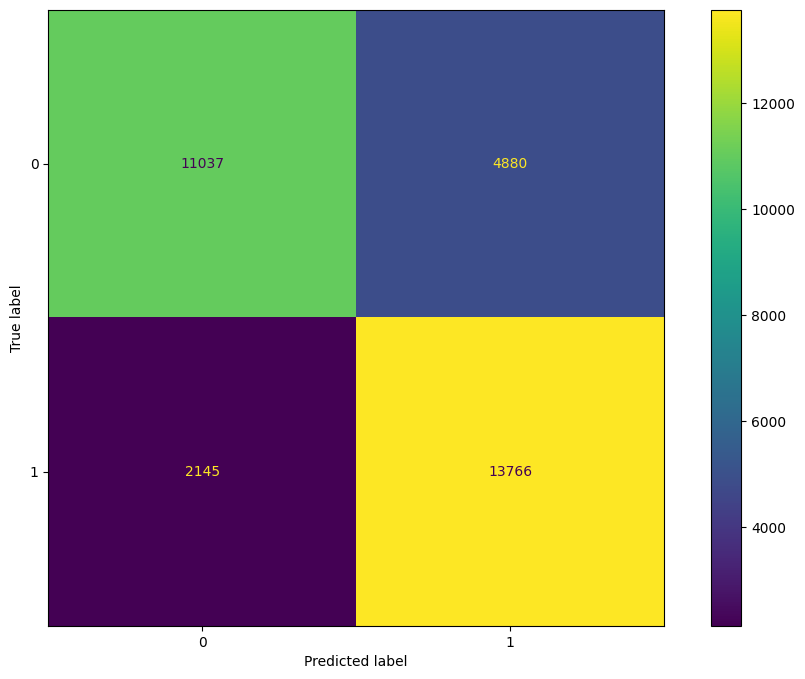

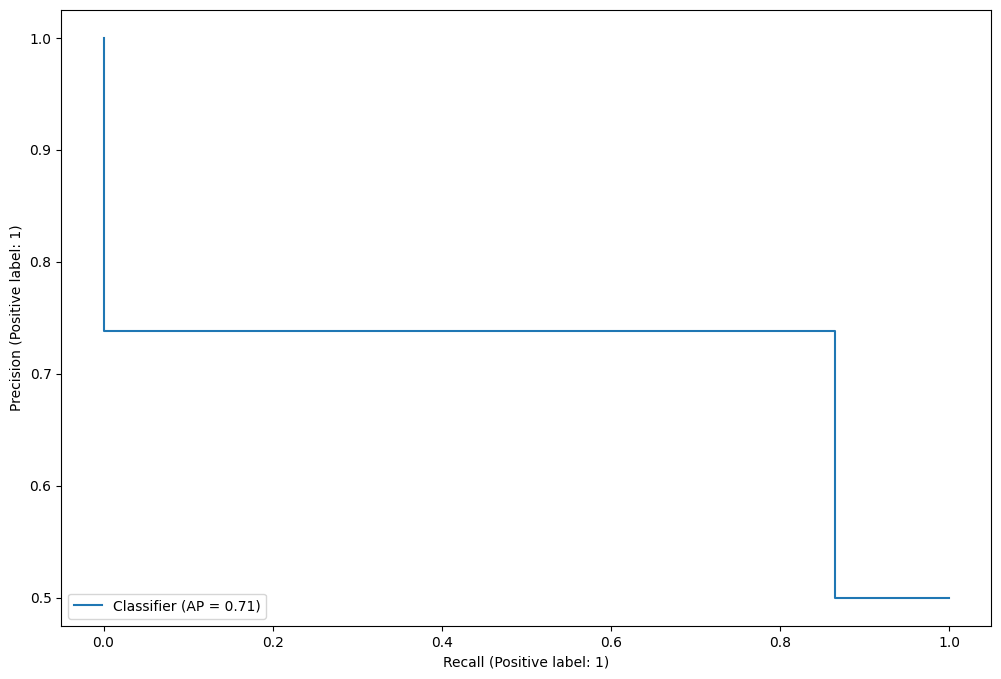

In [85]:
train_and_evaluate_model(XGBRFClassifier())

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     15917
           1       0.92      0.93      0.93     15911

    accuracy                           0.93     31828
   macro avg       0.93      0.93      0.93     31828
weighted avg       0.93      0.93      0.93     31828

Accuracy Score: 0.9284277994218927
Precision Score: 0.9230435052442127
Recall Score: 0.9347621142605744
F1 Score: 0.928865850612041
ROC AUC Score: 0.9284289932991634


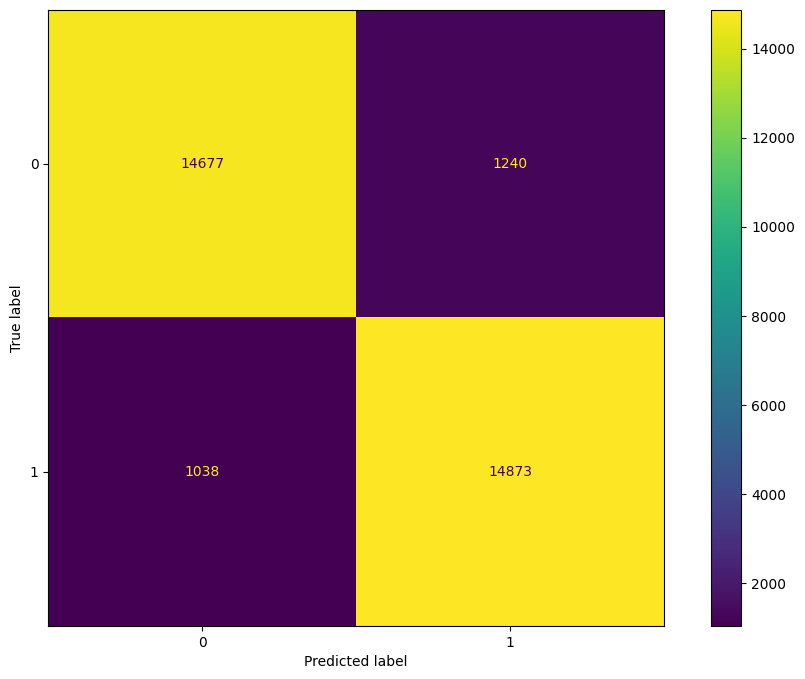

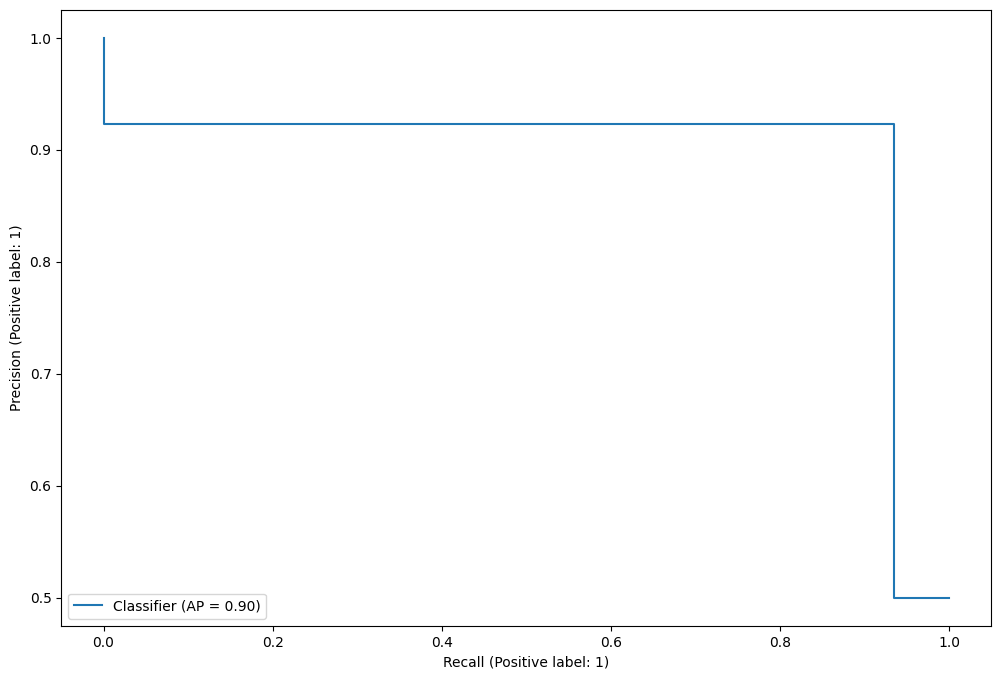

In [86]:
train_and_evaluate_model(LGBMClassifier())

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     15917
           1       0.98      0.96      0.97     15911

    accuracy                           0.97     31828
   macro avg       0.97      0.97      0.97     31828
weighted avg       0.97      0.97      0.97     31828

Accuracy Score: 0.9722571320849567
Precision Score: 0.9792703150912107
Recall Score: 0.9649299226949909
F1 Score: 0.972047231631264
ROC AUC Score: 0.9722557510691766


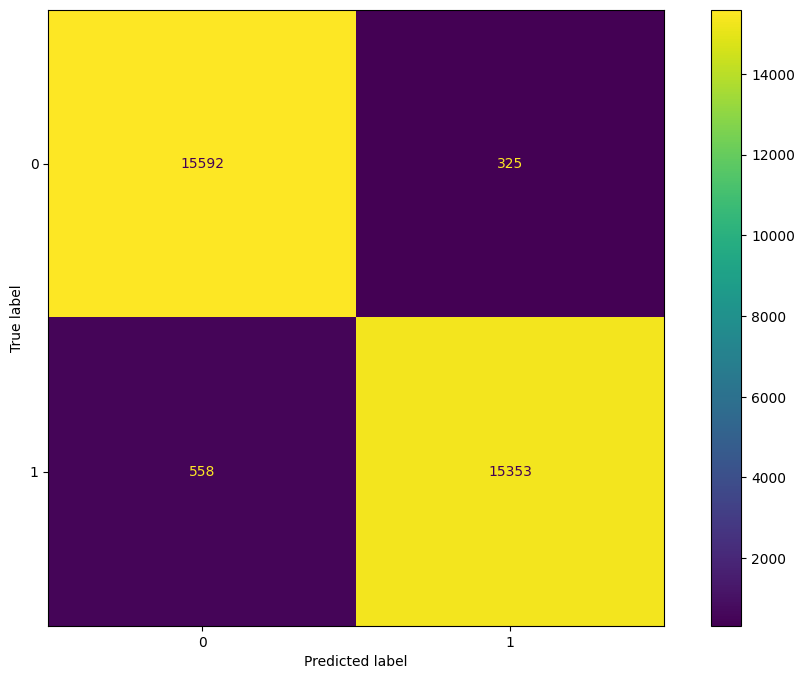

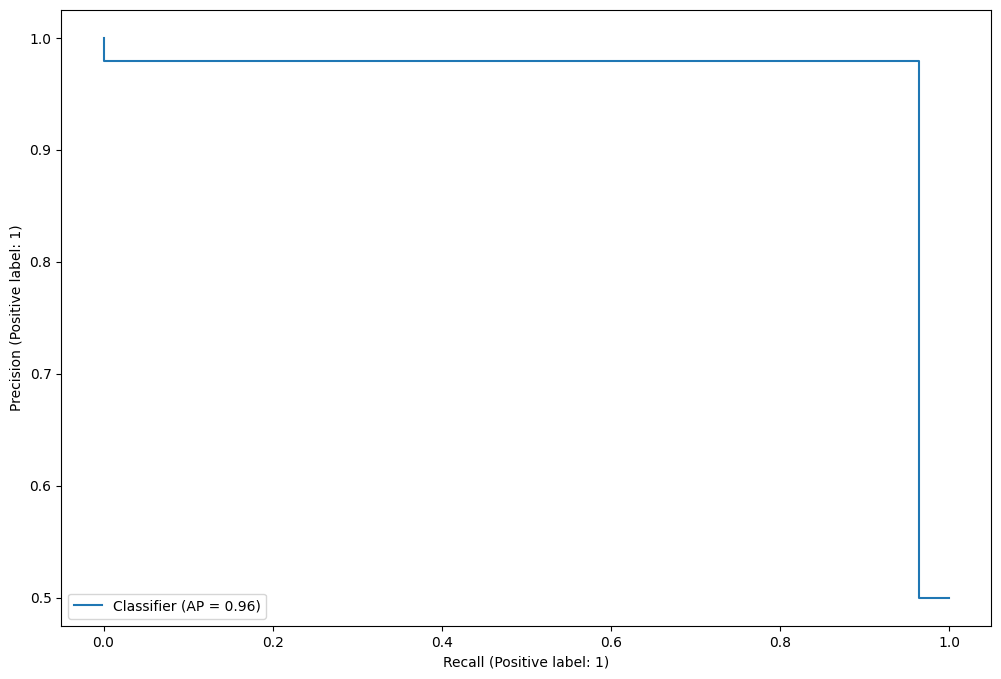

In [87]:
train_and_evaluate_model(CatBoostClassifier(silent=True))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     15917
           1       0.79      0.82      0.81     15911

    accuracy                           0.80     31828
   macro avg       0.80      0.80      0.80     31828
weighted avg       0.80      0.80      0.80     31828

Accuracy Score: 0.8041975618951867
Precision Score: 0.7943197713312656
Recall Score: 0.8208786374206524
F1 Score: 0.8073808493540211
ROC AUC Score: 0.8042007059064059


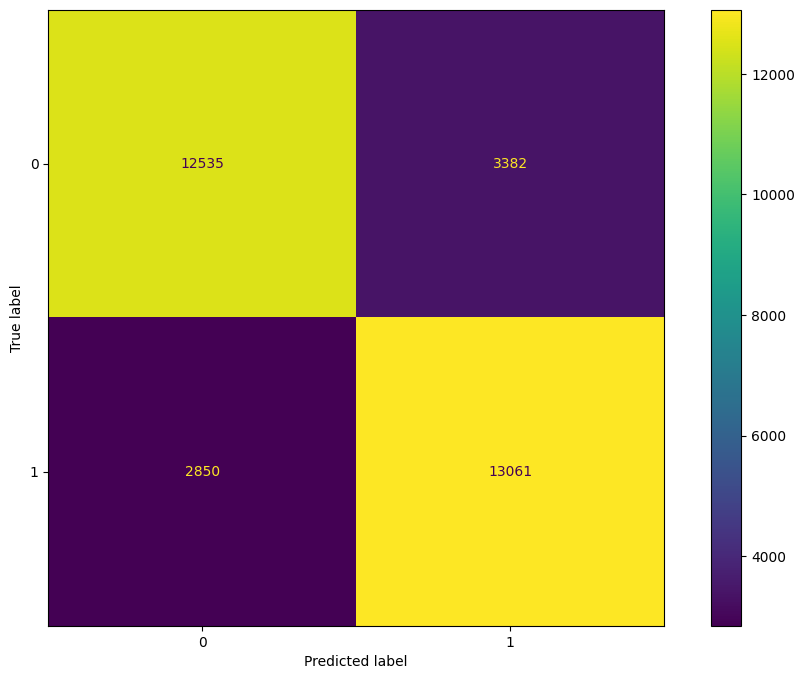

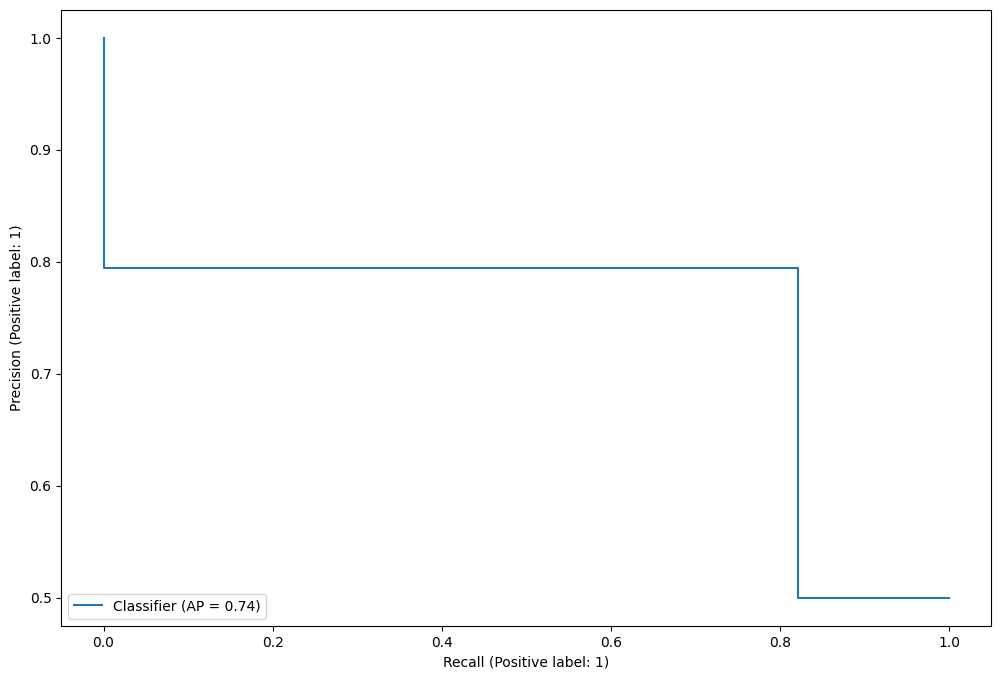

In [88]:
train_and_evaluate_model(MLPClassifier())

## Baseline Models Performance Comparison

In [89]:
model_perfs = pd.DataFrame(list(zip(model_names,accuracy_scores,precision_scores,recall_scores,f1_scores,roc_auc_scores)),columns=['Model','Accuracy','Precision','Recall','F1','ROC AUC Score']).sort_values('Accuracy',ascending=False).reset_index(drop=True)
model_perfs

Model  Accuracy  Precision  \
0   <catboost.core.CatBoostClassifier object at 0x...     0.972      0.979   
1   XGBClassifier(base_score=None, booster=None, c...     0.966      0.965   
2                                 BaggingClassifier()     0.959      0.964   
3                            RandomForestClassifier()     0.955      0.954   
4                              ExtraTreesClassifier()     0.954      0.949   
5                            DecisionTreeClassifier()     0.945      0.946   
6                                    LGBMClassifier()     0.928      0.923   
7                    HistGradientBoostingClassifier()     0.896      0.891   
8                              KNeighborsClassifier()     0.878      0.843   
9                        GradientBoostingClassifier()     0.821      0.824   
10                                    MLPClassifier()     0.804      0.794   
11  XGBRFClassifier(base_score=None, booster=None,...     0.779      0.738   
12                               AdaBoostClassifier()     0.775      0.791   
13                               LogisticRegression()     0.751      0.764   
14                                        LinearSVC()     0.748      0.774   
15                                  RidgeClassifier()     0.748      0.775   
16                                       GaussianNB()     0.743      0.808   
17                                    SGDClassifier()     0.741      0.812   
18                                      BernoulliNB()     0.729      0.773   
19                      PassiveAggressiveClassifier()     0.577      0.584   

    Recall    F1  ROC AUC Score  
0    0.965 0.972          0.972  
1    0.967 0.966          0.966  
2    0.953 0.958          0.959  
3    0.956 0.955          0.955  
4    0.959 0.954          0.954  
5    0.945 0.945          0.945  
6    0.935 0.929          0.928  
7    0.901 0.896          0.896  
8    0.929 0.884          0.878  
9    0.817 0.820          0.821  
10   0.821 0.807          0.804  
11   0.865 0.797          0.779  
12   0.748 0.769          0.775  
13   0.726 0.745          0.751  
14   0.701 0.736          0.748  
15   0.700 0.736          0.748  
16   0.636 0.712          0.743  
17   0.626 0.707          0.741  
18   0.647 0.704          0.729  
19   0.539 0.560          0.577

Among the baseline algorithms used, the Cat Boost Classifier outperforms all other models by achieving a stupendous accuracy of more than 97% on the test dataset. 

## Hyperparameter Tuning and Cross Validation

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END C=0.01, l1_ratio=0.5, multi_class=multinomial, penalty=l2, solver=saga; total time=   0.5s
[CV] END C=0.01, l1_ratio=0.5, multi_class=multinomial, penalty=l2, solver=saga; total time=   0.6s
[CV] END C=0.01, l1_ratio=0.5, multi_class=multinomial, penalty=l2, solver=saga; total time=   0.7s
[CV] END C=0.01, l1_ratio=0.5, multi_class=multinomial, penalty=l2, solver=saga; total time=   0.5s
[CV] END C=0.01, l1_ratio=0.5, multi_class=multinomial, penalty=l2, solver=saga; total time=   0.5s
[CV] END C=0.001, l1_ratio=0.5, multi_class=ovr, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.5, multi_class=ovr, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.5, multi_class=ovr, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.001, l1_ratio=0.5, multi_class=ovr, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.00

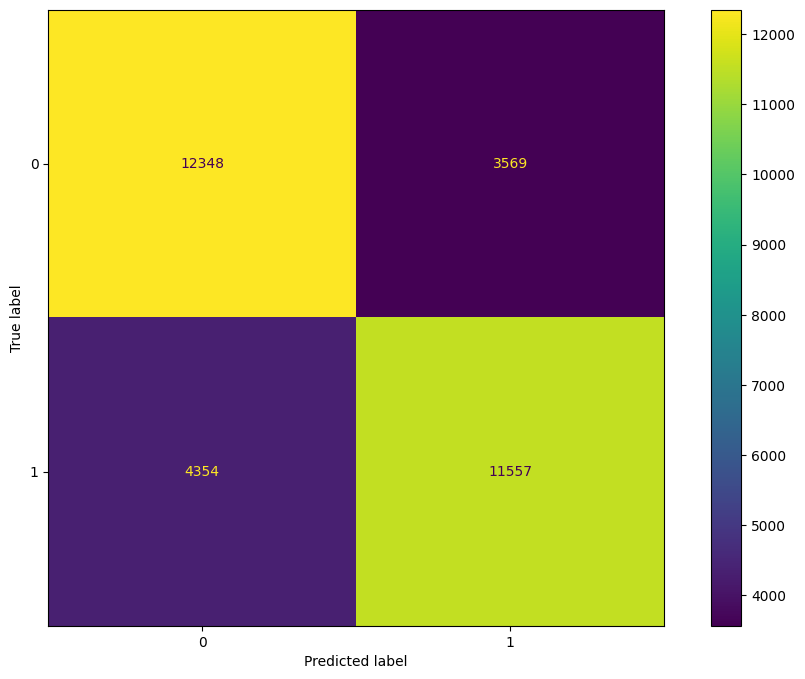

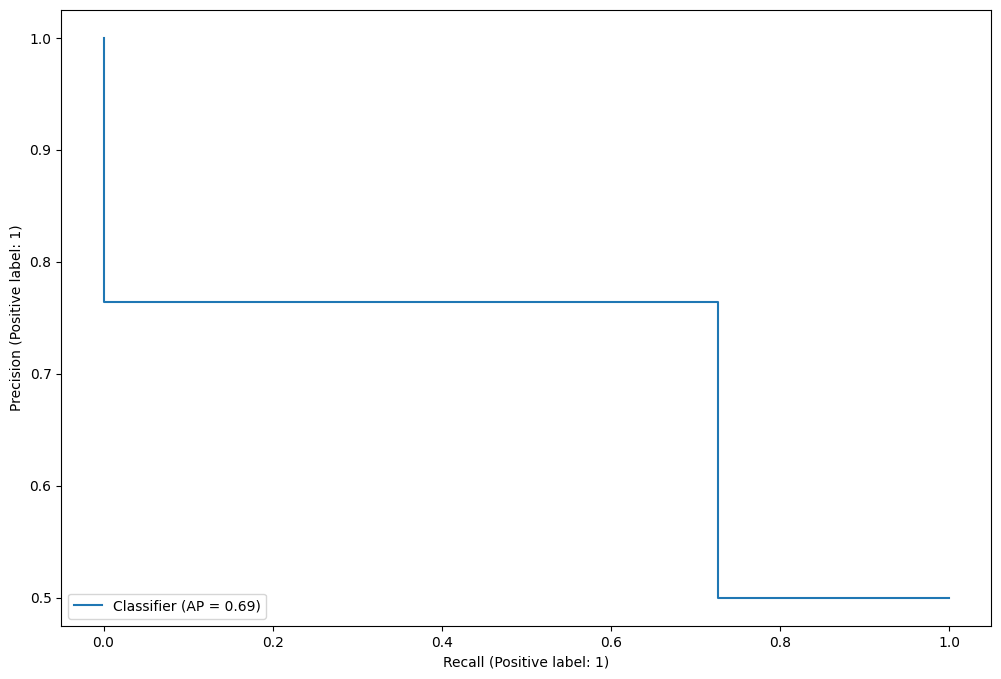

In [90]:
param_grid = {'penalty': ['l1','l2','elasticnet'],
              'C': [0.001,0.01,0.1,0.5],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'multi_class': ['ovr', 'multinomial'],
              'l1_ratio': [0.2,0.5,0.8]
             }

grid_lr = RandomizedSearchCV(LogisticRegression(),param_grid,verbose=2,cv=5)
train_and_evaluate_model(grid_lr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .......C=1, loss=hinge, multi_class=ovr, penalty=l2; total time=   1.0s
[CV] END .......C=1, loss=hinge, multi_class=ovr, penalty=l2; total time=   1.1s
[CV] END .......C=1, loss=hinge, multi_class=ovr, penalty=l2; total time=   0.9s
[CV] END .......C=1, loss=hinge, multi_class=ovr, penalty=l2; total time=   1.0s
[CV] END .......C=1, loss=hinge, multi_class=ovr, penalty=l2; total time=   1.1s
[CV] END ...C=0.001, loss=hinge, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END ...C=0.001, loss=hinge, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END ...C=0.001, loss=hinge, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END ...C=0.001, loss=hinge, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END ...C=0.001, loss=hinge, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END ....C=0.01, loss=hinge, multi_class=ovr, penalty=l1; total time=   0.0s
[CV] END ....C=0.01, loss=hinge, multi_class=ovr

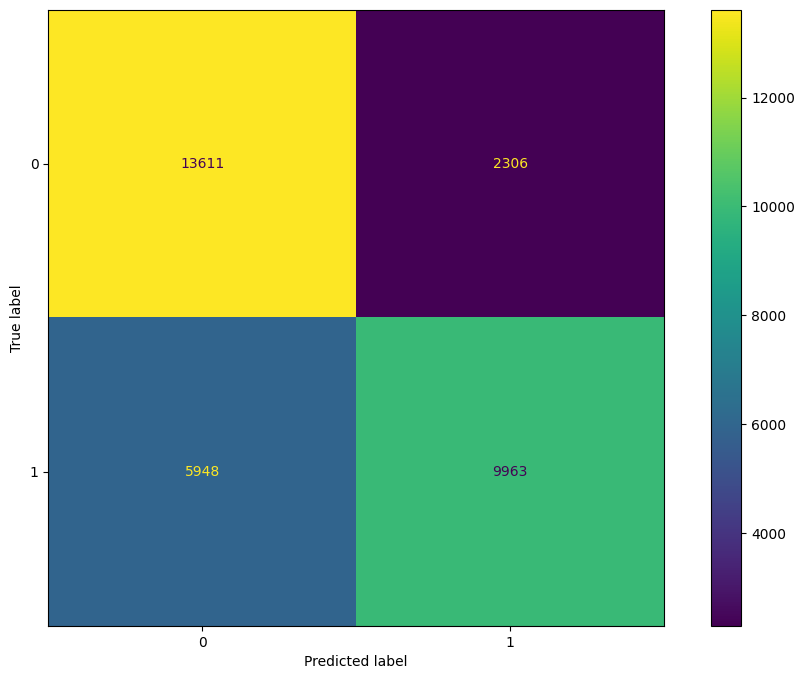

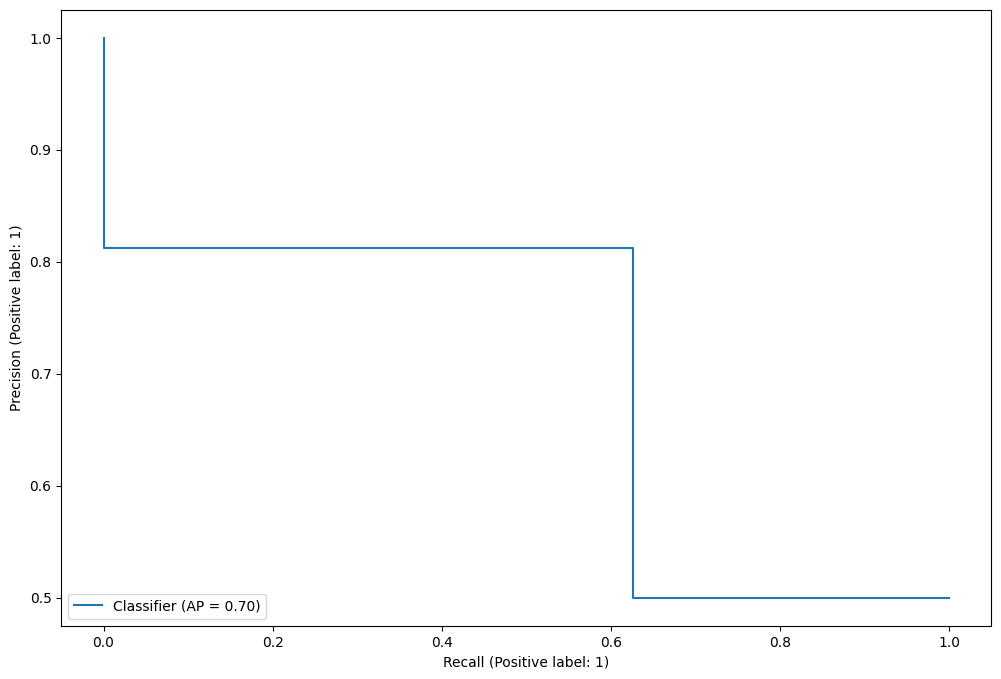

In [91]:
param_grid = {'penalty': ['l1','l2'],
             'loss': ['hinge','squared_hinge'],
             'C': [0.0001,0.001,0.01,0.1,1],
             'multi_class': ['ovr','crammer_singer']}

grid_lsvc = RandomizedSearchCV(LinearSVC(),param_grid,cv=5,verbose=2)
train_and_evaluate_model(grid_lsvc)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=entropy, max_depth=201, max_features=sqrt;, score=0.928 total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=201, max_features=sqrt;, score=0.932 total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=201, max_features=sqrt;, score=0.924 total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=201, max_features=sqrt;, score=0.930 total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=201, max_features=sqrt;, score=0.926 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=98, max_features=log2;, score=0.921 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=98, max_features=log2;, score=0.930 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=98, max_features=log2;, score=0.925 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=98, max_features=log2;, score=0.923 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=98, max_features=log2;, score=0.92

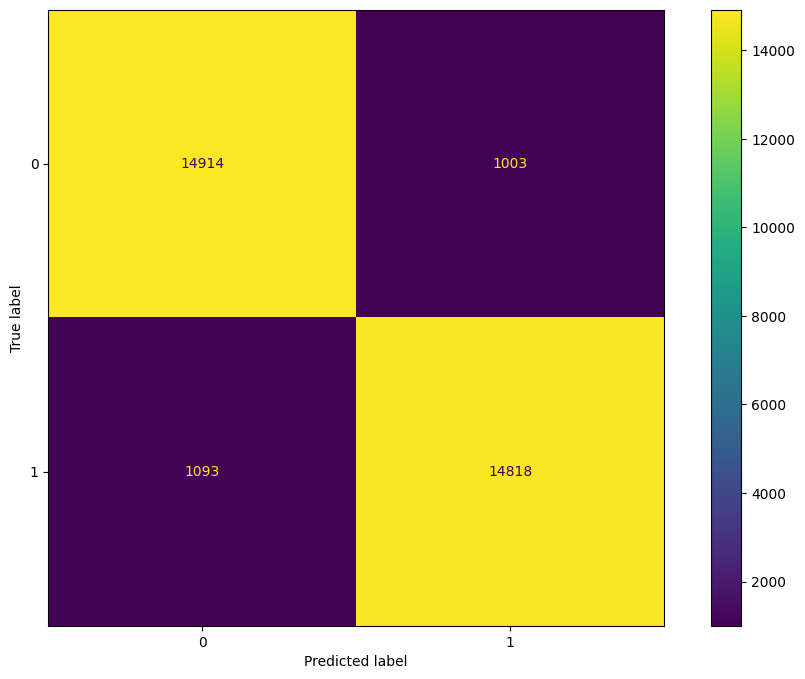

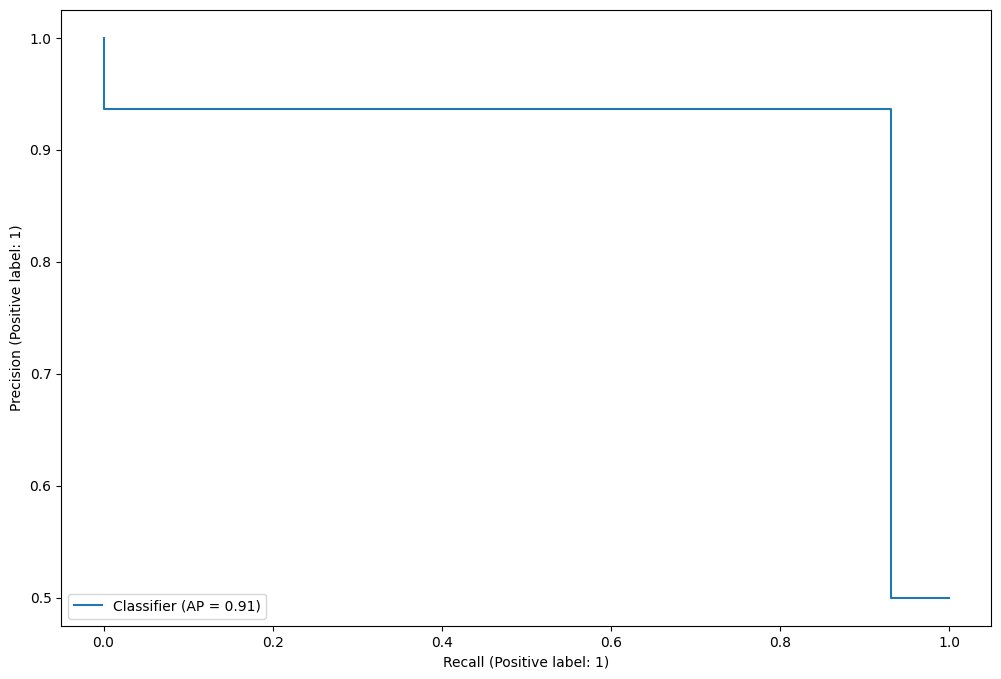

In [92]:
param_grid = {'criterion': ['gini','entropy'],
              'max_features': ['sqrt','log2'],
              'max_depth': [2,12,38,68,98,128,201]
             }

grid_dt = RandomizedSearchCV(DecisionTreeClassifier(),param_grid,verbose=4,cv=5)
train_and_evaluate_model(grid_dt)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.4, n_estimators=200;, score=0.973 total time=   3.1s
[CV 2/5] END learning_rate=0.4, n_estimators=200;, score=0.968 total time=   3.4s
[CV 3/5] END learning_rate=0.4, n_estimators=200;, score=0.969 total time=   3.6s
[CV 4/5] END learning_rate=0.4, n_estimators=200;, score=0.970 total time=   3.2s
[CV 5/5] END learning_rate=0.4, n_estimators=200;, score=0.968 total time=   3.0s
[CV 1/5] END .learning_rate=1, n_estimators=500;, score=0.976 total time=   6.5s
[CV 2/5] END .learning_rate=1, n_estimators=500;, score=0.975 total time=   6.3s
[CV 3/5] END .learning_rate=1, n_estimators=500;, score=0.972 total time=   6.9s
[CV 4/5] END .learning_rate=1, n_estimators=500;, score=0.976 total time=   6.3s
[CV 5/5] END .learning_rate=1, n_estimators=500;, score=0.975 total time=   6.9s
[CV 1/5] END learning_rate=0.4, n_estimators=1000;, score=0.980 total time=  12.3s
[CV 2/5] END learning_rate=0.4, n_estimat

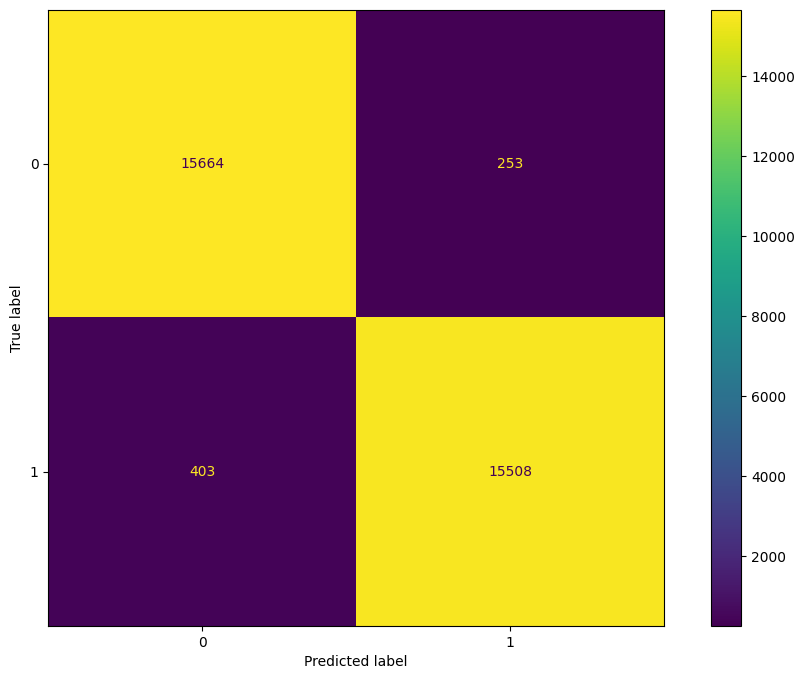

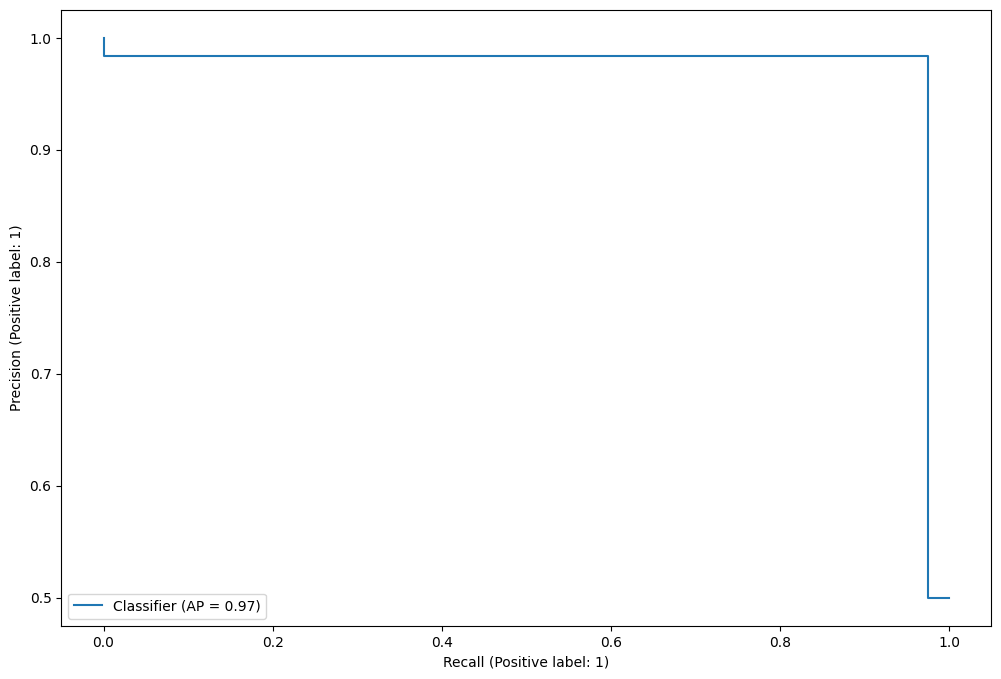

In [93]:
param_grid = {'learning_rate': [0.2,0.4,0.7,1],
              'n_estimators': [200,500,1000]
             }
grid_cat = RandomizedSearchCV(CatBoostClassifier(silent=True),param_grid,verbose=3,cv=5)
train_and_evaluate_model(grid_cat)

In [139]:
search_space = {
    "n_estimators": (100,1000),
    "max_samples": [0.24,0.58,0.71,0.96],
    "max_features": list(np.linspace(0.1,1,5)),
    "bootstrap": (True,False),
    "warm_start": (True,False)
}

optimizer = BayesSearchCV(estimator=BaggingClassifier(),
                         search_spaces=search_space,
                         n_jobs=-1,
                         n_iter=10,
                         cv=3,
                         verbose=2)
optimizer.fit(final_X_train,y_train_tf)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


BayesSearchCV(cv=3, estimator=BaggingClassifier(), n_iter=10, n_jobs=-1,
              search_spaces={'bootstrap': (True, False),
                             'max_features': [0.1, 0.325, 0.55, 0.775, 1.0],
                             'max_samples': [0.24, 0.58, 0.71, 0.96],
                             'n_estimators': (100, 1000),
                             'warm_start': (True, False)},
              verbose=2)

In [140]:
print("Best parameters:",optimizer.best_params_)
print("Best score:",optimizer.best_score_)

Best parameters: OrderedDict([('bootstrap', True), ('max_features', 0.55), ('max_samples', 0.71), ('n_estimators', 550), ('warm_start', True)])
Best score: 0.9756409631060485


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END boosting_type=gbdt, importance_type=gain, learning_rate=1.0, min_split_gain=0.87, n_estimators=500;, score=0.668 total time=   1.3s
[CV 2/5] END boosting_type=gbdt, importance_type=gain, learning_rate=1.0, min_split_gain=0.87, n_estimators=500;, score=0.693 total time=   1.5s
[CV 3/5] END boosting_type=gbdt, importance_type=gain, learning_rate=1.0, min_split_gain=0.87, n_estimators=500;, score=0.964 total time=   0.4s
[CV 4/5] END boosting_type=gbdt, importance_type=gain, learning_rate=1.0, min_split_gain=0.87, n_estimators=500;, score=0.962 total time=   0.6s
[CV 5/5] END boosting_type=gbdt, importance_type=gain, learning_rate=1.0, min_split_gain=0.87, n_estimators=500;, score=0.957 total time=   0.4s
[CV 1/5] END boosting_type=dart, importance_type=split, learning_rate=0.6000000000000001, min_split_gain=0.87, n_estimators=600;, score=0.967 total time=  19.2s
[CV 2/5] END boosting_type=dart, importance_type=spli

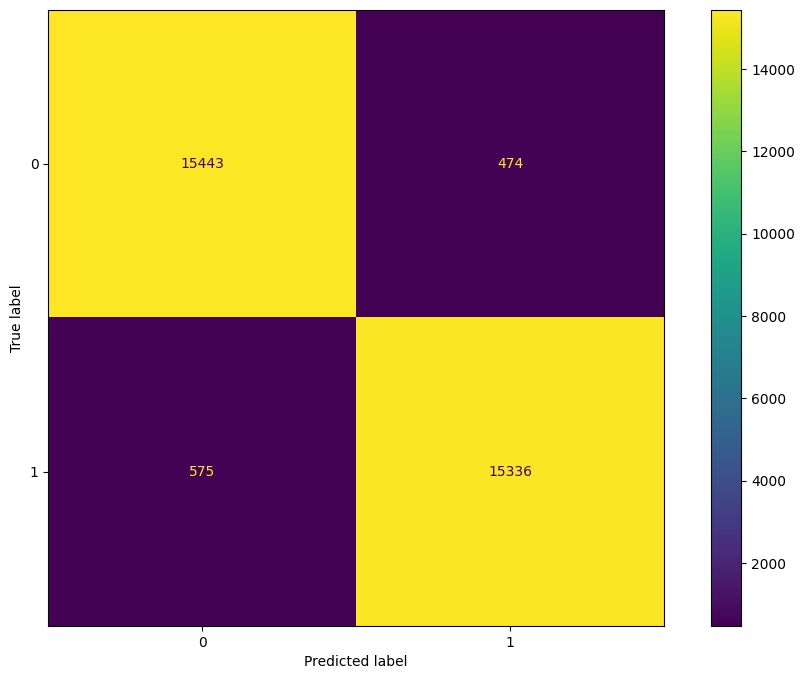

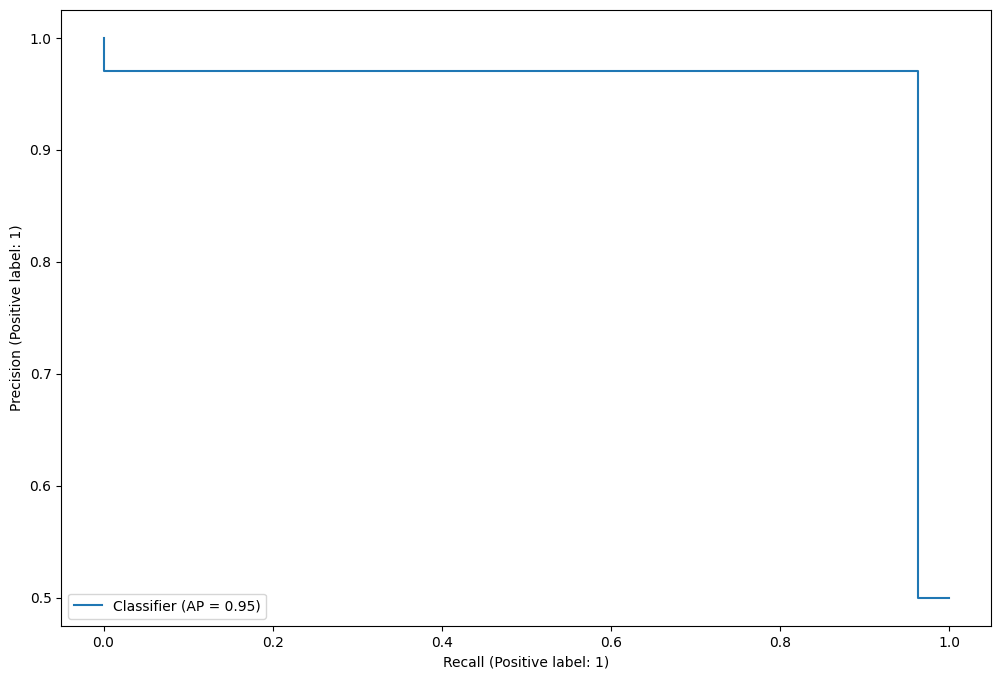

In [95]:
param_grid = {'boosting_type': ['gbdt','dart','goss','rf'],
              'learning_rate': np.linspace(0,1,6)[1:],
              'n_estimators': [200,500,600,1000],
              'importance_type': ['split','gain'],
              'min_split_gain': [0.68,0.79,0.87,1]}

grid_lgbm = RandomizedSearchCV(LGBMClassifier(),param_grid,verbose=3)
train_and_evaluate_model(grid_lgbm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END bootstrap=False, class_weight=balanced, criterion=gini, max_features=log2, max_samples=0.2, n_estimators=600, warm_start=True;, score=nan total time=   0.0s
[CV 2/5] END bootstrap=False, class_weight=balanced, criterion=gini, max_features=log2, max_samples=0.2, n_estimators=600, warm_start=True;, score=nan total time=   0.0s
[CV 3/5] END bootstrap=False, class_weight=balanced, criterion=gini, max_features=log2, max_samples=0.2, n_estimators=600, warm_start=True;, score=nan total time=   0.0s
[CV 4/5] END bootstrap=False, class_weight=balanced, criterion=gini, max_features=log2, max_samples=0.2, n_estimators=600, warm_start=True;, score=nan total time=   0.0s
[CV 5/5] END bootstrap=False, class_weight=balanced, criterion=gini, max_features=log2, max_samples=0.2, n_estimators=600, warm_start=True;, score=nan total time=   0.0s
[CV 1/5] END bootstrap=False, class_weight=balanced, criterion=gini, max_features=log2, m

[CV 3/5] END bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, max_samples=0.7, n_estimators=1000, warm_start=True;, score=0.938 total time=  55.6s
[CV 4/5] END bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, max_samples=0.7, n_estimators=1000, warm_start=True;, score=0.942 total time=  55.5s
[CV 5/5] END bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, max_samples=0.7, n_estimators=1000, warm_start=True;, score=0.939 total time=  52.1s
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     15917
           1       0.94      0.96      0.95     15911

    accuracy                           0.95     31828
   macro avg       0.95      0.95      0.95     31828
weighted avg       0.95      0.95      0.95     31828

Accuracy Score: 0.9475304763101672
Precision Score: 0.9396727384995369
Recall Score: 0.9564452265728113
F1 Score: 0.94

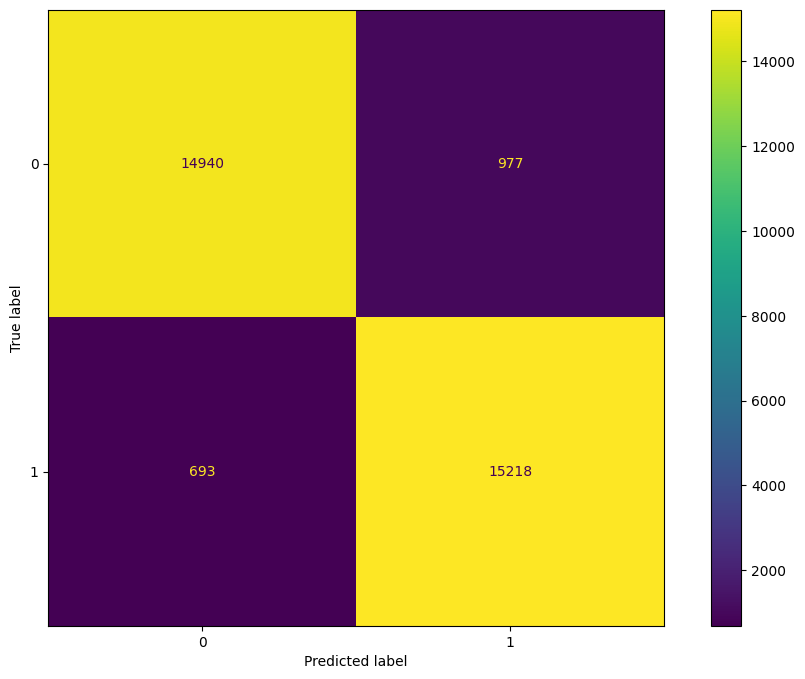

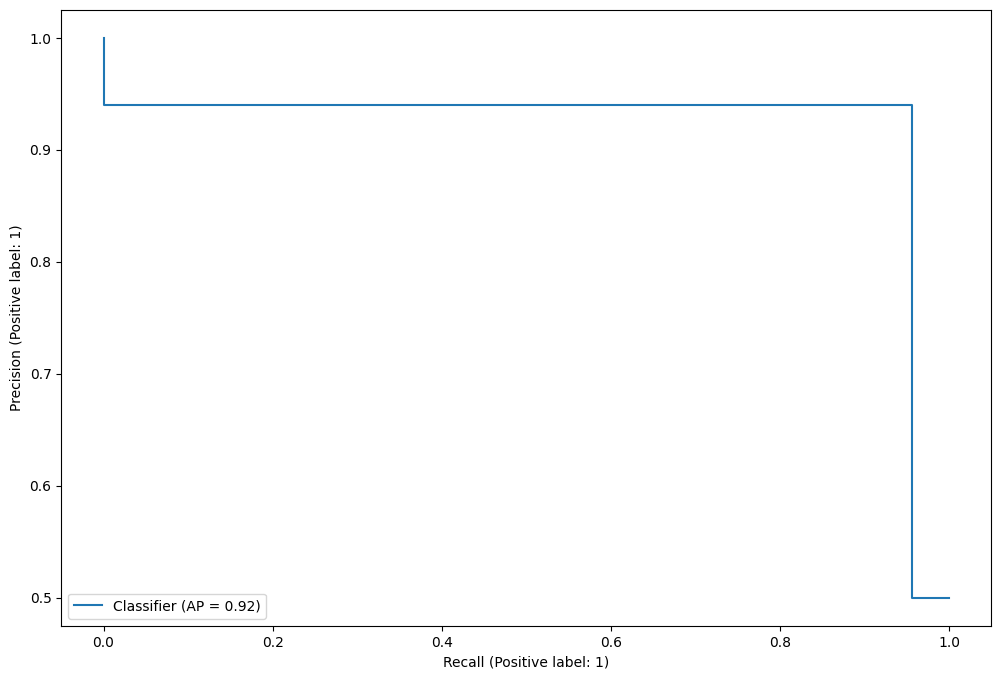

In [96]:
param_grid = {'n_estimators': [100,300,600,1000],
             'criterion': ['gini','entropy'],
             'max_features': ['sqrt','log2'],
             'bootstrap': [True,False],
             'class_weight': ['balanced','balanced_subsample'],
             'warm_start': [True,False],
             'max_samples': [0.2,0.45,0.7,0.95]
             }

grid_et = RandomizedSearchCV(ExtraTreesClassifier(),param_grid,verbose=4)
train_and_evaluate_model(grid_et)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END alpha=0.0, binarize=1.0, fit_prior=False;, score=0.736 total time=   0.0s
[CV 2/5] END alpha=0.0, binarize=1.0, fit_prior=False;, score=0.730 total time=   0.0s
[CV 3/5] END alpha=0.0, binarize=1.0, fit_prior=False;, score=0.727 total time=   0.0s
[CV 4/5] END alpha=0.0, binarize=1.0, fit_prior=False;, score=0.735 total time=   0.0s
[CV 5/5] END alpha=0.0, binarize=1.0, fit_prior=False;, score=0.736 total time=   0.0s
[CV 1/5] END alpha=0.6000000000000001, binarize=0.0, fit_prior=False;, score=0.728 total time=   0.0s
[CV 2/5] END alpha=0.6000000000000001, binarize=0.0, fit_prior=False;, score=0.725 total time=   0.0s
[CV 3/5] END alpha=0.6000000000000001, binarize=0.0, fit_prior=False;, score=0.719 total time=   0.0s
[CV 4/5] END alpha=0.6000000000000001, binarize=0.0, fit_prior=False;, score=0.723 total time=   0.0s
[CV 5/5] END alpha=0.6000000000000001, binarize=0.0, fit_prior=False;, score=0.726 total time=  

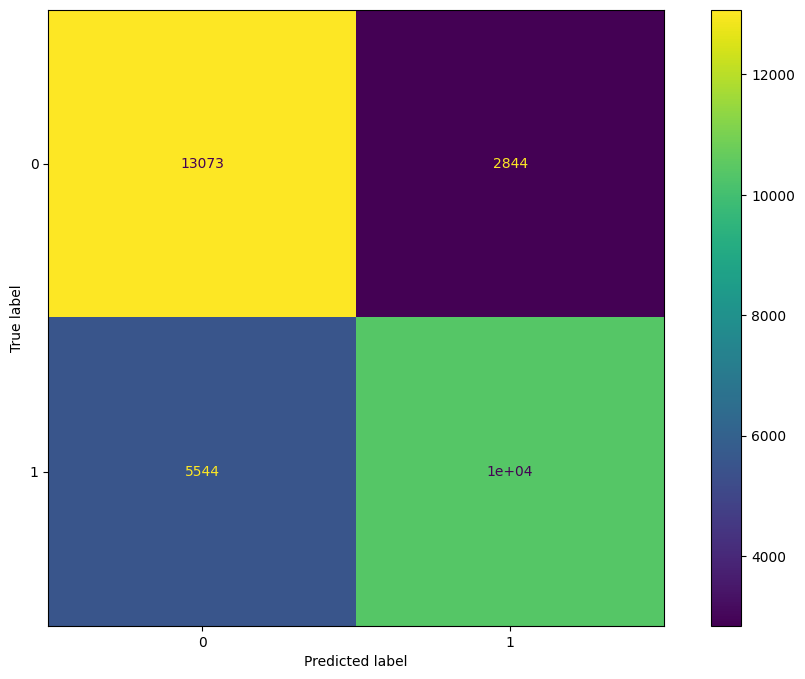

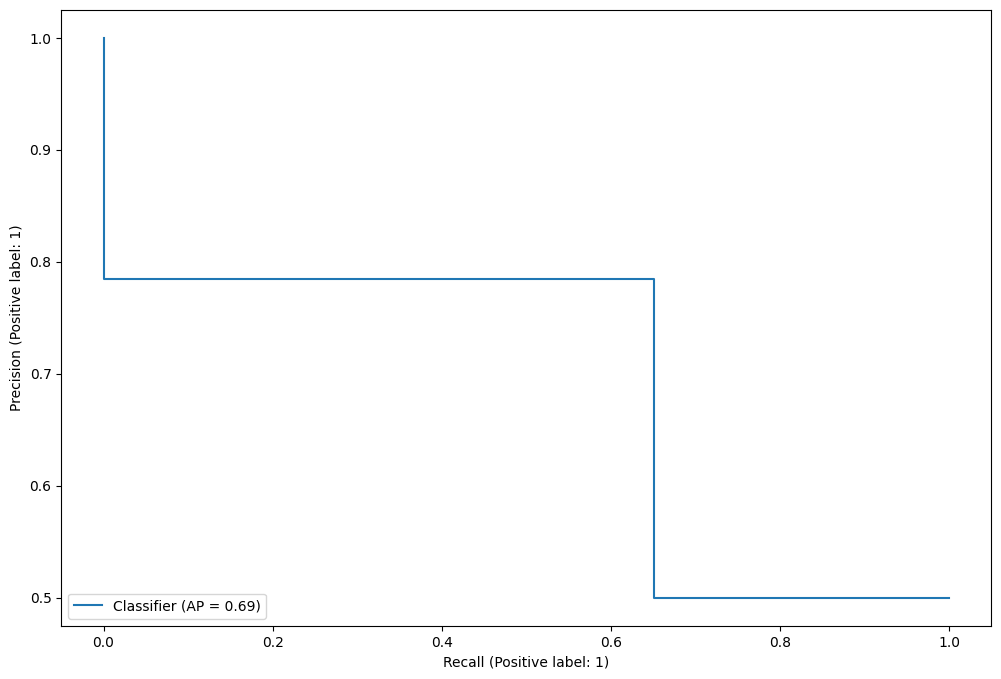

In [97]:
param_grid = {'alpha': np.linspace(0,1,6),
              'binarize': np.linspace(0,1,5),
              'fit_prior': [True,False]
             }

grid_bnb = RandomizedSearchCV(BernoulliNB(),param_grid,verbose=3,cv=5)
train_and_evaluate_model(grid_bnb)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END algorithm=kd_tree, metric=minkowski, n_neighbors=20, weights=distance;, score=0.877 total time=   6.0s
[CV 2/5] END algorithm=kd_tree, metric=minkowski, n_neighbors=20, weights=distance;, score=0.877 total time=   5.7s
[CV 3/5] END algorithm=kd_tree, metric=minkowski, n_neighbors=20, weights=distance;, score=0.878 total time=   5.9s
[CV 4/5] END algorithm=kd_tree, metric=minkowski, n_neighbors=20, weights=distance;, score=0.877 total time=   5.7s
[CV 5/5] END algorithm=kd_tree, metric=minkowski, n_neighbors=20, weights=distance;, score=0.877 total time=   6.1s
[CV 1/5] END algorithm=kd_tree, metric=chebyshev, n_neighbors=12, weights=distance;, score=0.879 total time=   8.4s
[CV 2/5] END algorithm=kd_tree, metric=chebyshev, n_neighbors=12, weights=distance;, score=0.879 total time=   9.2s
[CV 3/5] END algorithm=kd_tree, metric=chebyshev, n_neighbors=12, weights=distance;, score=0.879 total time=  10.7s
[CV 4/5] EN

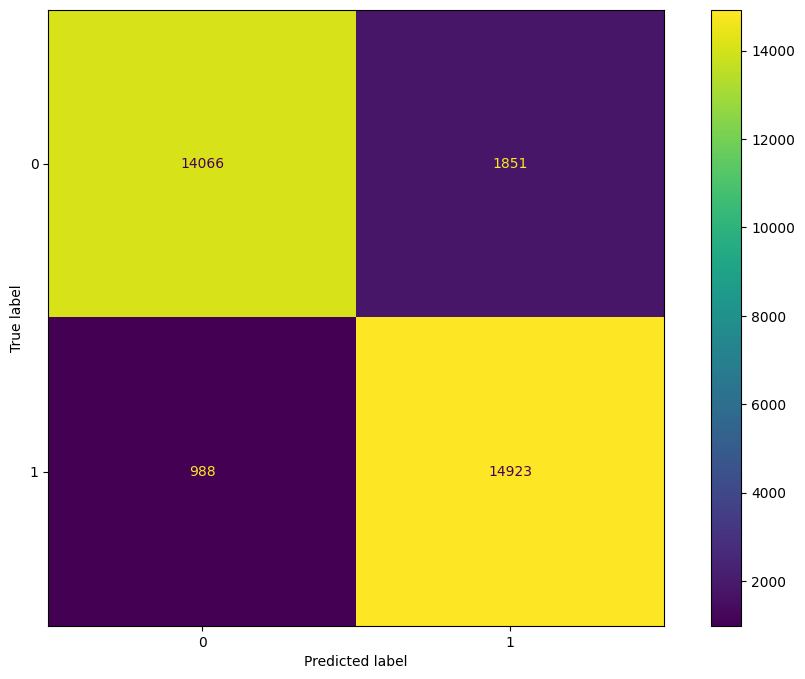

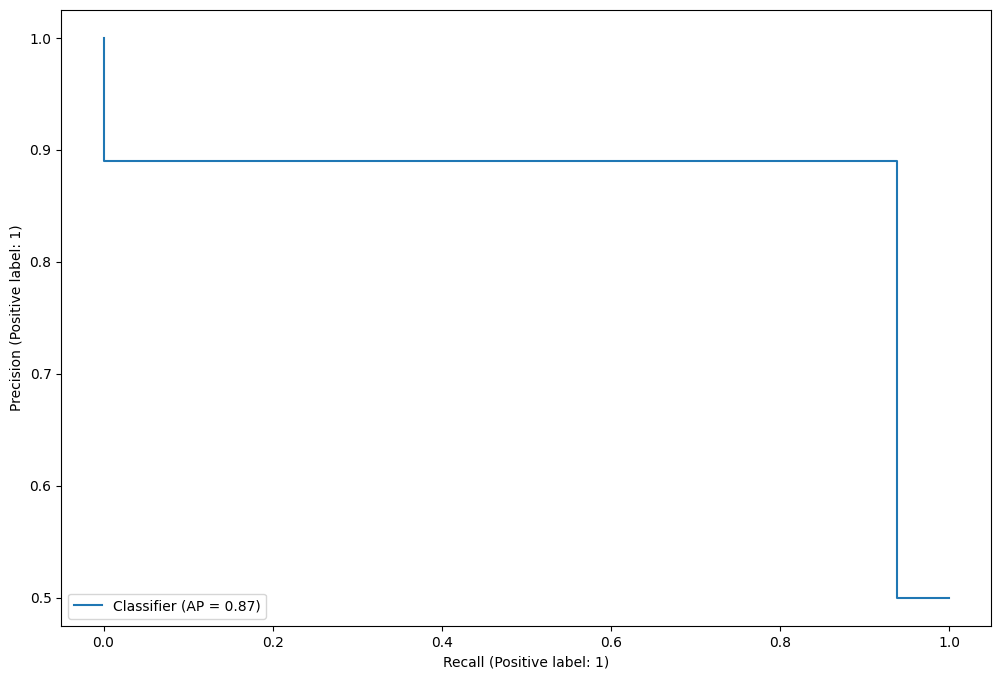

In [98]:
param_grid = {'n_neighbors': [2,5,8,12,20],
              'weights': ['uniform','distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'metric': ['minkowski','manhattan','euclidean','chebyshev']
             }
grid_knn = RandomizedSearchCV(KNeighborsClassifier(),param_grid,cv=5,verbose=3)
train_and_evaluate_model(grid_knn)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END alpha=0.0, fit_intercept=True, positive=True, solver=sag; total time=   0.0s
[CV] END alpha=0.0, fit_intercept=True, positive=True, solver=sag; total time=   0.0s
[CV] END alpha=0.0, fit_intercept=True, positive=True, solver=sag; total time=   0.0s
[CV] END alpha=0.0, fit_intercept=True, positive=True, solver=sag; total time=   0.0s
[CV] END alpha=0.0, fit_intercept=True, positive=True, solver=sag; total time=   0.0s
[CV] END alpha=1.0, fit_intercept=True, positive=False, solver=sag; total time=   0.4s
[CV] END alpha=1.0, fit_intercept=True, positive=False, solver=sag; total time=   0.5s
[CV] END alpha=1.0, fit_intercept=True, positive=False, solver=sag; total time=   0.4s
[CV] END alpha=1.0, fit_intercept=True, positive=False, solver=sag; total time=   0.5s
[CV] END alpha=1.0, fit_intercept=True, positive=False, solver=sag; total time=   0.5s
[CV] END alpha=0.25, fit_intercept=False, positive=True, solver=svd; total

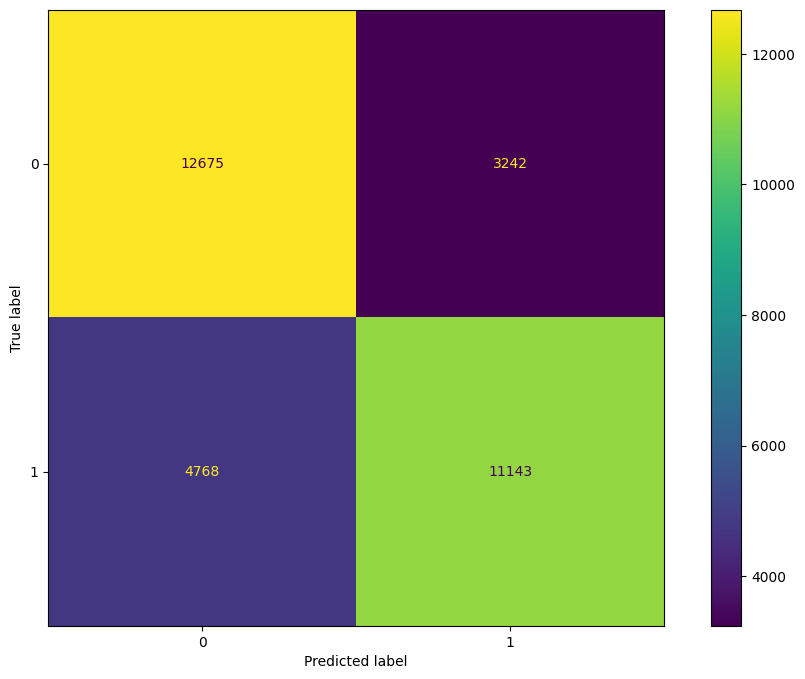

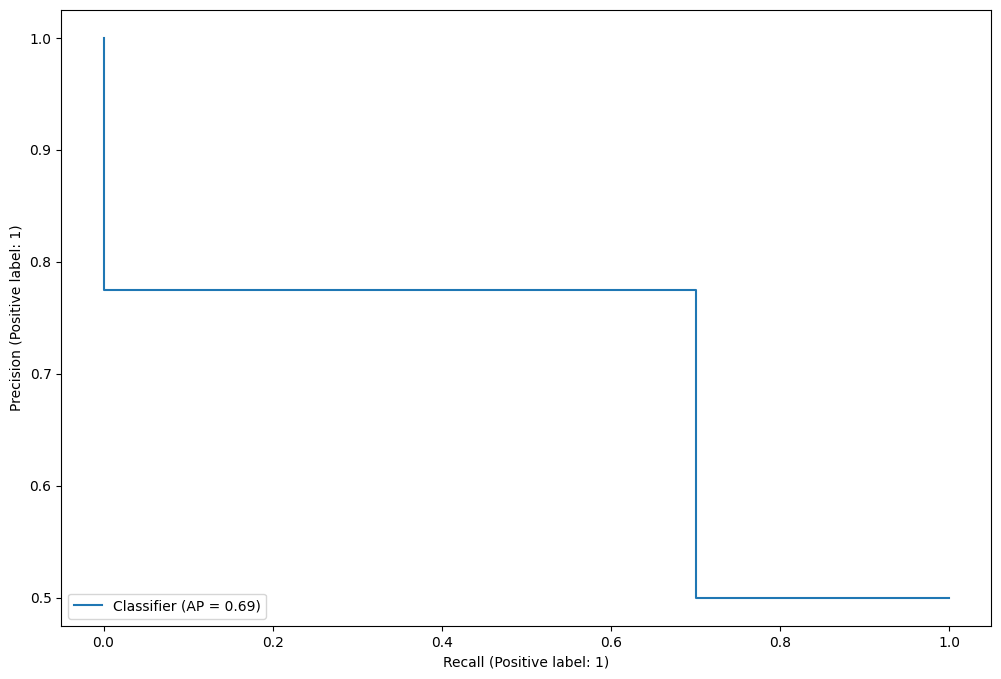

In [99]:
param_grid = {'alpha': np.linspace(0,1,5),
              'fit_intercept': [True,False],
              'positive': [True,False],
              'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']}

grid_ridge = RandomizedSearchCV(RidgeClassifier(),param_grid,verbose=2,cv=5)
train_and_evaluate_model(grid_ridge)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END class_weight=balanced, criterion=gini, max_features=log2, n_estimators=1000; total time= 1.9min
[CV] END class_weight=balanced, criterion=gini, max_features=log2, n_estimators=1000; total time= 1.9min
[CV] END class_weight=balanced, criterion=gini, max_features=log2, n_estimators=1000; total time= 1.8min
[CV] END class_weight=balanced, criterion=gini, max_features=log2, n_estimators=1000; total time= 1.8min
[CV] END class_weight=balanced, criterion=gini, max_features=log2, n_estimators=1000; total time= 2.4min
[CV] END class_weight=balanced, criterion=entropy, max_features=log2, n_estimators=800; total time= 1.7min
[CV] END class_weight=balanced, criterion=entropy, max_features=log2, n_estimators=800; total time= 1.7min
[CV] END class_weight=balanced, criterion=entropy, max_features=log2, n_estimators=800; total time= 2.8min
[CV] END class_weight=balanced, criterion=entropy, max_features=log2, n_estimators=800; total

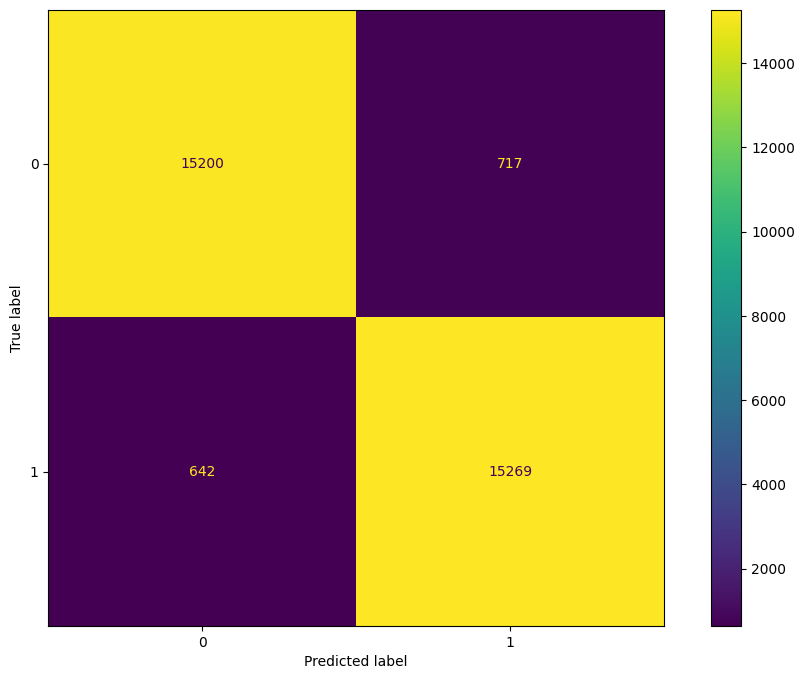

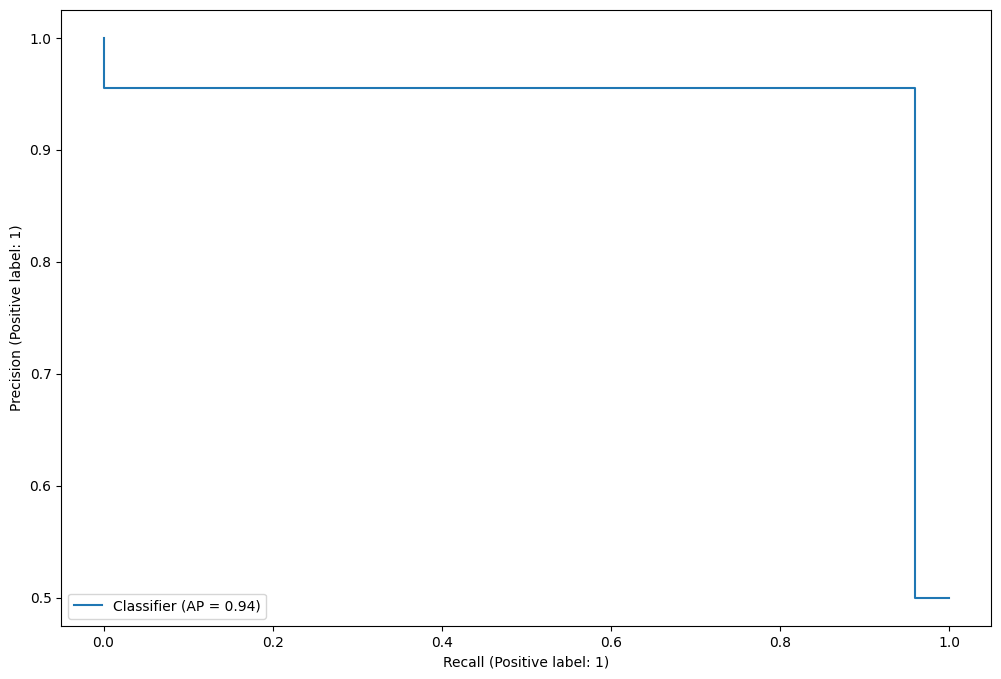

In [100]:
param_grid = {'n_estimators': [200,400,600,800,1000], 
              'criterion': ['gini','entropy'],
              'max_features': ['auto','sqrt','log2'],
              'class_weight': ['balanced','balanced_subsample']}
grid_rf = RandomizedSearchCV(RandomForestClassifier(),param_grid,verbose=2,cv=5)
train_and_evaluate_model(grid_rf)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END interaction_cst=pairwise, learning_rate=0.4, loss=binary_crossentropy, max_depth=15;, score=0.933 total time=   2.4s
[CV 2/5] END interaction_cst=pairwise, learning_rate=0.4, loss=binary_crossentropy, max_depth=15;, score=0.926 total time=   2.4s
[CV 3/5] END interaction_cst=pairwise, learning_rate=0.4, loss=binary_crossentropy, max_depth=15;, score=0.928 total time=   2.4s
[CV 4/5] END interaction_cst=pairwise, learning_rate=0.4, loss=binary_crossentropy, max_depth=15;, score=0.930 total time=   2.3s
[CV 5/5] END interaction_cst=pairwise, learning_rate=0.4, loss=binary_crossentropy, max_depth=15;, score=0.924 total time=   2.2s
[CV 1/5] END interaction_cst=no_interaction, learning_rate=0.4, loss=categorical_crossentropy, max_depth=15;, score=nan total time=   0.0s
[CV 2/5] END interaction_cst=no_interaction, learning_rate=0.4, loss=categorical_crossentropy, max_depth=15;, score=nan total time=   0.0s
[CV 3/5] EN

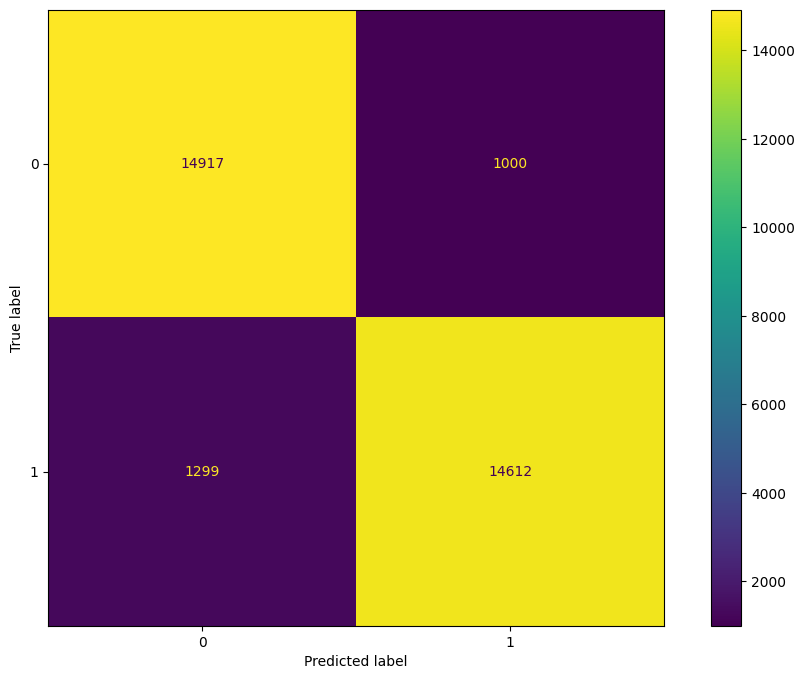

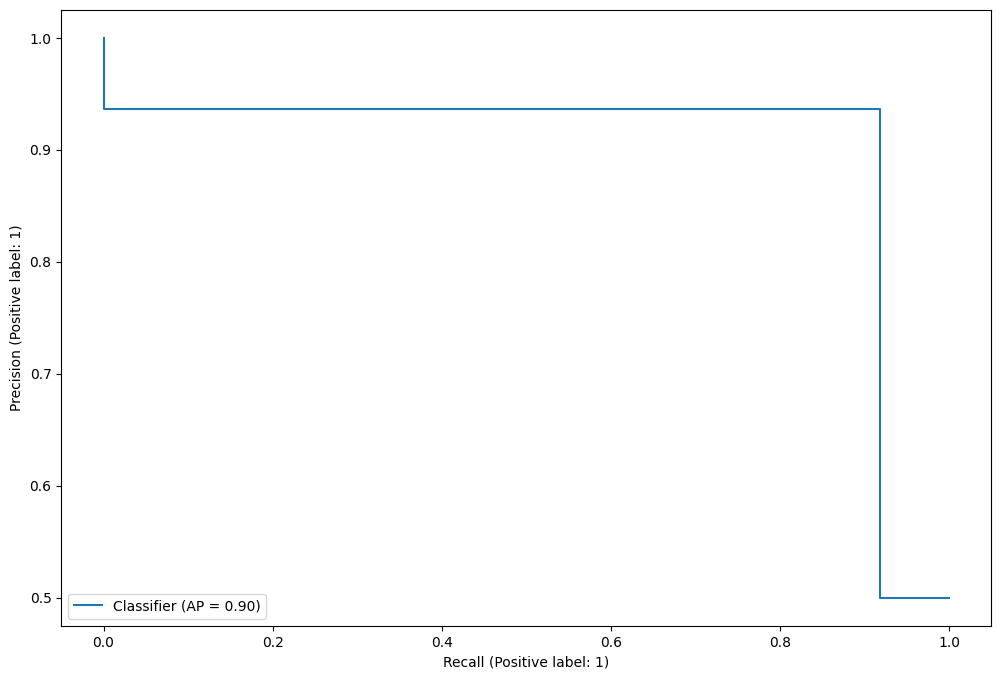

In [118]:
param_grid = {'loss': ['log_loss','binary_crossentropy','categorical_crossentropy'],
              'interaction_cst': ["pairwise", "no_interaction"],
              'learning_rate': [0.2,0.4,0.7,1],
              'max_depth': [15,50,100,150]
             }

grid_hgb = RandomizedSearchCV(HistGradientBoostingClassifier(),param_grid,verbose=3,cv=5)
train_and_evaluate_model(grid_hgb)

## Hyperparameter-Optimized Models Performance Comparison

In [119]:
model_perfs = pd.DataFrame(list(zip(model_names,accuracy_scores,precision_scores,recall_scores,f1_scores,roc_auc_scores)),columns=['Model','Accuracy','Precision','Recall','F1','ROC AUC Score']).sort_values('Accuracy',ascending=False).reset_index(drop=True)
model_perfs

Model  Accuracy  Precision  \
0   RandomizedSearchCV(cv=5,\n                   e...     0.979      0.984   
1   <catboost.core.CatBoostClassifier object at 0x...     0.972      0.979   
2   RandomizedSearchCV(estimator=LGBMClassifier(),...     0.967      0.970   
3   XGBClassifier(base_score=None, booster=None, c...     0.966      0.965   
4                                 BaggingClassifier()     0.959      0.964   
5   RandomizedSearchCV(cv=5, estimator=RandomFores...     0.957      0.955   
6                            RandomForestClassifier()     0.955      0.954   
7                              ExtraTreesClassifier()     0.954      0.949   
8   RandomizedSearchCV(estimator=ExtraTreesClassif...     0.948      0.940   
9                            DecisionTreeClassifier()     0.945      0.946   
10  RandomizedSearchCV(cv=5, estimator=DecisionTre...     0.934      0.937   
11                                   LGBMClassifier()     0.928      0.923   
12  RandomizedSearchCV(cv=5, estimator=HistGradien...     0.928      0.936   
13  RandomizedSearchCV(cv=5, estimator=KNeighborsC...     0.911      0.890   
14                   HistGradientBoostingClassifier()     0.896      0.891   
15                             KNeighborsClassifier()     0.878      0.843   
16                       GradientBoostingClassifier()     0.821      0.824   
17                                    MLPClassifier()     0.804      0.794   
18  XGBRFClassifier(base_score=None, booster=None,...     0.779      0.738   
19                               AdaBoostClassifier()     0.775      0.791   
20                               LogisticRegression()     0.751      0.764   
21  RandomizedSearchCV(cv=5, estimator=LogisticReg...     0.751      0.764   
22                                        LinearSVC()     0.748      0.774   
23                                  RidgeClassifier()     0.748      0.775   
24  RandomizedSearchCV(cv=5, estimator=RidgeClassi...     0.748      0.775   
25                                       GaussianNB()     0.743      0.808   
26  RandomizedSearchCV(cv=5, estimator=LinearSVC()...     0.741      0.812   
27                                    SGDClassifier()     0.741      0.812   
28  RandomizedSearchCV(cv=5, estimator=BernoulliNB...     0.736      0.785   
29                                      BernoulliNB()     0.729      0.773   
30                      PassiveAggressiveClassifier()     0.577      0.584   

    Recall    F1  ROC AUC Score  
0    0.975 0.979          0.979  
1    0.965 0.972          0.972  
2    0.964 0.967          0.967  
3    0.967 0.966          0.966  
4    0.953 0.958          0.959  
5    0.960 0.957          0.957  
6    0.956 0.955          0.955  
7    0.959 0.954          0.954  
8    0.956 0.948          0.948  
9    0.945 0.945          0.945  
10   0.931 0.934          0.934  
11   0.935 0.929          0.928  
12   0.918 0.927          0.928  
13   0.938 0.913          0.911  
14   0.901 0.896          0.896  
15   0.929 0.884          0.878  
16   0.817 0.820          0.821  
17   0.821 0.807          0.804  
18   0.865 0.797          0.779  
19   0.748 0.769          0.775  
20   0.726 0.745          0.751  
21   0.726 0.745          0.751  
22   0.701 0.736          0.748  
23   0.700 0.736          0.748  
24   0.700 0.736          0.748  
25   0.636 0.712          0.743  
26   0.626 0.707          0.741  
27   0.626 0.707          0.741  
28   0.652 0.712          0.736  
29   0.647 0.704          0.729  
30   0.539 0.560          0.577

In [120]:
model_perfs.iloc[0]['Model']

"RandomizedSearchCV(cv=5,\n                   estimator=<catboost.core.CatBoostClassifier object at 0x00000294F30367A0>,\n                   param_distributions={'learning_rate': [0.2, 0.4, 0.7, 1],\n                                        'n_estimators': [200, 500, 1000]},\n                   verbose=3)"

The hyperparameter-optimized Cat Boost Classifier produces the best performance among all machine learning models by achieving an outstanding accuracy of nearly 98% on the test dataset. 

## Saving the best performing model for deployment into production

In [105]:
grid_cat.fit(final_X_train,y_train_tf)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.7, n_estimators=200;, score=0.976 total time=   6.1s
[CV 2/5] END learning_rate=0.7, n_estimators=200;, score=0.974 total time=   5.4s
[CV 3/5] END learning_rate=0.7, n_estimators=200;, score=0.972 total time=   4.9s
[CV 4/5] END learning_rate=0.7, n_estimators=200;, score=0.974 total time=   5.2s
[CV 5/5] END learning_rate=0.7, n_estimators=200;, score=0.975 total time=   4.9s
[CV 1/5] END learning_rate=0.4, n_estimators=200;, score=0.973 total time=   5.4s
[CV 2/5] END learning_rate=0.4, n_estimators=200;, score=0.968 total time=   3.6s
[CV 3/5] END learning_rate=0.4, n_estimators=200;, score=0.969 total time=   5.1s
[CV 4/5] END learning_rate=0.4, n_estimators=200;, score=0.970 total time=   5.7s
[CV 5/5] END learning_rate=0.4, n_estimators=200;, score=0.968 total time=   5.9s
[CV 1/5] END learning_rate=0.2, n_estimators=200;, score=0.962 total time=   5.2s
[CV 2/5] END learning_rate=0.2, n_est

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x00000294F30367A0>,
                   param_distributions={'learning_rate': [0.2, 0.4, 0.7, 1],
                                        'n_estimators': [200, 500, 1000]},
                   verbose=3)

In [106]:
print("Average cross validation accuracy:",round(np.mean(cross_val_score(grid_cat,final_X_test,y_test_tf,scoring='accuracy',cv=5,verbose=0)),2))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.2, n_estimators=1000;, score=0.970 total time=  14.9s
[CV 2/5] END learning_rate=0.2, n_estimators=1000;, score=0.972 total time=  15.9s
[CV 3/5] END learning_rate=0.2, n_estimators=1000;, score=0.975 total time=  15.0s
[CV 4/5] END learning_rate=0.2, n_estimators=1000;, score=0.966 total time=  14.6s
[CV 5/5] END learning_rate=0.2, n_estimators=1000;, score=0.975 total time=  14.1s
[CV 1/5] END learning_rate=0.2, n_estimators=200;, score=0.948 total time=   3.4s
[CV 2/5] END learning_rate=0.2, n_estimators=200;, score=0.951 total time=   3.5s
[CV 3/5] END learning_rate=0.2, n_estimators=200;, score=0.954 total time=   3.7s
[CV 4/5] END learning_rate=0.2, n_estimators=200;, score=0.953 total time=   3.8s
[CV 5/5] END learning_rate=0.2, n_estimators=200;, score=0.958 total time=   3.6s
[CV 1/5] END learning_rate=0.7, n_estimators=1000;, score=0.969 total time=  13.1s
[CV 2/5] END learning_rate=0.7,

[CV 5/5] END learning_rate=0.2, n_estimators=1000;, score=0.976 total time=  10.1s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.2, n_estimators=1000;, score=0.966 total time=  10.9s
[CV 2/5] END learning_rate=0.2, n_estimators=1000;, score=0.967 total time=  11.3s
[CV 3/5] END learning_rate=0.2, n_estimators=1000;, score=0.971 total time=  11.0s
[CV 4/5] END learning_rate=0.2, n_estimators=1000;, score=0.972 total time=  11.4s
[CV 5/5] END learning_rate=0.2, n_estimators=1000;, score=0.973 total time=  12.8s
[CV 1/5] END learning_rate=0.4, n_estimators=500;, score=0.963 total time=   6.6s
[CV 2/5] END learning_rate=0.4, n_estimators=500;, score=0.965 total time=   6.4s
[CV 3/5] END learning_rate=0.4, n_estimators=500;, score=0.970 total time=   6.9s
[CV 4/5] END learning_rate=0.4, n_estimators=500;, score=0.970 total time=   8.2s
[CV 5/5] END learning_rate=0.4, n_estimators=500;, score=0.973 total time=   7.2s
[CV 1/5] END learning_rate=0.2,

[CV 4/5] END .learning_rate=1, n_estimators=200;, score=0.960 total time=   3.1s
[CV 5/5] END .learning_rate=1, n_estimators=200;, score=0.961 total time=   3.1s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.2, n_estimators=200;, score=0.943 total time=   3.3s
[CV 2/5] END learning_rate=0.2, n_estimators=200;, score=0.951 total time=   3.3s
[CV 3/5] END learning_rate=0.2, n_estimators=200;, score=0.952 total time=   3.6s
[CV 4/5] END learning_rate=0.2, n_estimators=200;, score=0.955 total time=   3.4s
[CV 5/5] END learning_rate=0.2, n_estimators=200;, score=0.958 total time=   3.4s
[CV 1/5] END learning_rate=0.7, n_estimators=1000;, score=0.960 total time=  12.2s
[CV 2/5] END learning_rate=0.7, n_estimators=1000;, score=0.969 total time=  12.1s
[CV 3/5] END learning_rate=0.7, n_estimators=1000;, score=0.968 total time=  12.4s
[CV 4/5] END learning_rate=0.7, n_estimators=1000;, score=0.970 total time=  12.6s
[CV 5/5] END learning_rate=0.7, n_e

In [107]:
joblib.dump(grid_cat,'model.pkl')

['model.pkl']

In [108]:
model = joblib.load('model.pkl')
model

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000029495486440>,
                   param_distributions={'learning_rate': [0.2, 0.4, 0.7, 1],
                                        'n_estimators': [200, 500, 1000]},
                   verbose=3)

In [123]:
joblib.dump(scaler,'scaler.pkl')

['scaler.pkl']

In [124]:
scaler = joblib.load('scaler.pkl')
scaler

StandardScaler()

In [121]:
final_X_train

DURATION    AGE  NET_SALES  GENDER  AGENCY_TYPE  COMMISSION  \
0         0.466 -1.575      1.213  -1.627       -1.078      -0.138   
1        -0.654 -0.113     -0.091   0.615        0.927      -0.138   
2         0.169 -0.113     -0.150   0.615        0.927      -0.138   
3         0.184  2.187     -0.782  -1.627       -1.078      -0.138   
4         0.212  1.043     -0.485   0.615        0.927      -0.138   
...         ...    ...        ...     ...          ...         ...   
74259     0.149  0.782     -0.604   0.615        0.927      -0.138   
74260    -0.379  2.102      0.599  -1.627       -1.078      -0.138   
74261     1.779 -1.049      1.747   0.615       -1.078      -0.138   
74262    -0.148  0.824      1.537  -1.627       -1.078      -0.138   
74263     0.635 -0.113      0.731   0.615        0.927      -0.138   

       AGENCY_C2B  SINGAPORE  PRODUCT_NAME_Bronze Plan  \
0           1.315      1.206                    -0.416   
1          -0.761     -0.829                    -0.416   
2          -0.761     -0.829                    -0.416   
3          -0.761     -0.829                    -0.416   
4          -0.761     -0.829                    -0.416   
...           ...        ...                       ...   
74259      -0.761     -0.829                    -0.416   
74260       1.315      1.206                    -0.416   
74261       1.315      1.206                    -0.416   
74262      -0.761     -0.829                    -0.416   
74263      -0.761     -0.829                    -0.416   

       PRODUCT_NAME_Silver Plan  PRODUCT_NAME_Annual Silver Plan  \
0                         3.046                           -0.323   
1                        -0.328                           -0.323   
2                        -0.328                           -0.323   
3                        -0.328                           -0.323   
4                        -0.328                           -0.323   
...                         ...                              ...   
74259                    -0.328                           -0.323   
74260                    -0.328                           -0.323   
74261                    -0.328                            3.094   
74262                    -0.328                           -0.323   
74263                    -0.328                           -0.323   

       PRODUCT_NAME_Cancellation Plan  AGENCY_EPX  
0                              -0.444      -0.769  
1                              -0.444       1.300  
2                              -0.444       1.300  
3                              -0.444      -0.769  
4                              -0.444      -0.769  
...                               ...         ...  
74259                           2.253       1.300  
74260                          -0.444      -0.769  
74261                          -0.444      -0.769  
74262                          -0.444      -0.769  
74263                          -0.444       1.300  

[74264 rows x 13 columns]

In [129]:
for col in final_X_train.columns:
    print(f"Min value of {col}:",df[col].min())
    print(f"Max value of {col}:",df[col].max())

Min value of DURATION: -2.7623073469229666
Max value of DURATION: 2.7774797424782847
Min value of AGE: -1.9010510576667607
Max value of AGE: 2.0747358450538473
Min value of NET_SALES: -1.9546597881010226
Max value of NET_SALES: 2.02436566076601
Min value of GENDER: 0
Max value of GENDER: 1
Min value of AGENCY_TYPE: 0
Max value of AGENCY_TYPE: 1
Min value of COMMISSION: 0
Max value of COMMISSION: 2
Min value of AGENCY_C2B: 0
Max value of AGENCY_C2B: 1
Min value of SINGAPORE: 0
Max value of SINGAPORE: 1
Min value of PRODUCT_NAME_Bronze Plan: 0
Max value of PRODUCT_NAME_Bronze Plan: 1
Min value of PRODUCT_NAME_Silver Plan: 0
Max value of PRODUCT_NAME_Silver Plan: 1
Min value of PRODUCT_NAME_Annual Silver Plan: 0
Max value of PRODUCT_NAME_Annual Silver Plan: 1
Min value of PRODUCT_NAME_Cancellation Plan: 0
Max value of PRODUCT_NAME_Cancellation Plan: 1
Min value of AGENCY_EPX: 0
Max value of AGENCY_EPX: 1


In [126]:
gender_encoder.categories_

[array(['F', 'M'], dtype=object)]

In [127]:
commission_encoder.categories_

[array(['Low', 'Medium', 'High'], dtype=object)]

In [128]:
agency_type_encoder.categories_

[array(['Airlines', 'Travel Agency'], dtype=object)]

In [146]:
joblib.dump(pt,'transformer.pkl')

['transformer.pkl']

In [147]:
transformer = joblib.load('transformer.pkl')
transformer

PowerTransformer()